In [6]:
import os

import glob
import pandas as pd
import random
import copy
from llmchem.utils import  make_project_dirs
from llmchem.eval import eval_model

# dataset settings
n_test = 50  # number of testing data
# number of training data for checking (i.e., checking everything takes too long, so we check only a part of training data)
n_train_check = 50

n_prompt_examples = 5

# dataset path
dataset_path = "dataset/231225AutoReasoning/240117best_reason_record_11k.csv"


trial----
model gpt-3.5-turbo-1106 reason: False
Task : results/projects/240118comparisons_wo_reason/GPT-3.5-turbo_3_32_0
test exists: results/projects/240118comparisons_wo_reason/GPT-3.5-turbo_3_32_0
trial----
model gpt-3.5-turbo-1106 reason: True
Task : results/projects/240118comparisons/GPT-3.5-turbo_3_32_0
test exists: results/projects/240118comparisons/GPT-3.5-turbo_3_32_0
trial----
model gpt-4-1106-preview reason: False
Task : results/projects/240118comparisons_wo_reason/GPT-4-turbo_3_32_0
test exists: results/projects/240118comparisons_wo_reason/GPT-4-turbo_3_32_0
trial----
model gpt-4-1106-preview reason: True
Task : results/projects/240118comparisons/GPT-4-turbo_3_32_0
test exists: results/projects/240118comparisons/GPT-4-turbo_3_32_0
trial----
model ft:gpt-3.5-turbo-1106:personal::8kicrQm5 reason: False
Task : results/projects/240118comparisons_wo_reason/GPT-3.5-turbo_3_32_10
test exists: results/projects/240118comparisons_wo_reason/GPT-3.5-turbo_3_32_10
train exists: results

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [00:13<10:39, 13.05s/it]

----


For 2-phenylacetanilide, the base molecule is aniline, with a melting point of -6 degrees Celsius. Acetanilide, which is the generalization of this compound, has a melting point of 114 degrees Celsius, which takes into account the effects of two aromatic rings. The additional phenyl group should contribute further to this structure's melting point. The π-π stacking interactions between the phenyl groups increase the stability of the solid form, elevating the melting point. The intermolecular hydrogen bonding, particularly involving the NH and C=O groups, contribute to a substantially higher melting point. However, the N-phenylamide linkage introduces some torsional strain which slightly reduces the melting point despite more rigidity and planarity in the molecule compared to acetanilide. The moderately bulky groups also generate less efficient crystal packing, which, while still higher than aniline, provides a smaller increase in melting point than would be predicted for a fully

  4%|▍         | 2/50 [00:15<05:29,  6.86s/it]

----


The Ugi product seems to have a multi-cyclic structure with a chelating element (2-enol) and a number of functional groups influencing its boiling point. The target molecule has several instances of enhanced hydrogen bonding, such as amides, phenol, and nitriles, which contribute to a substantial higher boiling point relative to simple hydrocarbons. The base molecules, as shown before, have limited capacity for hydrogen bonding, and the introduction of these functional groups increases the boiling point. Quantifying the effects of such complex interactions requires detailed analysis. However, considering the boiling point increase due to a strong hydrogen bond (like in an amide group) is approximately between 100-150 °C per amide, there are two potential amides with a combined estimated increase of 200 to 300. The phenolic group may add an estimated 100 due to strong intermolecular interaction. The aromaticity and conjugation present may contribute another 50-100 °C. Accounting 

  6%|▌         | 3/50 [00:18<04:04,  5.21s/it]

----


The basic unit, pyridine, has a melting point of -42 degrees Celsius. Adding a methyl group, which is generally a small and non-polar substituent, would modestly increase the melting point due to a slight increase in molecular weight, but this is often compensated for by a decrease in polarity and intermolecular interactions. The value for a methyl group on benzene is about 2.6, so for a pyridine ring, we might expect a slightly higher value, say, 3. Considering the similarity in size and electronegativity between a carbon atom in a methyl group and a hydrogen in pyridine, we could attribute this to a slight increase in van der Waals interactions. The presence of the additional methyl group might offer a further increase of 3.0 due to increased molecular weight and potential for more extensive van der Waals interactions.

The combined effect of these two methyl groups would signify a total elevation of 6 degrees Celsius. However, the accurate prediction without the ability to re

  8%|▊         | 4/50 [00:20<02:53,  3.78s/it]

----


The basic unit, methane, having a melting point of -182.5°C, establishes a frame of reference. Acetaldehyde contains -CHO, a polar functional group with a partial positive charge on the carbon, which allows for some dipole-dipole interactions, raising the melting point. Also, the slight gain in molecular weight contributes marginally. The alkyl effect on homologous series can be noticed with increasing melting points. Taking all these factors into account, acetaldehyde's melting point would be slightly higher than that of methane.
##Prediction: -123.0
actual:  -125.0 predicted:  -123.0
promlem 5 / 50


 10%|█         | 5/50 [00:22<02:24,  3.21s/it]

----


The basic unit for analysis is androstane, which has a melting point of about 178.5°C. For 3-ethyl-3-hydroxyandrostan-17-one, we will consider the effects of the additional functional groups quantitatively. The ethyl group (CH2CH3) is a moderately large alkyl group attached to the steroid nucleus, which would increase the melting point due to an increase in van der Waals interactions; this might be estimated at +20°C. The presence of a keto group at position 17 introduces a strong polar carbonyl group, leading to hydrogen bonding and dipole-dipole interactions, and would significantly increase the melting point; this might be quantified as +70°C. Overall, adding the effects of the ethyl group and the keto group to the base compound of androstane's melting point should give us the prediction.
##Prediction: 268.0
actual:  115.0 predicted:  268.0
promlem 6 / 50


 12%|█▏        | 6/50 [00:45<07:11,  9.80s/it]

----


The predicted melting point is based on the functional group analysis and their effects on intermolecular forces compared to a reference compound. To make predictions more accurate, the influence of Methyl, OCH3, Carboxyl, Amino, Keto, Ester, Bromide, Thiazole, and Sulfur-bridged Phenyl Ring Functional Groups are taken into account. The base compound such as benzene has a melting point of 5.5 °C, considering it as a reference:
- Methyl group increases the melting point by about 15.5 because of its added molecular weight and slight increase in van der Waals forces.
- OCH3 group (methoxy) raises it by around 11 due to an increase in molecular weight and potential for hydrogen bonding with other functional groups.
- Carboxyl groups significantly increase the melting point due to strong hydrogen bonding and dipole-dipole interactions; each is estimated at +120 °C.
- Amino group raises it by 40 with its ability to form strong intermolecular hydrogen bonds.
- Keto group enhances by ab

 14%|█▍        | 7/50 [00:49<05:37,  7.85s/it]

----


To predict the melting point of anthranol, a basic unit of anthracene, we can consider the following factors based on the data for similar molecules: 

- Basic unit of anthracene has a melting point of 218.0. 
- Introduction of the alcohol (-OH) group usually decreases the melting point due to hydrogen bonding, but it might slightly increase the melting point in an aromatic system due to enhanced molecular rigidity. A conservative estimate for this type of hydroxyl group could be an addition of +3.0. 

Therefore, the combined effect can be expected to bring the melting point down slightly. However, the introduction of the hydroxyl (–OH) group does not significantly alter the melting point of anthranol, as it is already part of the fused ring system and lacks extensive hydrogen bonding. Therefore, we might expect a very minor decrease from the basic unit value of anthracene: 
- From basic unit anthracene, subtracting a minimal expectation of an additional hydroxyl group's effect.

 16%|█▌        | 8/50 [00:51<04:21,  6.22s/it]

----


To predict the melting point of trimethylsilyl isothiocyanate, we must consider the effects of its functional groups on the compound's melting behavior. The presence of the isothiocyanate group (-N=C=S) generally increases the melting point due to stronger intermolecular interactions, especially dipoles and polarizability. This functional group might increase the melting point by about +80 from a basic alkane. The attached trimethylsilyl group (Si(CH3)3) is a large, highly branched, substituent which could moderately reduce the melting point due to steric hindrance that hinders close packing. This effect could be in the range of -5 to -15 for the additional Si(CH3)3 group, making the total adjustment +80 - (-5 to -15). Tertiary amines attached to Si have been known to lower the melting point of silicon compounds. With an overall adjustment for both functional groups, we arrive at an estimated increase in melting point.
##Prediction: -56.0
actual:  -33.0 predicted:  -56.0
promlem

 18%|█▊        | 9/50 [00:56<03:57,  5.79s/it]

----


To predict the melting point of pyrazoxyfen, one must consider its structural features and their contribution to the overall melting point. The presence of the aromatic rings generally leads to higher melting points due to more extensive π-π interactions, while halogens on the benzene rings contribute to increased melting points by enhancing intermolecular interactions through polarizability. Carboxylic acid groups form strong hydrogen bonds, further raising the melting point. However, the compound also contains ether linkages and some steric hindrance, which might lower the overall melting point by decreasing the packing efficiency of the crystal lattice. The basic unit to consider for predicting the melting point could be a trihalomethyl triazole associated with ester groups which in turn are part of a carboxylic acid complex, but the precise structural similarity for an exact match is not immediate. For an approximation, we can consider these different functionalities and the

 20%|██        | 10/50 [00:59<03:19,  4.98s/it]

----


The prediction for 2,6-dinitrotoluene is the melting point of benzene as a baseline (5.5) plus the melting points associated with the substituents. Methyl group (CH3) doesn't significantly affect the melting point, so its influence can be considered minimal. The nitro group (-NO2) is a very strong electron-withdrawing group that increases melting point significantly through its capability to form more intermolecular interactions, particularly dipole-dipole interactions and potential for hydrogen bonding in solid state when in conjugation with other electronegative groups. Given their melting point ranges, the addition of two nitro groups to benzene could reasonably be estimated to add approximately +40 to +60 units each (due to their strong electronegativity and both being meta-directors, thus not impacting ortho and para interactions). Moreover, the compound is symmetrical and rigid, which usually increases the melting point due to favorable crystal packing: (5.5 [benzene] + 55

 22%|██▏       | 11/50 [01:02<02:47,  4.28s/it]

----


For m-chlorobenzophenone, the functional groups to consider are a benzophenone (base structure with the phenyl groups and ketone) and a meta-chloro substituent. Benzophenones have a relatively high melting point due to the rigid aromatic structure which allows for strong intermolecular interactions, predicting a high base value. The meta-chloro group enhances the melting point due to its high electronegativity and inductive effect, which can increase intermolecular hydrogen bonding and dipole-dipole interactions. Each chlorine atom in an aromatic ring generally increases the melting point by adding to the molecule's polarizability and providing a dipole moment. The additional chloro group is here via a meta linkage which does not disrupt planarity as with para attachment, hence its effect should be similar to the previously considered chlorine atom (around +10.0). However, the actual value is lower than anticipated, suggesting that the meta position is not as effective at reinfo

 24%|██▍       | 12/50 [01:04<02:11,  3.46s/it]

----


To predict the melting point of '2-iodobenzoic acid', we consider the effects of functional groups on the parent compound, benzene (which has a melting point of 5.5 °C) : 
- The carboxylic acid group significantly raises the melting point due to the ability for carboxylic acids to form strong intermolecular hydrogen bonds. This could add about +170 °C to the expected melting point. 
- The iodine substitution adds to the molecular weight and increases London dispersion forces due to the larger size and higher molar mass; let's estimate this as an additional +20 °C. By combining these increments with the base melting point of benzene, we arrive at the adjusted prediction.
##Prediction: 196.0
actual:  162.5 predicted:  196.0
promlem 13 / 50


 26%|██▌       | 13/50 [01:06<02:02,  3.30s/it]

----


For predicting the melting point of dimethyl pyridine-2,5-dicarboxylate, analyzing the impact of functional groups and the basic moiety is crucial. The base molecule, pyridine, has a melting point of -42 degrees Celsius. Pyridine derivatives such as pyridine carboxylic acids typically have higher melting points due to the ability to form hydrogen bonds; however, they can sometimes exhibit lower melting points due to steric hindrance from bulky groups. The functional groups in dimethyl pyridine-2,5-dicarboxylate include two carbomethoxy (COOCH3) ester groups. Each of these ester groups may contribute positive steric hindrance effects, possibly raising the melting point by an average of 33 degrees Celsius based on the carboxylate group's ability to form intermolecular hydrogen bonds and non-covalent interactions. The esterification might increase the polarity slightly, but due to the relatively nonpolar nature of esters, this effect is minor. As there isn't a straight additive mod

 28%|██▊       | 14/50 [01:09<01:49,  3.05s/it]

----


The prediction for a compound like (~2~H_5_)Ethan(~2~H)ol, otherwise known as deuterated ethanol, would require knowing the baseline melting point of an analogous compound and then adjusting for the specific effect of deuterium atoms. Let us take the melting point of an analogous compound, ethanol, which is approximately -114.1 °C. When hydrogen atoms are replaced by deuterium atoms, there is typically a shift in the melting point due to the increase in mass, hydrogen bonds' strength being somewhat diminished, and other effects such as zero-point vibrational energy change between hydrogen and deuterium. The effect is usually an increase in melting point, as overall intermolecular forces are slightly enhanced, and specifically, the contribution for each D-H bond is greater than that of a H-H bond. For each deuteration, we might expect an increase in melting point of about 3°C. Since each of the five hydrogens in ethanol can be deuterated, and all are equivalent, the increase can 

 30%|███       | 15/50 [01:12<01:47,  3.07s/it]

----


Factors affecting melting point (MP) for Trifluridine:
- The sugar moiety can lead to increased melting point due to additional hydrogen bonding capability.
- The thiophene-like ring may increase melting point as well, as it introduces a more rigid structure and additional pi-pi interactions.
- The fluoro groups usually lead to an elevation in the melting point due to high electronegativity, which increases dipole-dipole interactions, and it also makes the molecule more hydrophobic, which increases the ability to form intermolecular hydrogen bonds.
- The large, complex, and polarizable molecule includes several functional groups which can contribute to the overall melting point.
- The presence of the fluorine atoms adds to the molecular weight and electronegativity, leading to stronger intermolecular forces and a higher melting point. Each fluorine might contribute around 5 units to the predicted value.
- The trityl methyl group may contribute to the compactness and intermolecul

 32%|███▏      | 16/50 [01:16<01:54,  3.38s/it]

----


The given value for tricosane is incorrect. Tricosane is a straight-chain alkane with 23 carbon atoms. In general, as the carbon chain length increases, so does the melting point. This trend is approximately +20 for each additional methylene (-CH2-) group beyond two carbons. Baseline for an alkane with 20 carbons is approximately 55-57. The increase for each additional methylene group is around +0.8. Since tricosane has 23 carbon atoms, we start from the value of a C20 alkane and add the adjustment for +3 additional carbons.
##Prediction: -52.0 (Tricosane actual: -6.2)
For other compounds, the prediction fails to consider the actual ranges of common melting points for such groups, instead significantly underestimating the impacts. Given this significant discrepancy in the underlying assumptions, a detailed reevaluation of the supporting data and trends needs to be conducted to provide more accurate predictions.
##Prediction: 138.0 (1-cyclopentene-1-carboxylic acid, 2,3,3-trimeth

 34%|███▍      | 17/50 [01:21<02:04,  3.76s/it]

----


The benzene ring is a common structure in organic compounds, with a typical melting point of 5.5 °C. For 4-acetylbutyric acid, the acetyl group (-COCH3) can be expected to both increase and decrease the melting point; for this estimation, we consider the effect of extended conjugation with the benzene ring which could suggest either a slight increase due to enhanced intermolecular interaction or a lowering due to steric hindrance between the acetyl group and the benzene ring, but appreciate that extended conjugation from the acid moiety may dominate. Thus, the predicted effect may be smaller. The butyrate structure introduces additional molecular weight and potential for increased van der Waals interactions, which typically raises the melting point, and a prediction of 12 °C is reasonable as an intermediary effect of all these groups. For pyrantel, it is a complex structure where effects are expected to be additive. By breaking it down, the pyridyl- and benzene-related rings gen

 36%|███▌      | 18/50 [01:24<01:52,  3.52s/it]

----


Following are the individual effects on the melting point for bis(2-naphthyl)ether: 
- Systems with a significant degree of conjugation and aromatic ring structures can have higher melting points due to a more extended pi-electron system, in this case, the two naphthalene units, which can contribute roughly +20 per naphthalene for a total increase. 
- Ether linkage is a weaker intermolecular force than some other functional groups, and typically does not significantly increase the melting point in its isolated form. However, in this structure, the ether linkage could contribute approximately +2 to +4 due to potential dipole-dipole interactions, and a possible increase in symmetry which makes crystalline packing more efficient. As this is difficult to estimate, we will take the middle value of +3. 
- The presence of a large nonplanar and bulky molecular structure in comparison to naphthalene, can somewhat disrupt the packing of the molecules in a crystal, potentially decreasing t

 38%|███▊      | 19/50 [01:27<01:47,  3.46s/it]

----


When predicting the melting point for 1-cyclopentene-1-carboxylic acid, 2,3,3-trimethy, which has a chemical structure suitable for a carboxylic acid, we must first consider the melting point of a benchmark substance like cyclopentene, which has a melting point of around -87 degrees Celsius. The addition of a carboxylic acid group could notably increase the melting point due to the potential for intermolecular hydrogen bonding, which could add an estimated.
- The acid moiety: +157 degrees, as this can partake in strong intermolecular hydrogen bonding.
- Additionally, the influence of bulky methyl substituents attached near the acid group might slightly lower the increase provided by the hydrogen bonding by steric hindrance, which we can estimate a decrease for each methyl group:
- Methyl on C2: -0.5 degrees.
- Methyl on C3, which is also on a tertiary carbon and is alkyl part of tert-butyl group: -2 degrees.
- Methyl on C3', closer to the acid, we estimate a slightly higher infl

 40%|████      | 20/50 [01:29<01:31,  3.04s/it]

----


The prediction begins with the basic unit, benzene, which typically has a melting point around 5.5 °C. Adding an acrylonitrile group (–C≡N) increases molecular weight and introduces stronger van der Waals forces. Given the robust nature of triple bonds and a polar cyano group, it likely raises the melting point by approximately 80 °C. The amino group (–NH2) and the carbonyl group (C=O) present in a conjugated system both contribute to intermolecular hydrogen bonding and dipole-dipole interactions. These functional groups typically contribute around 30 °C each. The keto group (C=O) might contribute slightly less than ester or amide groups (which are often closer to 40 °C each) due to its position in β-keto, so an estimate of 30 °C can be used.
##Prediction: 167.0
actual:  158.7 predicted:  167.0
promlem 21 / 50


 42%|████▏     | 21/50 [01:33<01:33,  3.23s/it]

----


To predict the melting point of an accurately named 2,2′-(4,6-dinitrobenzene-1,3-diyl)bis(2-oxoethanediazonium) having the provided SMILES form, which includes multiple functional groups, each will be individually considered and adjustments made based on their quantitative impacts over a benzene baseline assumed to be around 42 °C (the melting point of benzene); - The Tollen's reagent anion (-C≡N) contributes to a higher melting point due to its positive charge and resonance stabilization. As a quaternary ammonium salt it can drastically increase melting point by about 425 °C in generally less polar solvents. - The nitro group typically raises melting points by increasing solid-state stabilization and intermolecular interactions; two nitro groups on a benzene core might increase this by around 40 to 50 °C each, considering their electron-withdrawing effects, resonance, and steric hindrance. However, with them positioned symmetrically on the biphenyl structure, their contribution

 44%|████▍     | 22/50 [01:41<02:12,  4.72s/it]

----


To predict the melting point of Phenprocoumon, we need to consider the impact of its various functional groups and structural features. The base structure we'll build on is benzene, which has a melting point of 5.5 degrees Celsius. Phenprocoumon is a multi-ring compound with a fused pyran and a coumarin structure. Each pyran unit adds rigidity and the potential for additional aromatic stacking interactions among the pyridine, pyran, and phenyl rings, which significantly increases the melting point. Each ester group also typically raises the melting point by enhancing molecular polarity and the potential for dipole-dipole interactions. Because of this complexity, we must estimate the quantitative effects of the several structual features without over or underestimating the effect: Benzene base structure: 5.5 degrees Celsius, Fused pyran ring systems: +60.0 (due to rigid structure and additional aromatic ring), Coumarin structure: +55.0 (for the planar arrangement of carbonyl and 

 46%|████▌     | 23/50 [01:44<01:52,  4.16s/it]

----


The initial predictions did not match the actual values. We need to reassess the predictions by focusing on the functional groups and their influence. The base unit, pentane, has a melting point around -130. Hydrocarbons increase this due to van der Waals forces. However, the effects of the following functional groups were misestimated: 
- Two keto groups: Instead of reducing the melting point, as initially assumed, they contribute substantially to the intermolecular forces due to the possibility for hydrogen bonding and dipole moments, increasing the melting point. 
- Four methyl groups (two on each end of the molecule): These substantially increase the van der Waals interactions, which were underestimated in the initial prediction. 
Considering the re-evaluation of the functional groups, the predicted value must align more closely with the actual value of 97.0, rather than 105.0 as previously indicated. 

Revised Prediction: 97.0
actual:  -25.2 predicted:  97.0
promlem 24 / 50

 48%|████▊     | 24/50 [01:46<01:35,  3.66s/it]

----


Basic unit: Benzene, which has a melting point of 5.5. Halogen (chloro) substituent at the phenyl group: +7.0 (increases the melting point due to additional polarity and intermolecular forces). Alkene linker: +32.0 (conjugation may improve packing efficiency and rigidity, elevating the melting point). Cyclohexane carbohydrazide group: +8.0 (carbonyl groups and hydrazines are capable of extensive hydrogen bonding and dipole-dipole interactions. The bulkiness of the group may marginally hinder packing, but the overall effect of the functional group is predominant). Combining phenyl, halogen, and linker effects. Furthermore, branching would likely lower the melting point, but it may be more than compensated by the effects of the above groups.
##Prediction: 118.0
actual:  164.0 predicted:  118.0
promlem 25 / 50


 50%|█████     | 25/50 [01:52<01:45,  4.22s/it]

----


The basic unit under consideration can be pyridine, which has a melting point of about -42°C. The presence of the carbon-sulfur double bond (thioketone) in thio- pyridine (2(1H)-pyridinethione) significantly increases the melting point due to the more extensive covalent character of the carbon-sulfur bond, compared to a carbon-nitrogen double bond, for example, in pyridine. The rigidity it imparts to the structure also increases melting point due to better packing in the solid state. An aryl group typically raises the melting point due to pi-pi stacking and symmetry of the molecule, which in this case is already present in the pyridine ring. No alkyl groups are added in this case that might have reduced melting point through disorder effect. Considering these influences, a thioketone in a similar structure has been estimated to increase the melting point by approximately 123°C (N-phenyl-2-aminothiazol-4(5H)-one has a melting point of about 81°C vs. a reference pyridine melting p

 52%|█████▏    | 26/50 [01:56<01:37,  4.08s/it]

----


To predict the melting point of 1,4-bis(3-oxo-1-butenyl)benzene, several factors need to be considered. Benzene, as a basic unit, has a rather low melting point of 5.5 °C. An important consideration is the effect of substituents on the benzene ring in the compound. In this particular case, there are two isoprenoid chains which will significantly change the melting point due to their size, and presence of double bonds. Taking isoprene (-146 °C) as a simple unsaturated reference, we can infer that the addition of the butenyl group and other carbon chain features will raise the melting point by electronic effects and size. Each butenyl would contribute positively, specifically each conjugated carbonyl group such as a 3-oxo-1-butene can elevate the melting point moderately. Since they are positioned ortho to each other (1,4 positions), there may also be intramolecular hydrogen bonding which will increase the melting point. These increments can be postulated into a combined figure. T

 54%|█████▍    | 27/50 [01:59<01:28,  3.85s/it]

----


To predict the melting point of 9,10-anthracenedione, 2,3-dimethyl-, we need to consider the effects of its functional groups compared to a basic unit. The basic unit here could be anthracene, which has a relatively high melting point of 218. For 2,3-dimethylanthraquinone, the introduction of two methyl groups increases molecular weight and van der Waals interactions, yet the steric hindrance somewhat reduces pi-pi stacking interactions. Methyl groups can generally raise the melting point by approximately +5 each. There are two carbonyl groups (quinone structure), which strongly increase the melting point due to electron inductive effects and the potential for hydrogen bonding. Each carbonyl could raise the melting point by approximately +15 to +20. Combining these effects, we predict an increase in melting point relative to anthracene.

The quantitative effects can be estimated as follows:
- Methyl groups: +5 (3 from each increases van der Waals forces)
- Carbonyl groups: +30 t

 56%|█████▌    | 28/50 [02:01<01:14,  3.38s/it]

----


The melting point of a molecule takes into account factors such as molecular weight, functional group interactions, symmetry, polarity, and potential for intermolecular attractions. For the molecule pyridine, 2-(2-phenylethyl)-, the basic unit pyridine has a melting point of -42°C (basic nitrogenous six-membered ring with an electronegative nitrogen atom). Introducing two benzene rings tends to make the melting point higher due to increased molecular weight and pi-pi stacking interactions, estimated at +180°C due to the combined contribution of the aromatic and conjugated double bond systems that can strengthen crystal lattice interactions. The ethyl group attached to the nitrogen increases the molecular size and possible Van der Waals interactions, which is predicted to raise the melting point by approximately +30°C. However, the steric hindrance from a substituent attached to the pyridine nitrogen might disfavor strong molecular packing, possibly lowering the melting point sli

 58%|█████▊    | 29/50 [02:04<01:06,  3.18s/it]

----


The target compound, 4,4'-thiodiphenol, contains several functional groups that significantly influence the melting point. Analyzing the importance of each: - The benzene rings significantly increase the melting point due to pi-pi stacking and increased molecular rigidity. Here, they should contribute approximately +80 each. - The OH groups can form hydrogen bonds, which also raise the melting point. Considering there are two OH groups, a substantial increase of around +80 is reasonable for both taken together. - The presence of the sulfur atom connecting the two benzene rings introduces some steric hindrance but might also add to the overall rigidity and some intermolecular sulfur-aromatic interactions, providing a smaller increase of perhaps +2 to +5. Sum of contributions from these features should be in line with the actual melting point. To simplify this slightly, we could consider the total for the two benzene rings as about +155. This more accurately reflects the substanti

 60%|██████    | 30/50 [02:06<00:54,  2.72s/it]

----


Factors affecting the melting point of dichloromethane include electronegativity, dipole moment interactions, and molecular symmetry. Chlorine atoms are strongly electronegative, contributing to a high melting point. However, molecular symmetry can reduce it due to a lack of permanent dipole-dipole interactions. Nevertheless, as a small molecule, the influence of polarizability is limited. The effect of electronegativity and symmetrical structure needs to be quantitatively weighed. Each chlorine had an estimated influence-on melting point, with electronegativity increasing potential by around 5 and the symmetrical structure reducing it substantially compared to a non-symmetrical structure by around 10. Therefore, the +5 and -10 contribute to the estimation for each chlorine atom.
##Prediction: -97.0
actual:  -95.0 predicted:  -97.0
promlem 31 / 50


 62%|██████▏   | 31/50 [02:08<00:48,  2.56s/it]

----


The basic unit is benzene, which has a melting point of 5.5 °C. Bromine is a heavy halogen and its presence in the compound increases the molecular weight and the van der Waals forces, resulting in a substantial increase in the melting point, estimated at +70 °C. A trifluoromethyl group is strongly electron-withdrawing and enhances intermolecular associations, contributing approximately +50 °C to the melting point. The chloro group is also electron-withdrawing and adds to the molecular weight; its contribution to the melting point is about +40 °C. The presence of a benzyl group generally increases the melting point due to additional van der Waals forces and potential for π-π stacking, adding approximately +15 °C. Considering possible steric hindrance and the larger molecule's difficulty to pack neatly, some of the smaller values attributed to each functional group are adjusted downwards.
##Prediction: 180.0
actual:  38.0 predicted:  180.0
promlem 32 / 50


 64%|██████▍   | 32/50 [02:13<01:00,  3.38s/it]

----


Alkaloids such as naringenine typically have a complex structure due to the presence and effects of a variety of functional groups like hydroxyls and carbonyls, which can dramatically change the substances melting points. The basic structure for predictions for alkaloids and related compounds should generally be based on aromatic systems, which have inherently higher melting points due to their pi stacking interactions. For naringenine, which has a flavonoid-type structure, we can expect some benzene-like properties to set a base melting point. The furan ring could slightly decrease the melting point compared to a benzene ring due to its decreased stability. However, we can expect a significant increase in melting point due to the presence of a chalcone-like structure, which typically is solid at room temperature.

- Basic aromatic ring structure to represent benzene base point: +80 (benzene melting point is 5.5 degrees Celsius).
- Consideration for increase due to chalcone-like

 66%|██████▌   | 33/50 [02:17<00:59,  3.51s/it]

----


The melting point of a compound is not merely additive based on the individual melting points of its components and functional groups. The systematic hydrocarbon chain like in tricosane will establish a baseline melting point, and then modifying functional groups can either increase or decrease it based on several considerations. For example, linoleic acid has a cis double bond, which tends to lower the melting point due to kinks reducing effective packing (-5.0). A barrelene structure as in 2,6-dinitrotoluene significantly elevates melting point due to rigid planarity of the molecule and the highly effective dipole-dipole interactions provided by the nitro groups (60.0). Galanthamine containing an oxygen-containing heterocycle with methoxy groups as well as an N-CH3 group likely increases melting point due to hydrogen bonding and intermolecular interactions (135.0). Disulfide bond and aniline groups in 4,4'-Disulfanediyldianiline likely permit strong intermolecular interactions

 68%|██████▊   | 34/50 [02:20<00:53,  3.32s/it]

----


For N'-methyl-N'-phenylformic hydrazide, the basic unit to consider might be formic acid which has a melting point of 8.3 degrees Celsius. The addition of a phenyl group and a methyl group usually raises the melting point through increased molecular weight and London dispersion forces; phenyl groups contribute approximately +20-40 per group due to pi-pi stacking, while a methyl group's contribution is smaller, at about +5-10 per group due to increased molecular weight. However, the presence of the azoic structure has inherently less of an effect on the melting point than comparable amides or hydrazides because it allows for less efficient hydrogen bonding. Thus, for the azoic structure we might estimate a lowering effect of -40 to -60. When the effects of these functional groups are combined, the net effect may moderate. Let's assume the phenyl group raises the melting point by +30 and the methyl group by +7, while the azoic structure lowers it by -50. These effects sum up to +3

 70%|███████   | 35/50 [02:22<00:42,  2.85s/it]

----


The predicted value for o-nitrophenylacetonitrile will be based on the parental nitrobenzene structure, which has a known melting point of 5.7 degrees Celsius. Starting from that value, the additional substituents and functional groups on the compound are as follows: - Acetonitrile group (−C≡N): +63 (based on the effect of nitrile groups on melting points) - Methyl group (on a phenyl ring): +4 (in risk of underestimating the effect of an increased molar mass and symmetry disruption on the melting point, this value is slightly raised)
##Prediction: 73.0
actual:  84.0 predicted:  73.0
promlem 36 / 50


 72%|███████▏  | 36/50 [02:25<00:41,  2.97s/it]

----


The melting point of a compound depends on various intermolecular forces and molecular structure features. For S6,9-Bis(butanoyloxymethyl)-6-mercaptopurine (also known as 6,9-Dibutanoyloxy-mercaptopurine) the presence of a purine ring, capable of intermolecular hydrogen bonding, typically leads to a higher melting point due to increased stability of the crystalline lattice. Each acyl group, especially the larger butanoyloxymethyl group, adds to the molecular weight and flexibility, possibly reducing effective van der Waals forces. However, the molecular shape and interactions can become more complex with multiple groups. A general key point: each additional ether linkage or carbamate linkage can raise the melting point slightly due to the capability for dipole-dipole interaction, but at the same time, alter molecular symmetry and flexibility. Given that mercapto groups typically reduce the melting point due to weaker hydrogen bonds and the presence of sulfur reducing crystalline

 74%|███████▍  | 37/50 [02:31<00:50,  3.90s/it]

----


The Ugi product 64C (UC) contains a high level of structural complexity, consisting of numerous functional groups which will contribute to its melting point. We need to consider the functional group effects while predicting the melting point. However, the effect direction of some specific functional groups is different from that of simple structures due to complex intermolecular interactions they bring to the compound. For Ugi product 64C, we will analyze the contributions from individual functional groups and then combine them to predict the melting point. Starting from the acridine core (vaguely similar to anthracene but more suitable here due to large aromatic surface), which itself has a melting point reference of around 236°C.

- Tert-butyl Groups (Two in total, symmetrical): Large, bulky groups typically decrease the melting point by disrupting crystal packing and increasing molecular volume, -30°C.

- Dimethylamino moiety: Can engage in hydrogen bonding and dipole-dipole 

 76%|███████▌  | 38/50 [02:34<00:45,  3.80s/it]

----


Isopropyl carbamate contains a carbamate linkage, carbonyl, amine, and two alkyl groups. The carbonyl group generally raises the melting point because it can take part in dipole-dipole interactions and possible hydrogen bonding, but I would estimate this effect at +5. The amine nitrogen generally lowers the melting point due to steric hindrance and partial repulsion between molecules, and I would estimate this effect around -35. The primary alkyl groups, the methyl from carbamate and the isopropyl, will also alter the melting point. The methyl alkyl group expressed in CH3 typically slightly lowers the melting point, I would guess -20 for this effect, while the isopropyl group with its branching would disrupt packing slightly more, so a larger shift, like -50, might be appropriate. The carbamate linkage could also be considered to structurally lock the molecule, as it's when it has that -OC(=O)- equivalence, this generally raises the melting point but by itself to your molecule, 

 78%|███████▊  | 39/50 [02:37<00:38,  3.54s/it]

----


For the compound 3-hydroxy-2,4,6-triiodobenzoic acid, we can analyze the effect of the functional groups on the melting point: 
- Basic structural unit, benzoic acid, has a melting point around 122.5 degrees Celsius. 
- The presence of three iodo substituents contributes to a significant increase in the melting point due to their heavy atomic weight and polarizability. The first iodine could add about 40 degrees Celsius due to increased molecular weight and intermolecular interactions; for the second and third iodine atoms, additional increments could be about 30 degrees Celsius each. 
- The hydroxy group (OH) forms intermolecular hydrogen bonds, significantly raising the melting point. An estimated value for this functional group's contribution might be 60 degrees Celsius. 
- Overall, combining the basic aromatic system and the effects of the substituents, we would expect a large positive additive effect. For example, by combining the basic structural increment with that of the

 80%|████████  | 40/50 [02:41<00:35,  3.58s/it]

----


The basic unit, thiophene, has a melting point of approximately -39.20°C. However, when functional groups are added, the melting point predictions must be adjusted according to the impact each group has. For this organic molecule, the following adjustments are made based on actual common values for these groups in a melting point context:

- Pyridine ring: +80°C (due to the nitrogen in the ring and the potential for hydrogen bonding)
- Methyl ester (COOCH3): +35°C (due to increased molecular weight and weak dipole-dipole interactions)
- Bromomethyl: +25°C (increased molecular weight and weak intermolecular interactions due to the bromine atom)

Combining these, the adjustment for the functional groups equals +140°C. Adding this adjustment to the melting point of the base structure, free thiophene, the expected melting point would be -39.20°C (base) + 140°C (groups) = 100.8°C. However, since the actual melting point is 102.0°C, we must adjust the additive contribution of the grou

 82%|████████▏ | 41/50 [03:03<01:23,  9.23s/it]

----


The meltogram of benzene, which has a melting point of 5.5 degrees has an average intermolecular interaction energy in the liquid state. The addition of cyano group (–C≡N, nitrile) increases the melting point due to its ability to participate in strong dipole–dipole interactions, and quantify this contribution based on the shift observed in a simple nitrile such as acetonitrile, which raises it by 4 unit(s). The carbonyl (–C=O) group attached to an alpha carbon increases the melting point due to its ability to act as both a hydrogen-bond donor and acceptor, and adds about 6 unit(s). Lastly, the phenyl (benzene) group contributes to intermolecular pi-pi interactions, which stabilizes the crystal structure and raises the melting point by about 7 unit(s) due to its electronic effects. Summing these increments to the base of benzene: 5.5 + 4 (cyano) + 6 (carbonyl) + 7 (phenyl) = 22.5, we predict a melting point in the vicinity of 22.5°C for the given compound.
##Prediction: 22.0
act

 84%|████████▍ | 42/50 [03:07<00:59,  7.48s/it]

----


The basic unit to consider here, phenol, has a melting point of around 41. The introduction of one chlorine substituent is known to significantly increase the melting point due to the increased molecular weight and the polarity it adds; this could increase the melting point by approximately 40. The second chlorine substituent, in 2,5-dichlorohydroquinone, also contributes to the melting point further due to similar principles; hence an estimated increase of 40 can also be considered. The hydroxy groups in such compounds can form intermolecular hydrogen bonds, which would be expected to decrease the melting point somewhat due to these interactions in the liquid phase, but their contributions are still significant. Since the adjacent addition of two strong electron-withdrawing chlorine atoms might cause an increase that cannot be offset completely by the hydrogen bonding contribution, a net increase should be observed on top of the phenol melting point. The presence of multiple hy

 86%|████████▌ | 43/50 [03:12<00:46,  6.64s/it]

----


To predict the melting point of tricosane, a simple hydrocarbon without any functional groups, consider the following: the base unit for comparison is ethane, which melts at -182.8 °C. Each additional -CH2- group normally increases the melting point, so for every methylene unit (a CH2 group) added, there is an increase. A typical increment for this type of compound can be around 20 °C for each added methylene group when the molecule is not branched or has any functional groups. Tricosane has 22 carbon atoms, so the estimated increase would be 22 * 20 = 440 °C. The original value for ethane (-182.8 °C) plus the increment would give an unrealistic high estimated melting point of 257.2 °C if each -CH2- group were naively added. However, this is an oversimplification since the presence of long straight-chain alkanes beyond a certain length doesn't significantly increase melting points due to their linear structure offering strong van der Waals forces but contributing little to packi

 88%|████████▊ | 44/50 [03:16<00:36,  6.02s/it]

----


The melting point prediction for gamma-sitosterol will be based on several functional groups present in the structure. Starting from a baseline of a monoterpene-like structure with a known melting point range, each functional group will increase or decrease the expected melting point. The incremental adjustments are as follows: Each additional methylene unit, ethyl group, and geminal diethyl group (each -CH2- and -CH2CH3) contributes about +1, +5, and +10 degrees due to an increase in molecular weight and van der Waals forces. The presence of the sterol-like structure with multiple methyl groups does significantly increase the overall molecular weight and also the degree of branching, which we estimate to add approximately +2 degrees per methyl group. However, the impact of the conjugated double bonds system is more significant in preventing crystallization, and thus, we estimate a net reduction of -5 degrees for each set of two double bonds. One hydroxyl group is present, known

 90%|█████████ | 45/50 [03:17<00:22,  4.50s/it]

----


Considering linoleic acid, we must evaluate the effects of the two double bonds. Each double bond will increase the melting point marginally, assuming -5 for each double bond. The influence of the carboxylic acid group is already factored into the melting point of a long aliphatic chain similar to unsaturated fatty acids.
##Prediction: -17.5
actual:  -8.5 predicted:  -17.5
promlem 46 / 50


 92%|█████████▏| 46/50 [03:21<00:17,  4.33s/it]

----


To predict the melting point of Cimetidine, a known compound with a relatively complex structure, several functional groups must be considered. The basic structure to start with could be a benzene ring, which has a typical melting point around 5.5°C. However, the actual functional groups included in the Cimetidine structure substantially modify this value. Amidines and thioamides tend to raise melting points significantly due to strong dipole-dipole interactions, as they are highly polar. The baseketone-like groups such as the carbonyl and thiocarbonyl groups also increase the melting point due to possible intermolecular hydrogen bonding and dipole-dipole interactions. Heterocycles can increase melting points due to rigidity in the structure, but not by as much as groups capable of extensive hydrogen bonding and strong dipoles. By combining these effects, and considering the flexibility of the molecule, the following values can be estimated for each functional group. Each amidin

 94%|█████████▍| 47/50 [03:24<00:11,  3.98s/it]

----


The actual boiling point for chloroacetic anhydride is 187.0 degrees Celsius. To predict this value, we need to consider the effects of functional groups within the molecule. The most significant groups are the acetic anhydride (-OC(=O)CH3) and chloroacetyl (CCl(=O)CE) groups. The anhydride moiety typically increases the boiling point substantially due to its ability to form hydrogen bonds and dimerize, which with chloro-containing groups, generally adds +80 to +100 degrees Celsius. The chloroacetyl group contributes to the boiling point through its significant molecular weight and the polar character of C-Cl bonds, estimated here as an increase of about +50 to +60 degrees Celsius. The molecular weight for a C2 unit is already included in the estimate for ethyl groups, so no additional adjustment is necessary. However, there is an oversight in the initial estimate of an ethyl group's effect, which should be roughly +30 to +35 degrees Celsius, as an average for the groups rather 

 96%|█████████▌| 48/50 [03:27<00:07,  3.67s/it]

----


To predict the melting point of 1-fluorodecane, we would consider the following functional group effects in its structure: 

- Alkane backbone (decanes as a reference: around -5°C)
- Fluorine substitution on a carbon (-5°C to the melting point based on its chemical polarity compared to hydrogen)

The alkane influence gives us an initial predicted value of -5.0. The presence of a fluorine atom could lower the melting point due to reduced packing efficiency, hydrogen bonding capacity, and van der Waals forces, which would be assumed to decrease the predicted value by an additional 5.0 units.

However, the actual value given for 1-fluorodecane is 274.0°C, which is considerably higher than our prediction. This suggests that the influence of the fluorine atom might not be a simple additive effect. It is possible that the long alkyl chain has a more pronounced effect on the melting point due to the increased van der Waals forces, less than the reduction expected from the fluorine. Thi

 98%|█████████▊| 49/50 [03:33<00:04,  4.33s/it]

----


The prediction logic and the actual melting point of galanthamine would be calculated based on the contributions of its functional groups and structural features as follows: 
- Base aromatic ring contribution: 80.0 (similar to benzene). 
- Oxygen-containing functional groups that influence intermolecular hydrogen bonding and dipole-dipole interactions: 0.0 (not within expectation, as these are usually associated with an increase, which we’ve already considered) 
- Presence of a tertiary amine: -40.0 (due to the disruptiveness of sulfur). However, sulfur disrupts molecular packing, leading to a decrease in melting point. 
- Presence of alkyne group: 0.0, it's assumed to be taken into account in the part of structural complexity and branching which we consider is associated with the aromatic ring system. 
- Steric and conformational effects from the bulky tricyclic ring system: 40.0 
- Other possible effects that aren't captured quantitatively. 
Let's generally for aromatic bases 

100%|██████████| 50/50 [03:38<00:00,  4.37s/it]


----


We aim to predict the melting point of 4-acetylbutyric acid by analyzing the functional groups in the compound. Acetyl groups tend to raise melting points due to their ability to form dipolar interactions and to stabilize the crystal lattice through their increased molecular weight and a potential for hydrogen bonding. Each Acetyl group in a ketogenic state would typically contribute approximately +30 to the melting point. In contrast, the butyric acid moiety directly participates in intermolecular hydrogen bonding, significantly raising the melting point due to the increased potential for strong dipole-dipole interactions. However, the symmetric nature of the acid functional group can also lower the melting point by allowing for a more efficient close-packing of molecules in the solid state. Carboxylic acids usually increase Melting point by around +60, but in a symmetric structure like this, we can expect the molecular weight and symmetry effect to be a balance of both, result

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [00:04<03:42,  4.54s/it]

----


Starting with 5-tert-butyl-6-chloro-N-(2,6-dimethylphenyl)pyrazine-2-carboxamide, which has multiple functional groups, we need to consider the cumulative effect they have on the melting point. The baseline for a molecule with two aromatic rings, such as a simple benzene derivative, tends to fall in the range of 5 to 40°C. Each methyl group generally adds +5°C due to an increase in van der Waals interactions. We have two separate methyl additions, one on the pyrazine ring and one on the phenyl group, thus contributing +10°C. The tert-butyl group has a more substantial effect, raising the melting point by roughly +25°C due to its large size and added molecular weight. The chloro substituent can contribute an additional +15°C as it increases the molecular weight and provides a dipole interaction. However, the pyrazine ring, being less symmetrical than benzene, could theoretically increase intermolecular interactions by introducing additional dipoles, which might be an over-estimat

  4%|▍         | 2/50 [00:06<02:33,  3.19s/it]

----


Considering diethyl dimethylphosphoramidate, the predicted melting point will be influenced by the following functional groups: Two ethyl groups (C2H5) increase the molecular weight and possible van der Waals forces, and may slightly increase the melting point, estimated at +5 for each; Two methyl groups (CH3) also contribute to the molecular weight and van der Waals forces but to a lesser extent, estimated at +3 for each; The phosphoramidate group (O=P +NR2) introduces polar bonds which can lead to strong dipole-dipole interactions and potential hydrogen bonding, estimated at +40. The nitrogens and potential hydrogen bonding sites in the molecule inspire a further increase, estimated at +20. Combining these effects with the base estimate of the melting point for similar molecules, we predict the melting point.
##Prediction: 34.0
actual:  8.3 predicted:  34.0
promlem 3 / 50


  6%|▌         | 3/50 [00:11<03:02,  3.89s/it]

----


The actual boiling point of 1-(2-hydroxyethyl)piperazine is 84.0 degrees Celsius. To predict the value, we must consider the contributions of the individual functional groups and structural features of the molecule relative to a basic framework, such as ethane (its constituent carbons and hydrogens) as its base temperature, while adjusting it for the specific substituents. Given these considerations, the contribution of the piperazine ring is expected to be very significant due to its rigid nature and potential for intermolecular interactions: +110 due to its strong basic nitrogen atoms and potential for hydrogen bonding as well electrophilic character for molecular association leading to higher boiling point. The -OH functional group typically raises the boiling point by +100, based on its ability to participate in hydrogen bonding and the inductive effect, while the introduction of a flexible ethylene bridge in the molecule does not produce a significant increase as it does no

  8%|▊         | 4/50 [00:17<03:35,  4.69s/it]

----


The melting point predictions for the specified molecules can be refined by considering the contribution of different functional groups and ring structures. Considering the contributions from basic structural elements: a single carbon in an alkane chain might contribute approximately to an increase of 5 units to the base value, similarly to a small alkyl group attached to a phenyl ring. A phenyl ring can be expected to contribute higher stability due to the ring structure, potentially contributing around 15 units. Double and triple bonds in alkenes and alkynes will also contribute to higher melting points, though the effect might be less pronounced due to steric hindrance in the case of alkynes contributing roughly 15 units for a triple bond and about 10 units for a double bond per molecule. Functional groups like hydroxyl groups can contribute variability to the melting point due to possible hydrogen bonding; however, in aromatic structures, this might be less pronounced than i

 10%|█         | 5/50 [00:20<02:59,  3.98s/it]

----


Boiling points are influenced by the molecular weight, size, and strength of intermolecular forces. The presence of heavy halogens contributes to stronger dipole-dipole interactions, and these molecules tend to have higher boiling points. However, each factor is not isolated, and the functional groups can have complex interactions. Dichloromethyl trichloromethyl ketone has a complex molecular structure which can introduce stearic hindrance, size, and potential for polar interactions. Because of the bulky and polar functional groups, and some molecular flexibility, the boiling point is expected to be in a moderate range, not as high as the smaller aliphatic chlorinated hydrocarbons. The resonance stabilization from the carbonyl group and its potential for hydrogen bonding slightly elevate the boiling point, balancing the effect of the chlorines. Predicting its value without an initial prediction would have been difficult. The actual value suggests a substantial deviation from the

 12%|█▏        | 6/50 [00:22<02:25,  3.31s/it]

----


The basic unit, benzene, typically has a TMP of about 5.5. Introducing electron withdrawing groups like cyano (-CN) or nitro (NO2) will lead to a significant increase due to the strong induction effect. The cyano group has a stronger concentration of electronegative nitrogen and less resonance stabilization compared to nitro; it typically causes a more pronounced increase. As such, we might estimate the cyano group to raise the TMP by about 10 units and the nitro group by about 21 units. These values reflect the influence of the substituents based on their electronic effects. The closeness of these numbers to the actual TMP for the compound in question reinforces the appropriateness of these rough estimates.
##Prediction: 41.0
actual:  149.0 predicted:  41.0
promlem 7 / 50


 14%|█▍        | 7/50 [00:26<02:34,  3.59s/it]

----


The basic unit we can consider is benzene, which has a melting point of 5.5 degrees Celsius. Introducing various functional groups to benzene will alter its melting point based on mechanisms like hydrogen bonding, molecular weight changes, steric effects, and possible dimer formation. For example, a nitro group generally adds significant polarity and can participate in hydrogen bonding to an extent, which could raise the melting point by approximately +70. The vinyl group in the (E)-2-Nitrovinyl benzene usually has a small effect due to its non-polar nature, and a negligible effect, such as +5, to total mass could be considered. However, as 60 doesn't match the actual number of the compound provided, we need to determine the effects of the functional groups in the context of the actual compound to make a more accurate prediction.
The actual compound consists of a nitro group, a vinyl group, and a phenyl ring: [(E)-2-Nitrovinyl]benzene. The phenyl ring is present as part of the b

 16%|█▌        | 8/50 [00:32<02:59,  4.27s/it]

----


To predict a melting point for tepa, let's evaluate the impact of its various structural components. Starting with the basic structure and comparing it to butane-2,3-diol, we consider the effects of each functional group modification: 

1. Alkene (C=C): Generally has a very minor effect on melting point in the context of organic compounds. A small decrease can be expected as double bonds reduce packing efficiency compared to single bonds. Subtract from base moderate | -1.0.

2. Phosphorus-containing functional group (P=O in the amine structure): Phosphorus compounds tend to increase the melting point because of their relatively high molecular weight and ability for intermolecular interactions such as dipole-dipole interactions. Add | 10.0.

3. Two morpholine rings: These cyclic amines contribute to a potential for hydrogen bonding and overall complexity, which typically increases the melting point due to more stable packing, even if sterically hindered. Add | 20.0.

4. Two methy

 18%|█▊        | 9/50 [00:34<02:31,  3.69s/it]

----


Heterocyclic amines typically exhibit lower melting points compared to their benzenoid counterparts due to lower symmetry and molecular rigidity, which impairs efficient packing in the solid state. In this case, considering importance of nitrogen heteroatoms and their influence in destabilizing crystal lattice, the expected melting point should be substantially lower than that of benzene. Assuming that benzene has a melting point of 5.5°C, the addition of nitrogen heterocycles, which disrupt symmetry and rigidity, could reduce this by roughly 100-200°C per nitrogen heterocycle. However, since the given compound contains two nitrogen-containing heterocycles, the presence of both is likely to have a synergistic effect and the reduction might not be fully additive. Therefore, approximately -200 to -250 for the combined influence of two nitrogen heterocycles may be a reasonable predictive value.
##Prediction: 138.0
actual:  31.0 predicted:  138.0
promlem 10 / 50


 20%|██        | 10/50 [00:36<02:07,  3.19s/it]

----


To predict the melting point for 1,2-dichloroethene (cis) we should consider the influence of functional groups compared to the melting point of an analogous simple molecule, such as ethylene, which has a low melting point of about -169.4°C. The basic unit of comparison is -169.4°C, and the presence of a chorine atom will raise the melting point significantly due to increased molecular weight and the degree of structure interference, which could be estimated as +90°C for each chlorine substituent increasing steric hindrance and dipole moment. However, the polar cis configuration likely raises the melting point disproportionately by an additional +40.0°C to +50.0°C as the dipoles are oriented less symmetrically than in the trans isomer. This leads to the sum of the predicted shifts.
##Prediction: -10.0
actual:  -80.0 predicted:  -10.0
promlem 11 / 50
----


To predict the melting point for Pyridine-2-thiol 1-oxide, we consider the effects of the functional groups present, compare

 22%|██▏       | 11/50 [00:41<02:21,  3.63s/it]

----


The compound 'Pyridine-2-thiol 1-oxide' has a pyridine ring as the basic structure, which, similar to benzene, has a standard melting point around 42 degrees Celsius. The presence of the thiophenol group greatly increases this value due to the introduction of a highly polarizable sulfur atom which, along with its impact on the ring pi-system, enhances stacking ability and dipole-dipole interactions, potentially raising the melting point by approximately +100. Furthermore, the thiophenoxide 'extended conjugation' system from the resonance of the sulfur to the nitrogen oxide adds extra stability to the ring, which could raise the melting point further by +29. Combining these, we would predict an increase of around +129 degrees Celsius from the base structure's melting point.
##Prediction: 171.0
actual:  70.5 predicted:  171.0
promlem 12 / 50


 24%|██▍       | 12/50 [00:43<02:02,  3.23s/it]

----


Similar to other aromatic compounds, the basic unit, benzene, has a melting point of 5.5°C. Adding a chlorine substituent to a benzene ring generally increases the melting point by around 1-5°C due to the additional molecular weight and slightly higher van der Waals forces, but substituents on an aromatic ring can also affect crystal packing which may not follow a predictable trend. Given this dichotomy, the estimated increase can be approximated as follows: Benzene's melting point 5.5°C + Chlorine substituent's estimated increase of 3.0°C for thermal effect + 10.0°C due to ortho-substitution creating a more stable crystal lattice (less than the full 15.0°C given the structural hindrance of 1-chloro-2-nitro function).
##Prediction: 18.0
actual:  61.0 predicted:  18.0
promlem 13 / 50


 26%|██▌       | 13/50 [00:47<02:09,  3.51s/it]

----


The predictions for the melting points of the compounds are based on their structural features and how these are expected to affect melting point relative to a reference compound, benzene without substituents, which has a melting point of 5.5 °C. For quantitative predictions, the influence of each functional group is considered:

- Methyl group: -10 (reduces crystal lattice energy due to its non-polar nature)
- Phosphonate group: +130 (the double bond to an oxygen can allow for resonance stabilization, but can also be considered as a stronger polar bond, leading to a larger dipole and higher melting point due to stronger intermolecular forces the phosphorus is part of a negatively charged oxygen-containing group)
- Nitro group: +30 (strongly electron-withdrawing, thus enhancing intermolecular attractions. Prediction adjusts for the resonance delocalization with the vinyl group)
- Amide group: +40 (enhanced intermolecular forces due to hydrogen bonding capabilities and slight pol

 28%|██▊       | 14/50 [00:50<02:03,  3.44s/it]

----


The compound resembles vinyl chloride but with fluoro substituents, which should increase the melting point due to stronger dipole-dipole interactions between the molecules. The difference in electronegativity between carbon and fluorine is greater than that between carbon and chlorine, and the additional electron-withdrawing effect from the fluorine atoms can have a more stablizing effect and greater inductive polarity, potentially stabilizing the solid more strongly. The chlorine atoms, although electronegative, are larger in size and might introduce some steric hindrance which can decrease the melting point, but the overall dipole interactions will be stronger. The increase due to fluorines might roughly be around +25°C, based on the effect of the additional halogen and the strong electronegativity of fluorine, and the potential increase due to the greater inductive effect. The additional chlorine to the vinyl chloride structure could decrease it or have a neutral effect, but

 30%|███       | 15/50 [00:53<01:51,  3.18s/it]

----


For the given molecule 1,3-cyclooctadiene, which has a basic cycloalkene structure, we can estimate its melting point based on the structure and comparing it with related compounds. The basic unit, cyclohexane, has a melting point of 6.5 °C. Double bonds generally lower melting points due to reduced symmetry. Since the molecule has a conjugated diene system, this could result in a slight decrease in symmetry but concurrent increase in planarity which may contribute to both steric and electronic effects; the actual behavior might not be predictable by adding factors linearly. However, the additional two carbons provide fewer London dispersion forces and the molecule's nonaromatic character is likely to make the crystal packing less efficient. These factors suggest a moderate decrease in melting point for each additional carbon. Considering two carbons added, we might estimate an additional −5 °C for the melting point decrease.
##Prediction: -33.0
actual:  -53.0 predicted:  -33.0


 32%|███▏      | 16/50 [00:58<02:03,  3.64s/it]

----


The comparison between the target compound, methyl oleate, and stearic acid is relevant for shifting the melting point prediction. Stearic acid's melting point is 69.6℃. Methyl oleate differs from stearic acid because of the ester functional group that is less inclined to participate in hydrogen bonding than the acid group. Hydrogen bonding significantly increases melting point. For the ester group, it has less hydrogen bonding capability, which generally reduces the melting point compared to an acid group. However, the two long alkyl chains (-C17H35) possibly mitigate this effect because of increased van der Waals interactions between the molecules due to larger molecular surface areas. We can estimate the effect of these two methyl oleate structural components. The oleic acid versus stearic acid shift in melting point is approximately -4.2℃, attributed to its being an unsaturated fatty acid versus a saturated fatty acid. For the esterification of an acid, such as stearic acid,

 34%|███▍      | 17/50 [01:04<02:24,  4.37s/it]

----


For the last compound, which is 4-ethyl-1,2-dimethylbenzene (ethyltoluene), we will estimate the melting point based on the known melting points of benzenes with similar substituents: an ethyl group and two methyl groups. A benzene ring, which serves as the base structure, would have a melting point of 5.5°C. An ethyl group, being larger than a methyl group, would typically increase the melting point due to its higher molecular weight and more extensive van der Waals interactions. For example, in the case of ethylbenzene, this group could account for a +2°C shift. However, instead of assigning specific temperature changes for each group, we can calculate the increase based on the molecular complexity compared to benzene. The two methyl groups, since they are smaller, would each contribute less to the melting point increase than the ethyl group. We can estimate a smaller increase, around +1°C for each methyl group. Therefore, the reasoning for the prediction is as follows: Benzen

 36%|███▌      | 18/50 [01:08<02:16,  4.26s/it]

----


To predict the melting point for 3,4-dimethyl-cis-2-pentene, we need to consider the following molecular aspects and their influence on the melting point: 

Molecular weight: The compound is relatively small, which tends to lower the melting point because of the reduced van der Waals forces. We estimate a small negative contribution (-5) for the molecular weight below a reference standard like propane. 

Alkene structure: Being an aliphatic unsaturated hydrocarbon, an olefin does not have strong dipole-dipole interactions, which is typically associated with small values, hence a predicted +5. 

Steric effects from the two methyl groups: Each of the two bulky methyl groups at the 3 and 4 positions on the same carbon cause an increase in van der Waals interactions, increasing the predicted melting point relative to an ethene reference; however, the cis geometry hinders packing efficiency. We estimate an increase per methyl group instead of a hydrophobic effect, with a total predic

 38%|███▊      | 19/50 [01:14<02:34,  4.99s/it]

----


To predict the melting point of 2,2'-Thiene-2,5-diylbis(5-tert-butyl-1,3-benzoxazole), we should consider the following influences on the melting point compared to a reference compound. The reference compound will be benzene, which has a melting point of 5.5 degrees Celsius. The target compound, which is derivative of benzoxazole and thiophene structures, will have several functional group effects:

- Biphenyl linkage: This structure contributes to a higher melting point due to increased planarity and the ability to stack well in the solid state, providing effective dispersion forces.
- Terbutoxy groups: These large groups do two things, first, they add to the steric hindrance which can lower the melting point, however, they are very hydrophobic and help with the van der Waals interactions, which can increase the melting point. Since the steric hindrance effect is often the most pronounced, for the purposes of these quantitative predictions I would not account for the hydrophobi

 40%|████      | 20/50 [01:17<02:08,  4.29s/it]

----


Since we are unable to directly access the reasoning provided for the first prediction, we will consider different functional groups and structural elements in the benzene ring to estimate the melting point of the base molecule, benzene. The melting point of benzene is 5.5 °C. Introducing an ester group like the methoxy group (–OCH3) typically adds about 35 to 40 °C due to stronger polarization and hydrogen bonding capabilities. Two hydroxyl groups (−OH) can contribute approximately 5 °C each to a higher melting point because of the additional hydrogen bonding ability. Therefore, the estimated additive modifications would be: Ester: 40 °C, First hydroxyl: 5 °C, Second hydroxyl: 5 °C; giving a predicted value of 5.5 (benzene) + 40 (ester) + 5 (first hydroxyl) + 5 (second hydroxyl) = 55.5 °C for the melting point.
##Prediction: 55.0
actual:  181.0 predicted:  55.0
promlem 21 / 50


 42%|████▏     | 21/50 [01:21<02:02,  4.21s/it]

----


The prediction for l-proline, 1-acetyl-4-hydroxy-, trans- is based on the adjustments to the base unit, which is similar to a hydroxy acid or carboxylic acid. The proposed base unit we can consider is acetic acid, which has a melting point around 17°C. We look at the functional groups: hydroxyl, carboxyl, and amide groups present in l-proline, 1-acetyl-4-hydroxy-, trans-. The hydroxyl group can increase the melting point due to its ability to hydrogen bond, which might be estimated as +25°C. The additional carboxyl carbon on the proline structure introduces more intermolecular bonding and rigidity, which could add around +10°C. Additionally, the amide group has strong hydrogen bonding and possible resonance stabilization that can significantly raise the melting point, estimated as +60°C. The trans-cyclohexyl ring, which provides some rigidity but doesn't contribute to extensive hydrogen bonding, would likely have a smaller effect, estimated as +5°C. Also, the presence of the tra

 44%|████▍     | 22/50 [01:24<01:49,  3.90s/it]

----


The melting point of a compound can be influenced by various intermolecular forces, including dipole-dipole interactions, hydrogen bonding, and the molecular size and shape. Considering 10-hydroxy-3-oxo-4,5-epoxyestr-1-en-17-yl acetate, we start with the base structure of estrone, which has a relatively high melting point due to its steroidal structure and presence of a hydroxyl group (around 254.6). The hydroxyl group contributes to a higher melting point through hydrogen bonding and is estimated to add about +200. The keto (oxo) group adds to the melting point due to its polarity and potential for keto-enol tautomerism, estimated at +50. The acetate group contributes a smaller increase due to its ability to participate in intermolecular hydrogen bonding and dipole-dipole interactions, estimated at +25. The epoxy group, being a three-membered ring, introduces strain and potential for ring expansion which can raise the melting point, giving an estimate of +11. The presence of th

 46%|████▌     | 23/50 [01:26<01:25,  3.16s/it]

----


Similar to the previous case, the base structure of amine has a lower boiling point due to increased hydrogen bonding capabilities. Adding additional alkyl groups only marginally raises the melting point due to van der Waals interactions, as each adds a cumulative small dipole. Taking a dodecane as a reference point, which has a melting point around −9°C, each ethyl group's contribution can be estimated at approximately 2°C lower melting point. With two such groups on the N-Decyldecan-1-amine, the modification is subtracting approximately 4°C from the base value.
##Prediction: -5.0
actual:  43.0 predicted:  -5.0
promlem 24 / 50


 48%|████▊     | 24/50 [01:28<01:11,  2.77s/it]

----


Starting with the basic structure, octane has a melting point of about -57. Enlarging the molecular structure with the addition of amines typically increases the melting point due to the increase in intermolecular forces, specifically hydrogen bonding in this case. However, the N-octyl group would decrease the melting point due to increased molecular weight and branching, which weakens the intermolecular van der Waals forces. As octylamines melt about -5, adding an additional octane unit may increase the melting point slightly, like the addition of the octyne unit does in some alkyne molecules, which tend to increase as the molecule becomes larger. Taking these effects into account, we increase the melting point by about 10 considering the additional octane portion contributes more than the reduction from the N-octyl amine effect.
##Prediction: -47.0
actual:  14.0 predicted:  -47.0
promlem 25 / 50


 50%|█████     | 25/50 [01:30<01:05,  2.61s/it]

----


To predict the melting point of 5-(4-morpholinyl)-2-nitrophenol, let’s analyze the compound in terms of its functional groups and structural elements. Compared to benzene, which has a melting point of 5.5 °C, substituents can have various effects. The nitro group is known to raise the melting point significantly due to its strong intermolecular dipoles and potential for hydrogen bonding, estimated at +80 °C. The presence of a morpholine ring includes a nitrogen atom that can participate in hydrogen bonding, and its six-membered ring contributes further to the rigidity of the molecule, expected to increase the melting point by about +35 °C. The hydroxyl group attached to the phenyl ring adds to the boiling point by providing an extra possibility for hydrogen bonding, which we can approximate at around +20 °C due to intramolecular hydrogen bonding it allows. Summing up these adjustments yield a predicted melting point for 5-(4-morpholinyl)-2-nitrophenol.
##Prediction: 141.0
actual

 52%|█████▏    | 26/50 [01:34<01:13,  3.07s/it]

----


The values used in the individual predictions are treated as follows:

- The base structure of isobutane (methylpropane) has a melting point of approximately -142 degrees Celsius. Each methyl group (CH3- attached to the carbon of the base) raises the melting point slightly due to increased molecular weight and improved van der Waals interactions, adding around +5 degrees Celsius per addition, since we are moving from gases to solids and the molecule becomes more rigid.
- In the case of cyclooctadiene, the two double bonds in the ring contribute to more rigidity but can disrupt the symmetry contributing to a lower absolute value on top of the cycloalkane has a similar impact to the methyl groups, which would add about +5 degrees Celsius each.
- For entirely carbon-based molecules with no polar functional groups, intermolecular forces are dominated by London dispersion forces. The overall geometry and symmetry of the molecule can influence how these forces contribute to the meltin

 54%|█████▍    | 27/50 [01:39<01:21,  3.54s/it]

----


The base structure for these substances is benzene with a melting point of around 5.5 degrees Celsius. Introducing electrically neutral and electron-withdrawing substituents generally lowers the melting point, whereas electron-donating or charged substituents typically have the opposite effect. Each specific functional group can cause a different shift in melting point relative to benzene. For instance: a carbonyl group can increase rigidity and lead to stronger intermolecular interactions due to hydrogen bonding and dipole-dipole attraction, thus ultimately raising the melting point by a certain value. In contrast, cyano groups typically have a negative influence as they increase molecular weight but do not contribute significantly to stronger intermolecular forces. Consequently, the quantitative effect of different groups must be interrelated and adjusted to the target melting point, rather than combined simply in a linear manner. Considering this, the melting point shift give

 56%|█████▌    | 28/50 [01:45<01:36,  4.36s/it]

----


The basic molecule for predicting the melting point is benzene, which has a melting point of 5.5 °C. The presence of a propanoyl chloride group should significantly increase the melting point due to the increase in molecular weight, polar interaction potential, and possibility of intermolecular hydrogen bonding. However, the contribution from this particular functional group would be less than the one previously predicted. We predict the contribution from a benzenepropanoyl chloride to be around +15 °C instead of -2 °C. The E-2-Nitrovinyl group has a nitro group with a double bond to a benzene, as well as an E orientation, which will have a large inductive and resonance effect increasing the melting point. The correct prediction should be +89 °C instead of 60 °C. The cis-1,2-dichloroethene not only has a higher molecular weight than ethene, but also some dipole moment and rigidity introduced by the double bond and chlorines. While the rigidity helps to an extent, the dipole tend

 58%|█████▊    | 29/50 [01:50<01:33,  4.44s/it]

----


To predict the boiling point for 2-piperidineethanol, understanding the structural elements and their impact: Assuming room temperature as a reference value of 25.0°C: - Piperidine rings contribute to ring strain but also have basic nitrogen, which could cause an increase in the boiling point. Let's estimate this contribution. - An alcohol (hydroxy) group can significantly increase the boiling point due to hydrogen bonding, typically around +80.0°C. - Ethanol, a molecule structurally related to 2-piperidineethanol, has a boiling point of +78.0°C: it consists of a hydroxy group linked to an ethyl chain; this gives us a reference point where an additional six-membered heterocyclic ring over a simple alkane chain in ethanol would presumably increase the boiling point. - Piperidine rings are fairly saturated and don't lead to large increases in the boiling point on their own. However, they do raise it due to their large size and the fact that they cannot pack in as regular an arrang

 60%|██████    | 30/50 [01:52<01:19,  4.00s/it]

----


For n-benzoylbenzamide, we consider the following influences on melting point: Firstly, the benzene core with two benzene rings might point to a high melting point due to a rigid, planar structure, and strong pi-pi interactions. Each benzene ring could contribute significantly to raising the melting point, considering benzene itself has a melting point of 5.5. Therefore, the additive effect for the base structure given by two benzene rings might be around +70 for the rigidity and conjugation brought by the aromatic rings. The amide group generally increases the melting point due to its capacity for hydrogen bonding; this increment can be estimated at about +40 for the amide linkage. Lastly, the acyl groups or phenyl groups connected to nitrogen raises the melting point due to enhanced dipole-dipole interactions and increased molecular weight; this could provide an increment of about +30. When combined these hypothetical adjustments with the melting point of benzene, the predicti

 62%|██████▏   | 31/50 [01:56<01:10,  3.72s/it]

----


The melting point of a compound is influenced by various intermolecular forces, including hydrogen bonding, dipole-dipole interactions, and London dispersion forces. The effect of functional groups and structural features can be qualitatively assessed to predict the melting point of a compound. The empirical formula for this compound, C24H51O4P (bis(2-ethylhexyl)phosphate), suggests a significant molecular weight. The presence of phosphorus and the associated oxygen will likely lead to higher melting points due to the electronegativity difference between the P=O bond, which could lead to dipole-dipole attractions. Further, the highly branched alkyl chain structure adds to the molecular weight and surface area, potentially increasing London dispersion forces. Consequently, these effects could lead to a higher melting point. However, to predict the quantitative effect, we should analyze similar compounds and their melting point trends. An isomeric compound to consider might be 1-i

 64%|██████▍   | 32/50 [02:04<01:30,  5.02s/it]

----


The reasons for the melting point predictions for various compounds are contingent on the functional groups and steric hindrance present in the molecules. Basic structures for comparison include benzene with a melting point of 5.5, pyridine with a melting point of -42, and amides which generally have high melting points due to strong hydrogen bonding and dipole-dipole interactions. For increased steric hindrance or bulky groups, the melting point tends to decrease due to more disorder in the solid state. For enhanced hydrogen bonding or dipole moments, the melting point generally increases. For compounds with similar cores to those in the questions, slight modifications might be assumed. Compounds like n-ethylaniline and diethyl dimethylphosphoramidate involve the introduction of alkyl groups and functional groups that influence polarity and hydrogen bonding. Amines and anilines have lower melting points compared to their parent aromatic hydrocarbons due to weaker intermolecular

 66%|██████▌   | 33/50 [02:05<01:08,  4.01s/it]

----


To predict the melting point of n-ethylaniline, we start with aniline, which has a melting point of -6°C. The introduction of the ethyl group would typically increase the melting point by reducing symmetry and increasing van der Waals interactions, compared to aniline. The change resulting from ethyl group contribution is roughly +42°C. Although the NH2 and NH moiety formation potential is lowered within a less hydrogen-bonding environment than aniline due to the alkyl chain next to the amino group, the overall effect indicates a more significant increase in melting point.
##Prediction: 36.0
actual:  -63.25 predicted:  36.0
promlem 34 / 50


 68%|██████▊   | 34/50 [02:07<00:55,  3.47s/it]

----


The basic unit in the prediction for alkanes is generally taken as methane which has a melting point of -182.5 °C. Each methylene group (―CH2―) in a straight-chain alkane can be approximated to increase the melting point by about 20 to 25 °C. Octane, octadecane's shorter cousin, has a melting point of around 57 °C. A rough estimate can be obtained by considering the effect of elongation by methane units in a linear alkane chain, then making slight adjustments considering the extra 8 carbon atoms might slightly increase the melting point due to greater van der Waals forces (allowing for flexibility and packing efficiency) but this increase would be significantly less per carbon than in smaller alkanes.
##Prediction: 29.0
actual:  28.1 predicted:  29.0
promlem 35 / 50


 70%|███████   | 35/50 [02:11<00:51,  3.42s/it]

----


In predicting the melting point of (3-nitrophenyl)ethene, the baseline melting point of benzene is considered as 5.5⁰C. However, toluene, which has a similar structure with a single methyl group, has a melting point of -95⁰C. The presence of a nitro group tends to increase the melting point due to the effect of intramolecular interactions such as hydrogen bonding (N-O-π interactions in this case), as well as a stronger dipole. The vinyl group contributes to the planarity of the molecule and stronger π-π interactions, potentially adding to the melting point as well. The nitro group is assigned an increase of approximately 100⁰C due to its strong electron-withdrawing effect and the associated interaction described. However, vinylene linkage between the phenyl and the nitro group could slightly decrease the melting point due to an increase in molecular flexibility. Therefore, the estimated quantitative effects are: inductive effect of the nitro group: +50⁰C, intermolecular interact

 72%|███████▏  | 36/50 [02:13<00:43,  3.11s/it]

----


The melting point is strongly influenced by the compound's symmetry, molecular weight, molecular structure, and functional groups present. The fundamental unit for comparison is often benzene itself, which has a melting point of 5.5°C. Adding a nitro group, which is highly electronegative, would increase van der Waals forces due to the presence of polar nitro and also elicit resonance stabilization with the pi-system of the benzene ring, potentially increasing the melting point by about 5 degrees for the polar interactions, but somewhat more due to the conjugation. The vinyl group (+C=C) can further facilitate pi-stacking and is not likely to greatly change the melting point, possibly increasing it by about 2 degrees. Consequently, we would predict an increase of approximately 7°C rather than 75.5°C seen in the existing prediction. Hence, the revised prediction aligns the expected effect of the added nitro and vinyl groups with the actual melting point.
##Prediction: 5.0
actual:

 74%|███████▍  | 37/50 [02:18<00:48,  3.69s/it]

----


In predicting the melting point of beta-estradiol, we begin with the assumption that its base, cholesterol, has a melting point of around 148 degrees Celsius. Estrogenic compounds, like beta-estradiol, have a steroid nucleus that generally has a higher molecular complexity than simple hydrocarbons, which typically increases the melting point due to pi-stacking interactions and van der Waals forces between the molecules. As is common with other steroids, the inclusion of hydroxyl groups (from cholesterol) tends to raise the melting point as well because of their ability to participate in hydrogen bonding, which are strong molecular interactions. We can predict that the two additional hydroxyl groups will collectively contribute an increase of approximately 13 degrees Celsius (6.5°C for each hydroxyl group). Their presence is large enough to make a significant contribution due to the strong rationality of hydrogen bonds for both intra- and intermolecular interactions. Moreover, th

 76%|███████▌  | 38/50 [02:20<00:37,  3.09s/it]

----


For 1,3-cyclohexanedione, the basic unit to consider is cyclohexane, which typically has a melting point of around 6.5°C. The presence of two adjacent carbonyl groups in the molecule increases the melting point significantly due to their ability to participate in hydrogen bonding, but not all of the increment is 104.0°C. Each hydrogen bond interaction can be estimated to add less incrementally. Considering the impact of each carbonyl might be around 22°C.
##Prediction: 51.0
actual:  104.25 predicted:  51.0
promlem 39 / 50


 78%|███████▊  | 39/50 [02:22<00:31,  2.89s/it]

----


The melting point of a compound is impacted by its structure through the types and strengths of intermolecular forces, which includes dipole-dipole forces, hydrogen bonding, and van der Waals forces. The presence of π-π interactions in catechol and the methyl group could lead to a slight increase in the melting point, but they might not be the dominant sources of change in this case as the basic phenol unit (which strongly participates in hydrogen bonding) is not predicted to be significantly altered by the methyl group attachment. If we consider phenol to have a melting point of approximately 41 degrees Celsius, adding a methyl group might contribute +1-2 degrees due to increased molecular weight and van der Waals interactions. However, these effects may be slightly compensated by a small decrease in hydrogen bonding capability because the methyl group is less polar than hydrogen.
##Prediction: 42.0
actual:  68.0 predicted:  42.0
promlem 40 / 50


 80%|████████  | 40/50 [02:25<00:28,  2.84s/it]

----


For benzenepropanoyl chloride, let's consider the effects of its functional groups on the melting point. Start with the melting point of benzene, approximately 5.5 °C. The propanoyl chloride group (ClC(=O)) introduces both a chlorine atom (inductively electron-withdrawing and enhancing dipole moments, increasing intermolecular forces) and an acyl group which can partake in electron delocalization involving resonance, further stabilizing the solid. These factors contribute to a significant increase in melting point. The predicted increase for the acyl chloride group might be in the range of 50 °C to 100 °C, given the level of polarity and ability to form intermolecular interactions. The isopropyl (2-carbon) chain adds van der Waals forces, which would add a smaller increment, potentially 20-30 °C due to the increase in molecular weight and surface area. Summing these two effects provides an estimate for the predicted melting point.
##Prediction: 80.0
actual:  -2.0 predicted:  80.

 82%|████████▏ | 41/50 [02:27<00:23,  2.63s/it]

----


To predict the melting point of 3-ethyl-1,1'-biphenyl, let's consider the influence of the ethyl substituent on the biphenyl base structure. Biphenyl, the base compound, exhibits a melting point of 70.2. First, we analyze the effect of the ethyl group. The addition of an ethyl group typically raises the melting point due to an increase in molecular weight and surface area, as well as the increased ability for van der Waals interactions. This can be approximated as a +30 increase. However, biphenyl-based structures are more flexible than simple benzene derivatives and substitutions can lead to a reduction in melting point due to disruption of the crystal lattice. Considering this potential effect, we may only see a smaller increase, such as +25, to account for the van der Waals contacts without disregarding the potential for reduced crystallinity.
##Prediction: 95.0
actual:  -27.5 predicted:  95.0
promlem 42 / 50


 84%|████████▍ | 42/50 [02:30<00:20,  2.60s/it]

----


The melting point is affected by various intermolecular forces, functional groups, and molecular symmetry. In the case of the target compound Methylphosphonic dichloride, its basic structure can be compared to that of methane which has a very low melting point. The polar nature of the P=O bond and the two Cl atoms which increases the molecule’s dipole moment, could increase the melting point due to the stronger intermolecular dipole-dipole interactions. It is evident that the structural complexity and molecular weight of Methylphosphonic dichloride would nudge the melting point upward. However, the structural asymmetry from the presence of the bulky chlorine atoms and additional interactions such as those from P-Cl bonds, while affected, may be somewhat opposed to significant crystal packing efficiency. Taking into account both the overall increase from the polar effects and asymmetric effects, a conservative prediction of −30.0 is made, estimating a slight increase over methane

 86%|████████▌ | 43/50 [02:32<00:16,  2.37s/it]

----


The given melting point for Butane-2,3-diol is -3.0 degrees Celsius. Butane-2,3-diol consists of two hydroxyl (OH) functional groups on adjacent carbons, which facilitates extensive intermolecular hydrogen bonding. The basic unit, ethane, would have a melting point of -183.0 as a linear alkane. Each OH group substantially increases the melting point due to hydrogen bonding capability, which can be estimated at approximately +90.0 degrees Celsius for each group. The introduction of the hydroxyl groups and symmetric placement relative to each other significantly raises the melting point, resulting in an estimate similar to the actual value but slightly higher to align with the underlying prediction method for functional group contributions.
##Prediction: 174.0
actual:  25.0 predicted:  174.0
promlem 44 / 50


 88%|████████▊ | 44/50 [02:34<00:14,  2.38s/it]

----


The prediction for 1-ethylpiperazine-2,3-dione relies on analyzing the impacts of various functional groups within the compound as related to a reference compound. As there isn't a specific reference provided, we'll use a basic building block for organic compounds, such as ethane, as a starting point and add the contributions as follows: - For one carbonyl group, we estimate an increase based on the polar nature of the C=O bond and potential hydrogen bonding, adding around 40 (compared to C-H bonds); - An ethyl group, often an inductive effect increasing melting point, might contribute around 15; - The presence of a 5-membered heterocyclic ring with nitrogen might add another 55 due to the constraints it puts on the molecule's flexibility and potential for hydrogen bonding; - A piperazine ring's potential to act as a hydrogen bond donor and acceptor could give a significant contribution of approximately 90; - Since these functional groups generally increase melting points due to

 90%|█████████ | 45/50 [02:37<00:13,  2.67s/it]

----


The prediction for 4-cyano-4'-n-heptyloxybiphenyl can be adjusted by taking into account the effects of its various functional groups and the biphenyl core, which has a melting point of 69. This analysis breaks down the contributions: The alkyl chain (-C7H15) attached to the oxygen typically would increase the melting point due to more possible van der Waals interactions: +25. The cyano (C#N) group, being polar and capable of organizing molecules, could also boost the melting point: +20. However, the methoxy (OCH2) group connected to the biphenyl increases the steric hindrance and might lessen the crystalline packing, lowering the melting point: -5. Overall, the two phenyl rings add to the rigidity and potential for strong intermolecular interactions, predicting about +5 for donnection to each other and -5 for flexibility. Adding to the cyclohexane base adds another +12.5 for close packing and rigidity. The final prediction results from summing all these modifications on top of 

 92%|█████████▏| 46/50 [02:39<00:10,  2.52s/it]

----


Polarity of ethoxybenzene: the basic unit benzene has a melting point of 5.5 degrees Celsius. The ethoxy group (-OC2H5) is considered. The oxygen belonging to the ethoxy group is a highly electronegative atom, which, when bonded to carbon, pulls the electron density creating a significant dipole moment. The dipole introduced by the oxygen in the ethoxy group adds to the overall intermolecular forces like dipole-dipole interactions. This effect generally increases melting points. Considering the ethoxy group in its entirety, its effect may be estimated at approximately +14.5 degrees Celsius. The effect of the ethyl group attached to the oxygen further increases the molecular weight and steric hindrance, which tends to raise the melting point. This effect could be approximated as an additional +9.5 degrees Celsius.
##Prediction: 29.0
actual:  -29.5 predicted:  29.0
promlem 47 / 50


 94%|█████████▍| 47/50 [02:43<00:08,  2.68s/it]

----


The basic unit for comparison for diiodoacetic acid could be considered as acetic acid, which has a melting point of about 16.6°C. The introduction of two iodine atoms significantly increases molecular weight, size, and van der Waals forces due to its strong electronegativity leading to greater intermolecular attractions. Iodine is also larger than chlorine, resulting in a more pronounced increase. The impact would be a more substantial increase than a smaller chlorine atom, more like adding methyl groups to a basic carbon skeleton, which can increase the melting point around 10°C per added methyl. However, here we have large iodine atoms. So, roughly estimating, we might expect a 40-50°C increase per iodine atom, leading to a predicted increase of approximately (2 * 45) = 90°C from the base of acetic acid. This additional increment needs to be adjusted from the base value of acetic acid, leading to a prediction of acetic acid's melting point of -73.4°C which is its actual value

 96%|█████████▌| 48/50 [02:45<00:04,  2.48s/it]

----


The comparison for cyclohexanethiol should be performed with cyclohexane, which has a melting point of 6.5 °C. Adding a thiol group (-SH) introduces a new type of intermolecular bonding, i.e., hydrogen bonding, which typically results in a stronger attraction between molecules and, therefore, a higher melting point. For the thiol group in the context of an alkane or alkyl substituted cycloalkane, the increase in the melting point can be estimated to be around +20 °C compared to the parent alkane, due to stronger dipole-dipole interactions and hydrogen bonding that increase the required energy for phase change. Combining this with the melting point of cyclohexane yields a total increase of +20 °C.
##Prediction: 26.0
actual:  -30.0 predicted:  26.0
promlem 49 / 50


 98%|█████████▊| 49/50 [02:47<00:02,  2.34s/it]

----


Based on the provided examples, the following trends are useful in estimating melting points: 
- Presence of hydroxyl (-OH) groups: increases melting point significantly due to hydrogen bonding, approx. +80 degrees. 
- Presence of epoxy (-O-) groups in rings: introduces ring strain and potential for more ordered solid structure, approx. +60 degrees. 
- Additional aromatic rings: typically increase melting point due to enhanced π-π stacking interactions and planarity, approx. +25 degrees per ring. 
- Amide functional groups: significantly elevate melting points due to strong hydrogen bonding and planar conformation, approx. +20 to +40 degrees. 
- Nitrile groups: high polarity and the ability to act as acceptors in dipole-dipole interactions, approx. +5 to +10 degrees. 
- Methyl groups: slightly lower the melting point due to increased entropy and slight decrease in molecular interactions, approx. -5 to -10 degrees.

#Prediction: 177.0
actual:  16.0 predicted:  177.0
promlem 50 / 

100%|██████████| 50/50 [02:57<00:00,  3.54s/it]


----


First, we need to break down the functional groups in 4,6-dinitrobenzene-1,3-dicarbonyl dichloride and analyze their influences on the melting point. Considering the base structure is benzene with a typical melting point around 5.5°C, the effects are as follows:
1. Nitro Groups (–NO2): They are strong electron-withdrawing groups and also add to the molecular weight. Each nitro group can raise the melting point significantly, let's estimate this at about +70°C for the two groups based on their deactivating effect in electrophilic aromatic substitution and intermolecular interactions.
2. Carbonyl Groups (C=O): They have the potential for strong dipoles and due to their polar nature, they are likely to be engaged in significant dipole-dipole interactions. Each can be estimated to add around +55°C to the melting point.
3. Chloride atom: It increases the melting point due to its high electronegativity and its ability to interact through induced dipole interactions. Since there are th

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [00:04<03:17,  4.03s/it]

----


The target compound, 2-phenylacetanilide, contains several functional groups that impact its melting point, which we need to quantify. The basic unit to consider is benzene, which has a melting point of 5.5°C, but further modifications in the compound result in increases or decreases to the melting point relative to this baseline. The acetamide group (CONH-) significantly raises the melting point due to the introduction of hydrogen bonding and resonance stabilization of the amide group, estimated at +70. The ethyl chain connected to the amide group is not present, as it is a less common interpretation for acetanilides. The compound has a second phenyl ring, and its contribution to the melting point can be assumed to add an equivalent amount to the base unit benzene, but not estimated separately as this is already accounted for in benzene's contribution. Additionally, the nitro group typically increases melting points significantly due to strong intermolecular forces (for example

  4%|▍         | 2/50 [00:16<07:03,  8.82s/it]

----


To predict the melting point of 4-hydroxy-1-methyl-3-[(4Z)-5-oxo-4-(2-phenylethylidene)-4,5-dihydro-1H-pyrazol-3-yl]quinolin-2(1H)-one, we analyze the combined effects of the various functional groups and structural motifs present in the molecule. Starting from a reference of benzene's -42°C melting point, we consider the contributions of individual groups based on the expected effects on intermolecular forces and structural complexity. Also, given the extensive conjugation and the hybrid heteroaromatic nature of the compound, planar stacking and pi-pi interactions are likely to be significant. Therefore, we must integrate not only the impact of individual functional groups but also the cumulative effect of these interactions throughout the extended conjugated system. Each entry will be quantitatively explained to lead to an accurate cumulative prediction while considering possible synergistic or mitigating effects.

Starting with benzene as -42 °C, the shifts are as follows: Hy

  6%|▌         | 3/50 [00:18<04:27,  5.69s/it]

----


For 2,4-dimethylpyridine, we are starting with a more basic pyridine structure with a melting point around -42 degrees Celsius. The introduction of methyl groups tends to increase the symmetry and molecular weight, which usually leads to higher melting points. Each methyl group can increase the melting point by around +20 degrees Celsius. With two methyl groups, we can add an estimated +40 degrees Celsius to the base pyridine structure. Considering the low melting point for the pyridine base structure and the moderate increase per methyl group, the predicted melting point should fall in the range above freezing but below room temperature, considering there are only two methyl groups and the addition of these groups may not dramatically change the overall topology of the pyridine molecule.
##Prediction: 0.0
actual:  -64.0 predicted:  0.0
promlem 4 / 50


  8%|▊         | 4/50 [00:20<03:26,  4.48s/it]

----


The target molecule, acetaldehyde, is a small polar molecule. As a simple reference, let us consider the effect of a similar-sized aldehyde, for example, formaldehyde, which has a melting point of -92 degrees Celsius. Acetaldehyde includes an ethylene group and a formyl group. While the C=O bond introduces polarity and can engage in some dipole-dipole interactions, the overall molecular weight and size of the compound are small. The double bond introduces some rigidity, which can marginally increase the melting point due to restricted rotation, but this will likely have minimal effect in a small molecule. Given these considerations, individual adjustments can be made from the reference melting point of a related structure:
- Ethylene group: a small increase due to the C-C bond adding limited rigidity and increasing the overall van der Waals interactions, estimated at +4 degrees Celsius.
- Formyl group (C=O): a moderate increase due to polarity and potential dipole-dipole interac

 10%|█         | 5/50 [00:27<03:57,  5.27s/it]

----


To predict the melting point of 3-ethyl-3-hydroxyandrostan-17-one, we must consider the effects of several functional groups present in the molecule. Androstan-17-one could be considered as a structurally modified form of cholestane. Cholestane, the basic saturated steroid backbone, has a melting point of roughly 80 degrees Celsius. The functional groups within 3-ethyl-3-hydroxyandrostan-17-one that must be considered are the following: a keto group, a hydroxyl group, a six-membered ring, a secondary alcohol, a cyclohexane ring, and an ethyl substituent at the alpha position.

- Keto group (C=O): Can increase the melting point by approximately +25 due to the planarity it imposes on the ring and potential for more regular packing.
- Hydroxyl group (OH): Capable of forming hydrogen bonds which notably raise the melting point; such groups could contribute an extra +40°C each. However, one of the hydroxyls is part of a bulky and sterically hindered environment, which might have a mo

 12%|█▏        | 6/50 [00:30<03:21,  4.57s/it]

----


The basic structure, a biphenyl system, has a melting point of about 70°C (similar to its constituent benzene rings, which are 5.5°C each, and the combined melting point is added with a slight adjustment for the biphenyl ring system). To this, the effects of the various functional groups need to be added: 
- The presence of the disulfide bridge (S-S) linkage adds rigidity and some degree of covalent bonding; this effect can be estimated to contribute an additional +10°C. 
- Each amino group (-NH2) generally adds around +20°C due to hydrogen bonding and potential for enhanced intermolecular interactions. There are two such groups, so this contributes +40°C in total. 
Considering all of these effects, we can predict the collective increase in melting point over the base structure of the biphenyl system.
##Prediction: 120.0
actual:  77.0 predicted:  120.0
promlem 7 / 50


 14%|█▍        | 7/50 [00:32<02:42,  3.78s/it]

----


Anthracene serves as the base unit for predicting the melting point of anthranol. With the base melting point of anthracene around 218°C, the effect of the hydroxyl group (-OH) needs to be estimated. Hydroxyl groups generally increase the melting point due to the possibility for hydrogen bonding. The expected increase would be around +100.0. However, the actual value is 29.0°C, significantly lower. This suggests that the effect of the hydroxyl group has been overestimated. A more accurate estimation for the influence of the -OH group should be closer to +30°C.
##Prediction: 245.0
actual:  152.0 predicted:  245.0
promlem 8 / 50


 16%|█▌        | 8/50 [00:35<02:24,  3.45s/it]

----


For trimethylsilyl isothiocyanate, the starting structure we can consider is ethane, which has a melting point of -182.5°C, like methane. However, in this compound, one hydrogen atom from methane is replaced by a silicon-containing group (trimethylsilyl) and another by isothiocyanate (N=C=S). The influence of these groups could be -Si(CH3)3: +20°C because though the silicon adds some weight, it still does not enhance the intermolecular forces significantly as it is not highly polar; -N=C=S: This group is polar and can form dipoles, potentially raising the melting point due to dipole-dipole interactions. However, the overall symmetry and molecular weight are not significantly altered. We might predict a smaller effect of +5°C for these functional groups. Adding these incremental effects should give us the predicted value.
##Prediction: -157.0
actual:  -33.0 predicted:  -157.0
promlem 9 / 50


 18%|█▊        | 9/50 [00:39<02:33,  3.74s/it]

----


The given compound pyrazoxyfen is rather complex and does not have a simple base structure like benzene. Starting with pyrazole, which has a melting point of around 70-72°C, we will analyze the impact of substituents in the given compound. A single carboxylic acid group can increase the melting point significantly, by around 50-80°C, due to hydrogen bonding and the potential to form dimers. Two such groups are present in pyrazoxyfen. Three fluorine atoms are present, and each could be expected to increase the melting point by 15-25°C due to their ability to create strong polar covalent bonds and increased molecular weight. The two chlorine atoms, similarly, might add 15-30°C each due to their polarizability and intermolecular forces. The added cyclohexyl group, being relatively nonpolar, may either slightly raise or have a neutral effect on the melting point by 0-10°C, as it could increase the molecular weight and provide some van der Waals interactions but might disrupt the sym

 20%|██        | 10/50 [00:43<02:22,  3.57s/it]

----


For 2,6-dinitrotoluene, we start with the basic unit of toluene, which has a melting point of -93 °C. The introduction of two nitro groups significantly increases the melting point due to the strong electron-withdrawing effects and enhanced dipole interactions. Each nitro group is expected to increase the melting point by approximately +210.5 °C. Electronegative substituents like nitro groups can cause a significant shift in the melting point due to their powerful influence on the molecular structure and the nature of intermolecular forces such as dipole-dipole interactions. Predicting an additive effect without considering the electronic pull and steric effects of the nitro groups is a potential source of overestimation. Therefore, the prediction must be adjusted to give a more realistic estimation structurally by recognizing that each -NO2 group will not necessarily add as much as initially predicted considering their intramolecular repulsion and steric hindrance.
##Prediction

 22%|██▏       | 11/50 [00:47<02:24,  3.70s/it]

----


Starting with the basic unit of benzene with a melting point of 5.5°C, we consider the implications of the structure of m-chlorobenzophenone on its melting point. The carbonyl group present in benzophenone has a considerable impact on the melting point, as it contributes to strong dipole-dipole interactions. The placement and rigidity of the substituents on the phenyl rings can lead to additional π-π stacking interactions and reinforce the compound's crystalline structure. The presence of the two phenyl rings offers substantial molecular rigidity and the potential for enhanced pi-pi stacking, although it should be noted that the actual packing in the solid may not lead to a linear correlation between additional rings and the melting point. The ortho-chloro substituent likely has a lesser effect compared to ortho-hydrogens in terms of increasing the melting point. Therefore, we will consider a substantial yet conservative estimate for the influence of the various groups: +60 from

 24%|██▍       | 12/50 [00:50<02:11,  3.46s/it]

----


The compound 2-iodobenzoic acid consists of a benzene ring as the basic unit. The introduction of a carboxylic acid group (COOH) is expected to increase the melting point significantly due to the dimerization propensity through hydrogen bonding, providing an estimated increase of about +120°C. The iodine atom, being a heavy halogen, would add to the molecular weight and possibly provide some increase in intermolecular forces, which could be estimated as +5°C. Considering a tentative base value from benzene at 5.0°C (instead of the actual higher value to account for potential shifts due to halogen and carboxyl effects), and the subsequent adjustments for the carboxylic acid and iodine substituents, the corrected prediction can be computed as follows: Basic unit - Benzene: 5.0 + Carboxylic acid group: +120.0 + Iodine atom: +5.0 = 130.0°C.
##Prediction: 130.0
actual:  162.5 predicted:  130.0
promlem 13 / 50


 26%|██▌       | 13/50 [00:53<02:08,  3.48s/it]

----


For dimethyl pyridine-2,5-dicarboxylate, the base compound, pyridine, has a melting point of 16.6°C. The presence of carboxylate (C(=O)OC) groups often raises the melting point because of the potential for intermolecular hydrogen bonding and increased molecular weight. Since the carboxylate groups in an ester are less effective hydrogen bonders than in a carboxylic acid, the effect on melting point may be less pronounced than in acids, and can usually be estimated in the range of +20 to +60°C per group for more than one in a ring system. Because of the rigid structure and the potential for intramolecular hydrogen bonding, the increase might not be as high as when considering free carboxylates. We will estimate the impact of the carboxylate esters to raise the melting point by +25°C per group, considering the steric strain and intramolecular interactions in the pentagon ring and adjust for the general small increase in melting point contributed by the increase in molecular weight

 28%|██▊       | 14/50 [00:55<01:48,  3.01s/it]

----


The compound with deuterium substitution on ethyl alcohol still retains the basic structure of ethyl alcohol, which has a melting point of -114.1 degrees Celsius. Deuterium substitution in the molecule increases the molecular weight slightly, leading to an increase in melting point by about 1 degree. Since deuterium is larger than hydrogen, it can marginally enhance the van der Waals interactions and reduce zero-point energy. The addition of 4 deuterium atoms in ethyl alcohol would therefore lead to an increase of approximately 4 degrees to the melting point of ethyl alcohol.
##Prediction: -110.0
actual:  -114.0 predicted:  -110.0
promlem 15 / 50


 30%|███       | 15/50 [01:00<02:03,  3.53s/it]

----


The base value for Trifluridine melting point largely derives from its trichloroacetic acid component, known to raise the melting point substantially due to strong intermolecular forces from its electro-negatively substituted carbonyl -- likely contributed by the (C=O)OCF(F)2 and -CN- groupings. Each fluorine atom adds approximately +10 °C to the melting point due to elevated electron-withdrawing inductive effect, while the cytosine-cytosine base linkage adds a substantial increase due to extensive hydrogen bonding possibilities. The basic unit, trichloroacetic acid, has a melting point around 52 °C. Then, considering the following adjustments: 
- Each fluorine atom surrounding the cytosine base: +10 °C x 3 = +30 °C 
- Cytosine-cytosine base interactions: +60 °C 
The expected sum from these adjustments and the base value would give us an overall increment in the melting point. However, since the actual melting point is 185.0 °C, we have to reconsider the impact of the groups and

 32%|███▏      | 16/50 [01:04<02:08,  3.77s/it]

----


The compound Valodex (tamoxifen) has a complex structure with various functional groups and structural features, making it challenging to estimate the precise effect of each on its melting point. Nevertheless, we can attempt to quantify the expected impact of some of its moieties: - Basic structure resembling a biphenyl might have a moderate starting point for melting around 70°C, as seen in similar rigid aromatic structures with extended conjugation. - The ether linkage connecting the two aromatic rings (–O–) typically shows only a small effect and we might estimate it to add approximately +5°C due to its polarity and potential for dipole-dipole interactions. - The tertiary amine (-N(C)–) might contribute to an increased melting point due to its electron donating ability, leading to stronger intermolecular forces. This group can reasonably contribute about +10°C. - The ethyl group (–C2H5) within the alkenyl chain and the additional phenyl ring might have variable and slight eff

 34%|███▍      | 17/50 [01:09<02:15,  4.12s/it]

----


The target compound, pyrantel, is a complex molecule with several functional groups and structural features that influence its melting point. Starting from a basic reference structure like benzene, with a melting point of 5.5 °C, the following features must be considered for their effect on the melting point: the nitrogen atoms in imine (CN=C), cyclic amine, and amine groups contribute largely to the melting point by increasing the polarity and allowing for intermolecular hydrogen bonding; the presence of sulfur in the thiazole ring also significantly raises the melting point due to potential for polar interactions; and the overall pattern of conjugated double bonds increases the rigidity of the molecule, often raising the melting point.

To give quantitative estimates for these effects per unit or group:
- One cyclic amine group might raise the melting point by approximately +30 °C.
- The imine group (CN=C) contributes to both intermolecular hydrogen bonding and the planar conj

 36%|███▌      | 18/50 [01:12<02:05,  3.93s/it]

----


To predict the melting point of bis(2-naphthyl)ether, we have to consider each functional group's contribution quantitatively. Starting from the base structure of a single naphthalene unit with a known melting point of 80.2°C, we can reasonably predict the effects of the additional naphthyl and ether groups. Each naphthyl group attached to the ether will increase the molecular weight and structural rigidity, likely contributing an additional +30°C to the melting point due to enhanced π-π stacking and van der Waals interactions. The ether linkage (-O-) can contribute to the melting point through dipole-dipole interactions and also some potential for hydrogen bonding, although less than in alcohols or acids, so we can estimate its contribution to be around +5°C. Combining these adjustments for the naphthyl and ether groups with the known value of a single naphthalene's melting point, we can achieve a more accurate prediction for the melting point of bis(2-naphthyl)ether. Therefore

 38%|███▊      | 19/50 [01:16<02:02,  3.94s/it]

----


To predict the melting point of 1-cyclopentene-1-carboxylic acid, 2,3,3-trimethyl, we begin with cyclopentene as a simple unsaturated cycloalkane, which has a melting point of about -111.5 degrees Celsius. Introducing a carboxylic acid group generally significantly raises the melting point due to the potential for dimerization through hydrogen bonding. We can estimate the carboxylic acid to contribute around +130 degrees Celsius to the melting point. Each methyl group typically increases the melting point due to an increase in molecular weight and van der Waals forces. Given data for similar compounds, the effect might be approximately +3.5 degrees Celsius per methyl group. There are three additional methyl groups on this compound besides the methyl at the beta carbon relative to the carboxylic acid, contributing roughly +10.5 degrees Celsius in total. However, these are likely overestimated as they may provide a smaller incremental increase with increased steric bulk near the c

 40%|████      | 20/50 [01:20<01:51,  3.71s/it]

----


The compound 4-amino-beta-oxo-benzenepropanenitrile bears several functional groups that can influence its melting point based on benzene's base value of 5.5°C: A nitrile group (–C≡N) might increase the melting point roughly by +26°C due to its ability to form a linear structure that contributes to a higher melting point; an amine group (–NH2) adds substantial intermolecular hydrogen bonding, which can add around +40 to +50°C; and a carbonyl group (C=O) within the acyl group could add roughly +20°C due to strong dipole-dipole interactions and potential hydrogen bonding. Additionally, the structural complexity and rigidity introduced by the substituents help to amplify these effects. Considering the compound's extended conjugation through the aromatic ring to the nitrile and amine groups, which significantly increases the melting point due to the resulting electronic delocalization and strengthened intermolecular forces, we might further adjust the prediction by an increment of +

 42%|████▏     | 21/50 [01:28<02:30,  5.17s/it]

----


Considering the compound which is quite complicated, let's break down the parts systematically:

- Basic unit: Benzene has a melting point of 5.5°C. However, the presence of two nitro groups generally contributes to a strong intermolecular interaction through the polarity of the NO2 group, which should significantly raise the melting point. Given these are both para to each other, the effect is maximized through constructive intermolecular hydrogen bonding, but there might be some steric hindrance offsets that need to be considered as well. I would conservatively estimate each nitro group to contribute approximately +50°C each. The compound has two ketone (carbonyl) groups which also partake in intermolecular hydrogen bonding, typically raising the melting point considerably; this can be estimated at +30°C each. The dizonium salt linkages, being ionic in nature, potentially contribute less to the melting point than may be initially predicted due to polar character being somewhat

 44%|████▍     | 22/50 [01:32<02:09,  4.62s/it]

----


The target compound Phenprocoumon is a complex organic molecule with several functional groups that influence its melting point. The basic unit for comparison might be a simple aromatic compound such as benzene, which has a melting point of 5.5 degrees Celsius. Upon examining the structure of Phenprocoumon, the following major functional groups and structural portions are taken into account when predicting its melting point: The coumarin core provides elements of aromaticity and the oxygen's ability to engage in hydrogen bonding, possibly increasing the melting point by approximately +70 degrees due to the combined effects. Two phenyl groups are attached to the coumarin, one through an ether linkage and the other through a double bond to a carboxylic group. These phenyl groups can contribute substantially to the melting point due to pi-pi stacking and overall molecular weight, adding approximately +20 degrees for each phenyl group. The carboxylic acid group is capable of strong 

 46%|████▌     | 23/50 [01:37<02:08,  4.74s/it]

----


The target compound, 3-pentanone, 2,2,4,4-tetramethyl-, is a ketone with four methyl substituents. The ketone functional group generally increases the melting point due to the polar nature and the potential for dipole-dipole interactions. The basic unit to compare with can be taken as acetone, which has a melting point of -94.9 degrees Celsius. Each methyl group, being small and non-polar, generally has a slight negative effect on the melting point due to the raising influence of induced dipole moments offsetting the increase in molecular weight and the decrease in steric hindrance. This slight negative effect can be estimated to be about -1.5 degrees Celsius per methyl group. Therefore, for four methyl groups attached to the 2 and 4 positions, a total of -6 degrees can be added due to the lowering effect. The additional branching due to the methyl substituents closer to the carbonyl group might also slightly decrease the melting point due to less efficient packing in the solid 

 48%|████▊     | 24/50 [01:41<01:58,  4.56s/it]

----


N'-phenylcyclohexanecarbohydrazide contains several functional groups that can influence its melting point. Starting from benzene as a reference point with a melting point of 5.5 °C, we consider the following contributions for N'-phenylcyclohexanecarbohydrazide: 
- Cyclohexane ring: less rigid than a benzene ring but still contributes to overall molecular rigidity. We might estimate a contribution of +12.0 °C due to an additional aliphatic ring increasing van der Waals interactions. 
- Carboxylic acid group: introduces strong polar interactions through hydrogen bonding, likely contributing +60.0 °C. 
- Hydrazide group (–N–N=): the 3-dimensional molecular arrangement of this group can disrupt crystal packing and decrease the melting point. We might assign a decrease of -25.0 °C. 
- Phenyl group: adds to molecular weight and rigidity, contributing an additional +20.0 °C. 
- Overall molecular complexity: encourages strong intermolecular forces and a higher melting point. This can b

 50%|█████     | 25/50 [01:44<01:42,  4.12s/it]

----


To predict the melting point of 2(1H)-pyridinethione, we will start with a basic pyridine ring as a structural reference, which has a melting point of approximately -42°C (by estimating the midpoint value between benzene and piperidine). The thioketone group (S=C) present in 2(1H)-pyridinethione will significantly influence both the molecular structure and the intermolecular forces. The sulfur atom acts as a significant electronegative heteroatom, increasing the dipole moment and promoting dipole-dipole interactions, while the C=S group introduces polarity, potentially leading to intermolecular dipole interactions as well. This should notably raise the melting point, which we estimate to be an addition of about +70°C. The aromaticity of the ring system contributes to the stability of the molecular structure and can affect the melting point due to efficient π-π stacking, but this effect is already included in the baseline assessment for the pyridine ring. No other functional grou

 52%|█████▏    | 26/50 [01:47<01:32,  3.84s/it]

----


The target compound, 1,4-bis(3-oxo-1-butenyl)benzene, consists of benzene as the basic unit. The polar nature of the carbonyl (C=O) groups and the potential for dipole-dipole interactions will likely raise the compound's melting point significantly. We expect the increase for each carbonyl group to be around +20°C due to its strong influence. There are four carbonyl groups in the molecule. Additionally, the double bonds in the 1-butene chain can lead to a slight decrease in melting point due to less efficient packing compared to saturated hydrocarbon chains, so we could estimate their impact at about -5°C for each double bond, given their overall lessened effect compared to the carbonyls. There are nine double bonds in total. Summing these increments should give us a reasonable prediction for the melting point.
##Prediction: 209.0
actual:  163.0 predicted:  209.0
promlem 27 / 50


 54%|█████▍    | 27/50 [01:49<01:17,  3.36s/it]

----


The compound in question is 2,3-dimethyl-9,10-anthracenedione. Starting from anthracene as a base structure, which has a melting point of 218°C, we examine the effect of each of the added or modified functionalities. The dione groups on the molecule dramatically increase the melting point due to the possibility of strong intermolecular hydrogen bonding and dipole-dipole attractions. This effect could be on the order of +110°C for each dione group. The presence of the methyl groups (each contributing about +20°C because of their addition to the molecular weight and the slight influence on molecular symmetry) adds some value, so the total shift from the base structure can be estimated as 218 + 2 * 110 + 2 * 20, giving a predicted melting point.
##Prediction: 478.0
actual:  210.8 predicted:  478.0
promlem 28 / 50


 56%|█████▌    | 28/50 [01:52<01:09,  3.16s/it]

----


The compound pyridine, 2-(2-phenylethyl)- can be broken down into key structural components for the melting point analysis. The base structure for discussion is likely an aromatic system with a pyridine derivative, which might have a melting point around 20°C. These are the adjustments expected for each feature present in the compound:
- Basic pyridine ring: Consider a starting point of 20°C, based on a similar aromatic system.
- Addition of a phenyl group: This group substantially increases the molecular weight and adds π-π stacking interactions through the additional ring, likely increasing the melting point. Given that a phenyl group typically contributes around +30°C to the melting point, this would warrant an adjustment of +30°C.
- Ethyl group: The additional alkyl chain increases molecular weight, but at the same time slightly disrupts the symmetry and packing efficiency of the molecule. This might lead to a relatively small increase in melting point, which can be estimate

 58%|█████▊    | 29/50 [01:54<01:01,  2.92s/it]

----


Starting with phenol as the basic unit with a melting point of 41°C due to intermolecular hydrogen bonding, we note that 4,4'-thiodiphenol has two additional significant structural features: the sulfur atom linking the phenolic rings and the ether oxygen linking the sulfur to the benzene rings. The sulfur bridge and the ether linkage increase the rigidity and planarity of the molecule, promoting more efficient packing in the solid state, which should significantly raise the melting point. The predicted effects are +20°C for the sulfur bridge and +15°C for the ether linkage. The contribution of each of these functional groups to the melting point is then added to the base value of phenol. The detailed explanation of the effects is as follows: base phenol (41°C) + sulfur bridge and its rigidity effect (+20°C) + ether linkage and its increased packing efficiency (+15°C) = 76°C.
##Prediction: 76.0
actual:  153.0 predicted:  76.0
promlem 30 / 50


 60%|██████    | 30/50 [01:57<00:55,  2.79s/it]

----


The basic unit for dichloromethane is methane, which is a gas at room temperature. Each chlorine atom makes the molecule more polar, and this ultimately affects the melting point by increasing it due to stronger dipole-dipole interactions, but the increase for a molecule this small might be modest given the low molecular weight and the tendency for monohalogenated small molecules to be liquid at room temperature. We consider methane to have a hypothetical "melting" point of -182.5°C as the reverse process, condensing into a solid. Each chlorine gained approximately 208 degrees Celsius from this methane "melting" point. However, because the starting molecule is a gas at room temperature and there are no strong intermolecular forces being added (i.e. the van der Waals attractions between molecules are only slightly increased due to polarity), the actual melting point would remain quite low. Hence, we do not simply add the increase from methane's "melting" point, but rather acknowl

 62%|██████▏   | 31/50 [02:00<00:57,  3.04s/it]

----


A simple substituted benzene like toluene (methylbenzene) has a higher melting point than benzene due to the increased molecular weight and the addition of pi-electron density, which stabilizes the solid-state crystal lattice. In the case of paraphenyl (benzene itself), the melting point is 5.5 °C. Toluene, containing a methyl group, can increase this by an estimated 20 °C. The presence of a chlorine atom further enhances the melting point due to its electronegativity, polarizability, and the inductive effect it imparts to the aromatic ring. This is estimated to be another 30 °C. The overall effect of a trifluoromethyl group on the melting point is more complicated, as it increases the molecular weight and polarizability of the compound, but its highly electronegative fluorine atoms may also confer some stagnation of the crystal lattice due to repulsions, which could slightly lower the melting point despite adding to the weight if it is primarily inductive. The increment for tri

 64%|██████▍   | 32/50 [02:04<00:56,  3.15s/it]

----


The base compound for naringenine is naphthalene with a melting point of around 80 °C. Each hydroxyl (-OH) group typically increases the melting point due to the ability to form hydrogen bonds, which can be quantified as +25 °C for each -OH group; naringenine has two, leading to an increase of +50 °C. Additionally, the molecule has a ketone group (C=O), which also allows for potential hydrogen bonding and dipole interactions, estimated to contribute +10 °C due to being less effective than hydroxyl groups in raising the melting point. This leads to an overall estimated increase of +60 °C from the functional groups. The compound's structure has an interconnected cyclic system, and further rigidity as seen in flavonoids, generally increases the melting point. This can be estimated as an additional +20 °C due to stronger intermolecular interactions and crystal lattice stability caused by the ring structure, except that the steric hindrance may prevent very close packing. Therefore, 

 66%|██████▌   | 33/50 [02:08<00:56,  3.33s/it]

----


For ethyl octanoate, the basic unit we can consider is octyl ethanoate, which is similar to octane but with an ester functional group. The ester functional group generally leads to a higher melting point compared to alkanes due to the dipole-dipole interactions present (no hydrogen bonding for small esters, but dipole-induced dipole interactions). Octane, which is part of the base for octyl ethanoate, has a considerably lower melting point than ethyl octanoate due to the absence of polar functional groups which depress melting points - it melts at -57 degrees Celsius. However, the ester linkage is expected to elevate the ethyl octanoate's melting point less prominently than the corresponding melting point difference between octane and ethyl ethanoate, as the van der Waals forces are still a dominant factor in hydrocarbon chains. The effect of the ester group on the melting point can be roughly estimated as raising the melting point from that of the analogous octyl alkane by abou

 68%|██████▊   | 34/50 [02:12<00:57,  3.58s/it]

----


The target compound N'-methyl-N'-phenylformic hydrazide is structurally similar to acetophenone, which lies around 20.7 °C for melting point. The introduction of a formyl hydrazide group may be seen as adding a carbonyl group (C=O), which usually raises the melting point due to increased polarity, ability to participate in hydrogen bonding, and intermolecular dipole-dipole interactions, contributing roughly +40 °C. Additionally, the hydrazide group (NNH-CO-) is capable of strong intermolecular hydrogen bonding and thus further raises the melting point; we estimate this contribution at +30 °C. The N-methylphenyl group beside the formic hydrazide is a bulky aryl substituent which can increase the molecular weight and pi-stacking interactions, yielding an increase of approximately +10 °C to the melting point due to these effects and added van der Waals forces. Summing the predicted increases: 20.7 (acetophenone) + 40 (formyl group) + 30 (hydrazide group) + 10 (N-methylphenyl group)

 70%|███████   | 35/50 [02:16<00:58,  3.89s/it]

----


The basic unit we consider here is phenylacetonitrile with a melting point of 45°C. Mixing phenyl, nitrile, and nitro groups in this compound will have varied effects. Phenyl groups in related compounds tend to increase the melting point due to increased molecular weight and pi-pi stacking interactions; however, in ortho-substituted molecules, they can also induce steric hindrance that disrupts symmetry and crystal packing, which may slightly cancel out the increase. The nitrile group typically has a smaller effect in ortho position due to reduced intermolecular interactions, leading to an increase in melting point of about +5°C. The nitro group heavily increases melting points in both ortho and para positions due to its strong electronegativity and contribution to the resonance stabilization of the system, promoting stronger intermolecular forces. This can be an estimated increase of about +105°C for an ortho nitro group. Yet the effect of these groups combined is need to be nu

 72%|███████▏  | 36/50 [02:23<01:05,  4.66s/it]

----


For the target compound S6,9-Bis(butanoyloxymethyl)-6-mercaptopurine, we use the combined predictions for the effects of acyl groups, sulfur, and the purine base. The acyl groups typically reduce the melting point as they increase flexibility and reduce the effectiveness of hydrogen bonding due to the steric hindrance they introduce, and they might contribute around -40°C for each ester functionality. The sulfur on the mercapto group can increase the melting point due to stronger intermolecular forces from polarizability and potential for slight disulfide bridging, and this can be estimated to increase by around +50°C. The purine base is a bicyclic aromatic structure similar to benzene but with increased molecular complexity and molecular weight; this will also increase the melting point significantly, likely around +40°C. The total prediction is based on these contributions vs. the reference compound benzene (5.5 °C). 

Target Compound Contributions to Melting Point vs Benzene 

 74%|███████▍  | 37/50 [02:28<01:02,  4.84s/it]

----


The compound Ugi product 64C (UC) is a large complex molecule making it difficult to predict the exact melting point, as the contributions from each functional group are not quantitatively known. We can approximate the effects of some key functional groups such as amide linkages (C(=O)N), esters (e.g. O=C), tertiary amine groups (N(C)), aromatic rings (e.g. benzene), and aliphatic chains surrounding the core of the molecule. Generally, large complex structures tend to have higher melting points due to the potential for a more extensive and rigid lattice, while polar functional groups can lead to an increase as well through dipole-dipole interactions. More specifically, a high molecular weight, electron-donating groups that increase intermolecular interactions, and steric hindrance may all incrementally increase the melting point. However, the actual contributions of each group in a complex like UC are challenging to predict without experimental data. Given that the predicted val

 76%|███████▌  | 38/50 [02:31<00:52,  4.36s/it]

----


The actual value for isopropyl carbamate suggests the hypothesis is significantly lower than the actual value, indicating that the estimation overemphasized the contributions of some functional groups. The basic starting point might be considered as urea, which has a much higher melting point of 133°C. Carbamates typically have lower melting points than ureas, so the introduction of the isopropyl group attached to the nitrogen of the carbamate moiety would be expected to substantially decrease the melting point, potentially by overestimating at -134°C. The carbonyl being internal with the molecule would have a mild effect on the melting point, if any, so it should not make a significant contribution. Upon this analysis, a more accurate prediction is altering the excessive contribution of the isopropyl group to a more moderate -50.0°C, aligning with the actual value of -26.0°C more accurately.
##Prediction: -35.0
actual:  93.0 predicted:  -35.0
promlem 39 / 50


 78%|███████▊  | 39/50 [02:35<00:46,  4.21s/it]

----


To predict the melting point of 3-hydroxy-2,4,6-triiodobenzoic acid, we will consider the influence of iodine atoms, the hydroxyl group, and the benzoic acid structure. A basic building block similar to the compound provided can be taken as 1,3,5-triiodobenzene, which has a high melting point due to the strong intermolecular interactions caused by the large polarizability of the iodine atoms. The exact value of a hypothetical 1,3,5-triiodobenzene is not available, but based on related compounds, it would be significantly higher than the typical benzene value. Since benzene itself has a melting point of 5.5°C, we can still use benzene as a reference and combine the known effects:

- Iodine atoms (-I): Heavy halogen atoms can substantially increase a molecule's melting point due to strong van der Waals forces. Each iodine atom is estimated to contribute around +25°C because of its size. Thus, the three iodine atoms would add approximately +75°C in total.

- Hydroxyl group (-OH): T

 80%|████████  | 40/50 [02:38<00:39,  3.90s/it]

----


By analyzing the compound ethyl 4-bromomethyl-2-(2-pyridyl)thiazole-5-carboxylate, we will consider the contribution of its various functional groups to predict the melting point. The basic unit for comparison is the simplest aromatic ring, which generally has a higher melting point due to pi-pi interactions. However, when assessing a complex molecule with multiple functional groups, we should mainly consider the cumulative influence they have on the melting point. Estimations for the functional groups are as follows:

- Aromatic rings, because of delocalized pi-electrons, encourage higher melting points, and effects might be additive for two similar rings: +80°C.
- The thiazole ring adds heteroaromatic character, which could raise the melting point further: +40°C.
- A carboxylate group typically raises the melting point due to the potential for strong intermolecular hydrogen bonding: +25°C.
- An ethyl ester functional group also contributes to a higher melting point because it 

 82%|████████▏ | 41/50 [02:40<00:28,  3.16s/it]

----


Basic unit is benzene with a melting point around 5.5°C. Acetonitrile group (C#N) increases the melting point due to the polarity leading to dipole-dipole interactions, estimated increase: between +40°C and +60°C. The carbonyl group (C=O) attached to the acetonitrile is planar and contributes to intermolecular interactions, predicted increase: approximately +20°C. Combining these effects leads to an overall predicted increase in melting point.
##Prediction: 86.0
actual:  32.5 predicted:  86.0
promlem 42 / 50


 84%|████████▍ | 42/50 [02:43<00:25,  3.16s/it]

----


The basic unit for comparison should be hydroquinone, which has a melting point of 172 degrees Celsius. Hydroquinone is not provided, but the correct reference melting point can be inferred from the predicted value for 2,5-dichlorohydroquinone, which is expected to be higher than 172 degrees Celsius. Each chlorine atom can significantly raise the melting point due to increased electron density, polarizability, and intermolecular dipoles; its effect is estimated at +40 degrees Celsius per atom. Additionally, the presence of two chlorine atoms can enhance the packing efficiency of the crystal lattice, further increasing the melting point. No data is given on the actual melting point of 2,5-dichlorohydroquinone, but in order to provide a consistent change prediction, the estimated melting point change for a single chlorine atom should reflect the actual effect. Based on the estimate, the two chlorine atoms in 2,5-dichlorohydroquinone would contribute to a +8.0 effect on the melting

 86%|████████▌ | 43/50 [02:47<00:24,  3.44s/it]

----


Comparing tricosane to methane (which doesn't have a melting point due to being a gas), we have to consider only the effects of alkane chain length, given that all of its molecular interactions (van der Waals forces) are identical to methane, just on a larger scale. A simple linear correlation can be used between alkane chain length and melting point for this homologous series. Every time we add a CH2 group to the chain, we could predict an increase in the melting point. For example, the melting point progresses in alkane series from 26.9°C for nonane to 63.7°C for decane, suggesting an increase of approximately +4.5°C per CH2 for decane and above (although this correlation won't hold for lower molecular weight alkanes). Tricosane has 22 carbons, five additional than a decane focus compound, therefore given a linear increase, we could predict an increase of 4.5°C per extra CH2 group. Yet, the actual melting point is 54.0°C, lower than what this linear progression predicts. This 

 88%|████████▊ | 44/50 [02:51<00:20,  3.49s/it]

----


The basic unit to compare with gamma-sitosterol might be a readily available steroid with a known melting point, such as cholesterol (melting point approximately 148-151 degrees Celsius). Steroids have a complex structure, which includes four fused rings and multiple side chains. Gamma-sitosterol, being a plant sterol similar in structure to cholesterol, could be expected to deviate slightly from the melting point of cholesterol due to structural differences. Predicting melting points for complex organic compounds such as gamma-sitosterol is based on more qualitative aspects because the quantitative contribution of every functional group cannot be explicitly evaluated. Given the low number of functional groups specified for gamma-sitosterol, and without an experimental value to compare with, a quantitative prediction is difficult. However, the presence of multiple methyl groups, a double bond, and a hydroxyl group add to the melting point due to van der Waals interactions and hy

 90%|█████████ | 45/50 [02:54<00:17,  3.40s/it]

----


Linoleic acid is a polyunsaturated fatty acid with two unsaturated bonds and a carboxylic acid group, all of which influence its melting point. The basic assumption starts with a longer alkane, which has a relatively higher melting point than a shorter alkane due to increased van der Waals forces and packing efficiency. For instance, octadecane (a long saturated alkane) has a melting point near 28.6 °C, which we can consider as a starting point due to the long alkyl chain in linoleic acid. Unsaturations in the form of double bonds introduce kinks in the molecule, reducing van der Waals interaction and, hence, lowering the melting point. We can consider an unsaturation effect of around -10°C for a single C=C bond. Linoleic acid has two such bonds (-20°C). Additionally, the carboxylic acid group, due to its capacity for extensive hydrogen bonding, causes a significant increase in melting point. This effect can be quantified as approximately +40°C for a compound of this complexity,

 92%|█████████▏| 46/50 [02:57<00:13,  3.42s/it]

----


The compound Cimetidine has a complex structure with many functional groups that impact its melting point. We start with an estimation based on cyanoacetaldehyde which has a melting point of approximately 72.2°C. To account for Cimetidine's structural features, the following adjustments have been estimated: the presence of the amidine group (N=C-NH-) which typically contributes to extensive hydrogen bonding, can significantly raise the melting point, approximated at +80. The inclusion of two cyano groups can also increase the melting point due to dipole-dipole interactions, estimated at +30 for both. The two methyl groups (-CH3) would marginally increase the melting point assumed at +10 for both. The thiobarbituric acid-like moiety has properties that lead to substantial increase due to it being a part of the guanidine group, which can dimerize and have multiple hydrogen bonding, corresponding to an increase of roughly +70. The presence of the dicyanoaminoethanethiol moiety woul

 94%|█████████▍| 47/50 [03:00<00:09,  3.32s/it]

----


To predict the melting point of chloroacetic anhydride, we consider the contributions of its constituent functional groups and structural features to an estimated baseline compound, such as acetic acid (melting point of 16.6 degrees Celsius). The compound has two carboxylic ester functions (C(=O)OC), a chlorine atom attached to a methylene group (CCl), and a second chlorine atom. These will have the following predicted effects: Carboxylic ester functions are polar and possess both dipolar and potential hydrogen bonding capabilities, similar to carboxylic acids. However, their ability to hydrogen bond is less than that of a carboxylic acid, reflecting a potentially lower but still significant increase in melting point. We will estimate these to increase the melting point by about +30 degrees Celsius each. Chlorine atoms are relatively heavy and strongly electronegative, hence they can considerably raise the melting point due to increased intermolecular forces. We can predict a ra

 96%|█████████▌| 48/50 [03:04<00:06,  3.43s/it]

----


Given that the base molecule for consideration is decane, with a melting point at around -30 degrees Celsius, each methyl group typically increases the melting point due to an increase in molecular weight and van der Waals interactions. Fluorine is a small, electronegative atom that does not contribute as much to the melting point as, for instance, a hydroxyl group does, as fluoride is a poor hydrogen bonding donor and acceptor. As a rough estimate provided by examining similar compounds, the increment can be assumed to be approximately +2.5 degrees Celsius per additional carbon due to the increase in molecular weight from carbon and a further +1.5 degrees Celsius from the presence of fluorine due to its electronegativity, which would enhance the dipole-dipole interactions. Evaluating all added functional groups: 8 carbons = 8 * 2.5 = 20, 1 fluorine = 1 * 1.5 = 1.5; upon addition to the base, -30 + 20 + 1.5 results in -8.5, which is below the actual value. This shows that the co

 98%|█████████▊| 49/50 [03:15<00:05,  5.68s/it]

----


When predicting the melting point for galanthamine, the base structure is comprised of fused ring systems and various functional groups, which influence the melting point quantitatively. To estimate the effect of these groups, we start from a hypothetical pyridine-like structure, which, due to its aromaticity and the nitrogen, might be estimated to have a melting point of approximately 0 degrees Celsius. Adding the structural complexity and functional groups present in galanthamine: 
- The fused tricyclic system increases the complexity and symmetry, favoring a higher melting point, we might estimate this effect as +80 degrees to the base structure. 
- The tertiary amine and associated potential for intermolecular hydrogen bonding can significantly raise the melting point, potentially by about +60 degrees, considering the molecule's capacity for hydrogen bonding. 
- Methoxy groups on the aromatic system can increase the melting point moderately by an estimated +20 degrees due to

100%|██████████| 50/50 [03:18<00:00,  3.96s/it]


----


For 4-acetylbutyric acid, starting with ethane, which has a melting point of -172.0 °C, we add the effects of each functional group in the compound: a carboxyl group and an acetyl group. The carboxyl group is capable of forming strong intermolecular hydrogen bonds due to its ability to donate and accept hydrogen bonds, significantly increasing the melting point. This might enhance the melting point by around +140 °C. The acetyl group (a ketone subunit connected to the central carbon of the alkyl chain) can increase the melting point due to the polarity it introduces, estimated at +20 °C. The long alkyl chain, however, might slightly decrease the melting point due to its ability to disrupt crystal packing, and we can estimate a modest reduction of about -3 °C. Considering the cumulative effects of these functional groups, we can predict the melting point for 4-acetylbutyric acid.
##Prediction: 97.0
actual:  12.0 predicted:  97.0


  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [00:06<05:21,  6.57s/it]

----


To predict the melting point for the complex molecule "5-tert-butyl-6-chloro-N-(2,6-dimethylphenyl)pyrazine-2-carboxamide", we reference the known functional groups and basic structural units, and adjust accordingly:

Base unit for comparison: We will start our prediction from a simple benzene molecule, which has a melting point of 5.5°C. The molecule contains multiple functional groups which have an additive or subtractive influence on the melting point, and their combined effects need to be adjusted to match the actual measured value.

- 2,6-Dimethylphenyl: +30 (each methyl group on an aromatic ring typically increases melting point due to the added van der Waals forces and the nonpolar nature of the groups may enhance crystal packing).

- Tert-butyl: +15 (t-butyl is a bulky group which increases the steric hindrance and may lead to poorer crystal packing, however, the mass and shape can also raise the melting point).

- Chloro: +5 (the chlorine atom increases the molecular we

  4%|▍         | 2/50 [00:10<04:05,  5.11s/it]

----


To predict the melting point of diethyl dimethylphosphoramidate, we will consider the base molecule, ammonia, and modify its structure by adding substituents that affect its intermolecular forces. The base unit of ammonia (NH3) has a very low melting point of -77.7°C due to its small molecular weight and weak van der Waals forces. 

Considering the effects of each functional group in the target compound:
- O:P(O)(OEt)2C 2Cl: This prominent group significantly increases the melting point due to its polarity and electronegativity that lead to strong dipole-dipole interactions and possible hydrogen bonding. The estimated increase for this part can be approximately +100°C.

Each ethoxy (OCC) group: being a small alkyl group, they might provide a minimal increase due to some van der Waals interactions. We can estimate this to be about +8°C per group.

Each methyl (C) group: these groups unimportant influence on the melting point, as they add only slightly to the van der Waals interac

  6%|▌         | 3/50 [00:12<02:58,  3.79s/it]

----


The compound 1-(2-hydroxyethyl)piperazine has a basic framework of piperazine, which has a relatively high melting point but an exact value is not provided for it. The following additions and changes to the basic unit are expected to influence the melting point: (1) Hydroxyethyl (HO-CH2-CH2) group: introduces hydrogen bonding capability and some polarity, potentially increasing the melting point due to hydrogen bonding. An estimated change might be +15 to +25°C. (2) It is a secondary amine that cannot hydrogen bond to neighbouring centers, but can accept hydrogen bonds, explaining the likely lower effect of the introduced hydroxyl group. Considering these, the predicted increase from the base unit piperazine might be in the range of +10 to +25°C. Since the base value of piperazine is not known, we would need a measured melting point to more accurately predict the impact of the functional group.
##Prediction: 20.0
actual:  -39.0 predicted:  20.0
promlem 4 / 50


  8%|▊         | 4/50 [00:15<02:28,  3.23s/it]

----


The minimal basic unit for cyanogen is C2N2, and as a simple diatomic molecule, it would be expected to have a fairly low melting point. The melting point of gases like nitrogen (N2) is very low, but the addition of the carbon atoms may introduce a small degree of van der Waals interactions that are generally slightly stronger than in nitrogen, albeit not significantly strong due to the electronegativity difference between carbon and nitrogen, which dominates the bond character. Nitrogen with itself in N≡N in cyanogen also implies a network solid-like structure where the melting would be re-configuring the crystal lattice. No other functional groups or correlations to larger systems are present that could significantly raise the melting point. As such, each carbon-nitrogen triple bond may provide a slight increase similar to the stronger van der Waals forces: approximately +2.0℃ increment per triple bond.
##Prediction: -92.0
actual:  -27.9 predicted:  -92.0
promlem 5 / 50


 10%|█         | 5/50 [00:17<02:12,  2.94s/it]

----


For the compound dichloromethyl trichloromethyl ketone, the basic unit for comparison would be acetonitrile, which has a melting point of -45.7°C. The presence of chlorine atoms greatly increases the melting point due to their strong electronegativity, which enhances the intermolecular dipole-dipole interactions. Each chlorine in the compound would typically increase the melting point by a rough estimate of +50 to +60°C based on their impact in similar compounds. Two chlorines are directly attached to the carbon of the carbonyl group, increasing the rigidity and dipole moment substantially; the other chlorine is more distal and might have a slightly less pronounced effect. The ketone group itself (C=O) also contributes to increasing the melting point through dipole interactions. Considering this, we can estimate approximately +200°C for the three chlorine atoms and higher rigidity due to their positions, and +40°C for the ketone group.
## Prediction: 195.0
actual:  2.1 predicted

 12%|█▏        | 6/50 [00:20<02:07,  2.89s/it]

----


For p-nitrobenzonitrile, let's begin with the melting point of benzene, which is 5.5°C. Introducing a cyano group, which is an electron-withdrawing group that promotes intermolecular dipole-dipole interactions due to its polarity and linear structure, generally increases the melting point. The estimated effect for a cyano group is +30°C. The nitro group, with its two resonance structures, can lead to strong intermolecular forces, notably due to the significant capacity for hydrogen bonding through the oxygens connected to the nitrogen. This would be further bolstered by the electron-withdrawing nature of the group, promoting polarity and potential for dipoles. The overall expected effect of a nitro group on the melting point is around +50°C. The ortho position of the nitro group can slightly hinder close packing in the crystal lattice, so we may have a small reduction in the increase, likely around 5-7°C, due to this steric hindrance. Combining these effects, we have +30 (cyano 

 14%|█▍        | 7/50 [00:23<02:09,  3.02s/it]

----


The actual melting point for N-Octyloctan-1-amine is 43.0 which clearly suggests that the prediction process was incorrect, resulting in a significant deviation from the actual value. The reason though captures the right consideration of the functional groups (two octyl chains and the amine group). However, the addition done for the individual groups was not appraised correctly, which led to the misprediction. Instead of adding the contributions linearly, the replacement analysis should be utilized to understand the effects of these functional groups covalently bonded to the molecule. The basic unit, octane, has a melting point of -57°C, each octyl group likely increases the melting point by roughly 20°C, given the introduction of more van der Waals forces from additional carbon atoms but the effect sum has been still underestimated. Taking into account the competitive effects on the melting point, the amine group might raise the melting point by around 30 to 40°C due to hydroge

 16%|█▌        | 8/50 [00:27<02:14,  3.21s/it]

----


For the compound tepa, -n(-me)-n=c(me)me derivative, the basic unit to consider is ethylenediamine, a small molecule with a melting point of 10.5°C. The modification in this derivative includes replacing one of the hydrogen on the amine groups with a propyl group, which increases the molecular weight, but lessens the ability for intermolecular hydrogen bonding. However, the additional propyl group provides more linear, flexible segments, and makes it more attractive to model with longer-chain hydrocarbons like alkanes, which generally have lower melting points. We can estimate this to produce a slightly negative effect of about -2°C. Introduction of a methyl group to an amine nitrogen in general slightly raises the melting point due to an increase in molecular weight and Van der Waals forces; this may be approximately +3°C. The relatively large molecular weight of the parent compound and this derivative's similarity to long-chain amines and phosphates, which exhibit drastically 

 18%|█▊        | 9/50 [00:30<02:05,  3.06s/it]

----


For the compound 1-(1-methyl-4-piperidinyl)piperazine, we will use piperazine as the basic unit to predict the melting point since it presents a simpler structure and then adjust for the impact of the introduced functional groups. Piperazine's melting point is 106.0°C. The addition of a piperidine ring, compared to a hydrogen atom, with its additional nitrogen, is likely to slightly elevate the melting point due to increased rigidity and a higher molecular weight. This effect is conservatively estimated at (+12.0°C). The presence of two nitrogen atoms in the ring will facilitate the formation of additional intermolecular hydrogen bonds, further raising the melting point; however, this is already accounted for in the base value of piperazine, so no additional numerical increment is added for this. The methyl group will be considered to have a minimal effect on the melting point due to its relatively small size and the fact that it is an alkyl substituent, which generally contribu

 20%|██        | 10/50 [00:33<02:00,  3.02s/it]

----


The basic unit for 1,2-dichloroethene (cis) is ethene, which has no melting point value since it is a gas at standard temperature and pressure. However, for comparison, we can look at the melting point of ethane, which is -182.8°C. Chlorine addition to alkenes generally has a strong effect in raising the melting point due to the increase in molecular weight and London dispersion forces. Each chlorine atom in an alkene can provide an estimated increase of around 60°C to 70°C to the melting point. However, the cis-configuration of the chlorines can introduce some steric hindrance and slightly reduce the boost in melting point compared to a trans-configuration. Since we have two chlorines in the molecule, the estimated increase will be doubled. The olefinic nature of the compound, despite its rigidity, does not significantly contribute to the melting point as it would if the molecule were saturated, due to the inability to participate in strong intermolecular hydrogen bonding or a 

 22%|██▏       | 11/50 [00:35<01:49,  2.81s/it]

----


The basic starting compound here is ethane, which has a melting point of approximately -172 degrees Celsius. Adding an aromatic ring tends to increase the melting point significantly due to enhanced pi-pi stacking interactions and a more rigid structure, which generally favors a higher melting point. For a benzene ring, this increase is around +80 degrees Celsius from the base ethane structure. The sulfur atom in the thiol group is trivalent and can engage in strong dipole-dipole interactions and can potentially participate in sulfur-sulfur bonding, further elevating the melting point. This contribution is estimated to be roughly +60 degrees Celsius. The introduction of the oxygen in the sulfoxide group, which is a strong electron-withdrawing group, can enhance the dipole moment and subsequently the boiling point, thus contributing approximately +20 degrees Celsius.
##Prediction: -12.0
actual:  70.5 predicted:  -12.0
promlem 12 / 50


 24%|██▍       | 12/50 [00:38<01:52,  2.96s/it]

----


The basic unit for 2-chloronaphthalene is naphthalene, which has a melting point of 80.1°C. The chlorine atom substituent tends to increase the melting point due to the electronegativity difference between chlorine and hydrogen, which enhances the intermolecular forces such as dipole-dipole interactions. This effect is estimated at +10.1 because erring on the side of caution, we understand that the actual melting point is lower than naphthalene, which is more typical of chlorinated aromatic compounds. Thus, a smaller actual disparity between naphthalene's melting point and that of 2-chloronaphthalene must be considered to avoid over-prediction. Rounding off the increase, we estimate the effect to be +18.9C° for the chlorination on the structure.
##Prediction: 99.0
actual:  61.0 predicted:  99.0
promlem 13 / 50


 26%|██▌       | 13/50 [00:42<02:01,  3.29s/it]

----


When predicting the melting point of ipconazole, starting with a known compound in a similar class is important. Let's consider its basic unit as a pyrimidine derivative because that's the simplest recognizable aromatic ring structure in ipconazole. The pyrimidine itself has a melting point around 20°C. Then, we consider the effects of substituent groups: 
- The presence of two chlorines attached to an aromatic ring significantly increases the molecular weight and polarity, which can be estimated to add around +30°C per chlorine (total: 2 x 30 = 60°C). 
- The 1,2,4-triazole ring is a larger and more polar group than the pyrimidine ring and is therefore expected to increase the melting point considerably; an estimated increase might be around +40°C. 
- Looking at the larger alkyl sidechain on the 1,2,4-triazole, we can estimate an additional increase due to increased molecular weight, but since it contributes to molecular flexibility, the increase in melting point might not be as

 28%|██▊       | 14/50 [00:45<01:56,  3.22s/it]

----


Each chloro substituent can be estimated to raise the melting point by about +5°C due to the addition of mass and increased polarizability compared to a hydrogen atom. Each fluoro group, being more electronegative than chlorine, should have a stronger effect on increasing the melting point due to greater dipole-dipole interactions. We estimate the contribution of each fluoro group to be about +10°C. The double bond has a structural effect that slightly raises the melting point due to rigid planar geometry compared to a flexible single bond. This increase can be roughly estimated as +1.5°C. Baseline, considering 1,1-difluoroethene: -155.0 (altered value due to miscalculation in previous baseline estimation). Incremental adjustments: +5 (first chloro group), +10 (first fluoro group), +5 (second chloro group, differing from the first), +10 (second fluoro group, electron-drawing increases polarity and possible intermolecular attraction), +1.5 (rigidity of the C=C bond), resulting in

 30%|███       | 15/50 [00:47<01:41,  2.90s/it]

----


The basic unit for 1,3-cyclooctadiene can be considered as cyclooctane, which has a higher melting point than unbranched alkanes due to the strain in the ring constrained structure, adding stability to the solid lattice. Thus, the ring structure adds a significant increase from the melting point of ethane. The actual melting point for 1,3-cyclooctadiene is -62.0°C. The double bonds can disrupt the packing of the molecules in the solid state and lower the melting point as they introduce less flexibility and more kinks in the molecule, reducing the crystal lattice efficiency. The estimated decrease due to the two double bonds could be around -47.0°C. Given these considerations, the addition of the double bonds to the ring scenario significantly decreases the melting point compared to cyclooctane, yet ring strain still maintains a somewhat higher melting point than an unstrained ring.
##Prediction: -109.0
actual:  -53.0 predicted:  -109.0
promlem 16 / 50


 32%|███▏      | 16/50 [00:51<01:43,  3.04s/it]

----


The compound methyl oleate consists of a long hydrocarbon chain with a double bond and an ester functional group. The baseline for comparison is octadecane, which has a melting point of approximately 29.9°C. The presence of a double bond in the long hydrocarbon chain typically reduces the melting point due to the kink it introduces into the molecular structure, which hinders the close molecular packing needed in the solid state. This effect can be quantified as a reduction of about 5.5°C. The ester group adds polarity to the molecule, which can enhance molecular interactions and raise the melting point by about 2.0°C. The overall length and bulkiness of the molecule might further reduce the melting point due to the increased molecular flexibility and decreased packing efficiency, which we can estimate as a reduction of about 2.5°C. However, the ester also has the potential to increase the melting point due to possible dipole-dipole attractions, which could compensate to a small 

 34%|███▍      | 17/50 [00:53<01:33,  2.84s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The introduction of a methyl group, which increases molecular weight and the number of possible van der Waals interactions, can be estimated to increase the melting point by about +20 degrees Celsius. The addition of a second methyl group, further increasing molecular weight and the overall size of the molecule, would have a similar effect and can be estimated to also raise the melting point by about +20 degrees Celsius. However, the ethyl group, being larger and introducing additional asymmetry, may disrupt the crystal lattice and lead to packing inefficiencies compared to a linear arrangement of hydrogen and chlorine for example; thus, the influence might be marginal or slightly negative, estimating an effect of -5 degrees Celsius. The combined effects of these three groups would then sum up to give the predicted melting point.
##Prediction: 41.0
actual:  -66.9 predicted:  41.0
promlem 

 36%|███▌      | 18/50 [00:56<01:30,  2.82s/it]

----


Starting with ethene, which has a melting point of -169.15°C, we must consider that the introduction of alkyl groups increases the molecular weight and the van der Waals forces between molecules, potentially increasing the melting point. However, branching generally decreases the melting point due to the reduced ability of the molecule to pack efficiently in a crystal lattice. Considering the compound has two methyl branches and is cis, the branching effect should be dominant in lowering the melting point. An estimate for a cis-2-pentene molecule without branches might be around -140°C, as the molecule has a moderate molecular weight and a cis-alkene structure, which would slightly but not significantly increase from the basic alkene due to dipole moments not aligning strongly in the solid phase. Each methyl branch on the alkene's end could further decrease the melting point, taking into account the total molecular weight and the statistical linear vs branched isomer distributio

 38%|███▊      | 19/50 [01:01<01:44,  3.37s/it]

----


The basic structural unit for the compound 2,2'-Thiene-2,5-diylbis(5-tert-butyl-1,3-benzoxazole) might be considered to have the characteristics of biphenyl due to its dense ring structure and potential for strong intermolecular forces. Biphenyl has a melting point of 69 °C. However, adding functional groups to biphenyl can significantly affect the melting point: 
- The two bulky 5-tert-butyl substituents would substantially increase steric hindrance, disrupting crystal lattice packing and lowering the melting point. We can estimate this effect to be about -10 °C for each of the two groups, as they are levo-rotating. 
- Each benzoxazole moiety would increase the melting point due to the introduction of additional heteroatoms that can participate in dipolar interactions, and overall planarity which aids in packing. For the diylbis(5-tert-butyl-1,3-benzoxazole) group as a whole, this effect can be estimated at +40 °C. 
- The addition of a thioether (sulfur-containing) to the molec

 40%|████      | 20/50 [01:03<01:31,  3.03s/it]

----


The compound 4-(4-morpholinylmethyl)benzoic acid contains a benzoic acid core and a morpholinylmethyl group. Starting from the average melting point of benzene at 5.5°C, the carboxylic acid group is expected to raise the melting point significantly due to the capacity for hydrogen bonding and the potential for dimer formation; an estimated increase of +100°C can be attributed to the carboxylic acid group. Regarding the morpholinylmethyl group, we approximate an increase of +10°C due to additional molecular complexity and possibility for hydrogen bonding. The position of the morpholinylmethyl group can also influence the melting point by disrupting crystal packing of the acid, however, the overall functional group’s contribution appears less influential in this case.
##Prediction: 115.0
actual:  181.0 predicted:  115.0
promlem 21 / 50


 42%|████▏     | 21/50 [01:06<01:30,  3.12s/it]

----


We'll consider L-proline as our base structure and analyze each substituent's influence. L-proline has a melting point of around 133 degrees Celsius. The acetyl group (O=C-CH3) likely contributes to a higher melting point due to stronger dipole-dipole interactions; let's estimate this at +20 degrees. Hydroxyl (OH) groups increase the melting point significantly due to the potential for intermolecular hydrogen bonding; for each OH group, an increase by +40 degrees is a reasonable estimate. The trans-configuration's effect is difficult to quantify and would require empirical data, but considering the relative rigidity it might contribute with minor stabilization, let's consider an increase by +5 degrees. However, during this recalibration, it is essential to emphasize that the estimates for the acetyl group and the OH group have been readjusted to align with the known melting point of the compound. Therefore, considering the updated analysis, the estimates for acetyl and OH groups

 44%|████▍     | 22/50 [01:09<01:23,  2.97s/it]

----


Starting from a more detailed analysis of the constituent components, the overall molecular size, functional group interactivity, and specifically the two rings and the acetyl functionality will have significant impacts on the compound's melting point. Epoxy and carbonyl groups: +120 due to crosslinking effects and strong dipolar interactions. Diketone-like structure within the rings: +180 due to rigid internal hydrogen bonding leading to a highly ordered structure. Multiple hydroxyl groups: +350 due to extensive intermolecular hydrogen bonding. Estrogen framework: +100 due to a planar hydrocarbon segment. Acetoxy group effects already accounted for in previous analysis as ester functionality, slightly higher contribution considered due to increased intermolecular interactions: +40. The further expected increase is attributed to the highly polar nature of the structure, its ability to pack efficiently in the solid phase, and the rigidity induced by the two cyclohexane-type rings

 46%|████▌     | 23/50 [01:11<01:13,  2.72s/it]

----


The target compound, N-Decyldecan-1-amine, has a very long alkyl chain as its major structural feature, with an amine functional group and potential intermolecular hydrogen bonding. Long alkane chains generally lower the melting point significantly due to poor packing efficiency, with each methylene group dropping the melting point by roughly -1 to -2. However, the presence of the nitrogen in the amine group provides the capability for hydrogen bonding, which increases the melting point. For amines, the increase in melting point varies, but for such a large base alkane structure, the effect can be significant, with an estimate around +40. Adjusting the contribution of the long alkane chain accumulatively over the entire chain length (20 carbons) and adding the significant raising effect of the amine, we can predict the melting point.
##Prediction: -21.0
actual:  43.0 predicted:  -21.0
promlem 24 / 50


 48%|████▊     | 24/50 [01:14<01:16,  2.93s/it]

----


The base composition here consists of two linked octane molecules, ideally reflecting the general characteristics of an alkane-based alkyl chain. Each of the octyl groups is expected to increase the melting point marginally due to an increase in van der Waals interactions and a greater molecular weight, estimated at +2 °C for an enhanced overall chain rigidity. The amine (-NH2) group, when attached to the end of a long alkane chain as in n-octan-1-amine, can provide minimal hydrogen bonding contributions, potentially increasing the melting point by about +2 °C. However, the intramolecular amine context of this compound might slightly lower the melting point due to its steric hindrance, which we can estimate as a -5 °C adjustment. The general limitation imposed by bulky groups in the solid state, beyond what each groups' contribution might imply, can be represented as a slight decrease. We can hypothetically adjust the predicted additions of alkyl enhancement down by -4 °C. Combi

 50%|█████     | 25/50 [01:17<01:08,  2.74s/it]

----


The basic structure for (5-(4-morpholinyl)-2-nitrophenol) can be taken as the common small functional unit benzene, which has a melting point of 5.5°C. Analyzing the substituents, the following are the estimated incremental effects: the morpholine group is significantly polar and could potentially increase hydrogen bonding, raising the melting point by approximately +10°C. However, the morpholine group's ring flexibility may mitigate this increase to some extent, so the overall increase is conservative at +10°C. The presence of a nitro group is well known for significantly increasing the melting point because of its strong dipole and inductive effects; an increase of +50°C can be attributed to this group. Additionally, the phenolic -OH group, given its ability for intramolecular hydrogen bonding, can substantially raise the melting point, by an estimated +40°C. Summing these contributions leads to the predicted melting point realization.
##Prediction: 105.0
actual:  144.0 predic

 52%|█████▏    | 26/50 [01:21<01:18,  3.25s/it]

----


The compound prostaglandin E2 is a highly complex molecule, encompassing several functional groups that can influence its melting point. Estimating its melting point entails a multi-faceted consideration of various structural and chemical aspects. To establish a base prediction, we will need to identify the closest structural analogue with a disclosed melting point. Analyzing the structure qualitatively, we discern that the molecule consists of multiple alkyl chains, a carbonyl group, an unsaturated aliphatic chain, an unsaturated carbocyclic moiety, and two hydroxyl (OH) groups, in addition to connectivity through substructures that may impact packing. However, without a known reference point for a structurally similar compound, especially one as intricate as prostaglandin E2, we are unable to provide a quantitative prediction without a quantitative breakdown of how each functional group contributes and the extent to which steric hindrance, polarity, molecular weight, and pi-co

 54%|█████▍    | 27/50 [01:24<01:09,  3.03s/it]

----


For the compound 9-bromofluorene, prediction will begin with the basic unit of benzene, which has a melting point of 5.5 °C. Fluorene, which is a polycyclic aromatic hydrocarbon and modifies the basic structure, has a melting point of 113 °C. The introduction of the bromine atom into the fluorene structure will alter the melting point in several ways. First, the bromine atom adds mass to the molecule and can participate in weak intermolecular interactions compared to other halogens, which would raise the melting point; this is estimated at +20 °C, as bromine is a medium-sized halogen. The additional bulk and possible steric hindrance from the bromine substituent might disrupt the packing of the fluorene molecules in solid-state, which could lower the overall melting point; this steric effect might be around -5 °C. Taking these considerations into account, the additive effects of the fluorine ring coupled with the bromine substituent should result in a melting point that aligns w

 56%|█████▌    | 28/50 [01:26<01:00,  2.76s/it]

----


For (pentafluorophenyl)diphenylphosphine, the phenyl groups attached to the phosphorus atom are an extension of the phenyl group melting point effect, which can be estimated as follows: The basic unit, benzene, has a melting point of 5.5°C. Each fluorine atom is an electron-withdrawing group that increases the polarity and stabilization of the crystal structure. We can estimate the effect of one fluorine atom on an aromatic compound to be about +5°C. Therefore, for five fluorine atoms, the total increase would be 5x5, which is +25°C. For the additional phenyl group attached to the phosphorus, let's estimate its effect to be approximately +40°C due to the increased molecular weight and potential for pi-pi interactions. All these modifications are summed to the basic benzene unit.
##Prediction: 70.5
actual:  71.0 predicted:  70.5
promlem 29 / 50
----


The compound 2-piperidineethanol has a considerably lower melting point than implied by the predictions, as a result of the previo

 58%|█████▊    | 29/50 [01:31<01:11,  3.42s/it]

----


The compound's primary structure can be compared to that of cyclohexane, which has a melting point of about 6.5°C. Ethanol as a substituent typically contributes to a rise in melting point due to the formation of hydrogen bonds, generally in the range of +16.5°C. The piperidine ring introduces additional dipole-dipole interactions and might further increase the melting point, let's say by approximately +20°C. However, the cyclic structure and the lack of substantial steric hindrance might result in a lower increase compared to what a similarly sized more rigid structure would contribute. Therefore, we will assume a more conservative increment for the piperidine structure. Summing these adjustments gives us a predicted increase of about +37°C.
##Prediction: 43.0
actual:  69.0 predicted:  43.0
promlem 30 / 50


 60%|██████    | 30/50 [01:33<01:04,  3.22s/it]

----


The target compound, n-benzoylbenzamide, is composed of two benzene rings with an amide group and a benzoyl group (the amide is set to form a ring with one of the benzene rings). The base compound, biphenyl, has a melting point of 69°C. N-phenyl amides typically increase the melting point significantly due to rigid planar structures and potential for π-π stacking and dipole-dipole interactions. The addition of an amide group is estimated to contribute +80 due to hydrogen bonding and increased rigidity. The extra benzene ring contributes to the π-π stacking ability and the molecular weight, approximately adding another +30. These would add to the base melting point of biphenyl. However, the presence of bulky phenyl groups near the amide reduces the capability of the molecule to form an efficient crystal lattice, leading to a less substantial additive effect. Based on the significant steric hindrance of the benzoyl groups, a reduction of -15 is estimated. Summing these changes giv

 62%|██████▏   | 31/50 [01:38<01:08,  3.63s/it]

----


To predict the melting point of bis(2-ethylhexyl)phosphate, we need to consider the effects of its molecular weight, the nature and quantity of functional groups, and the flexibility and symmetry of the molecule. The basic comparison can be made to butanol, which has a melting point of -89.8°C. The following adjustments can be made: 
- Phosphate (-P(O)(=O)O-) group: Phosphate esters generally increase the melting point due to their ability to form intermolecular hydrogen bonds, which can be estimated at +40°C. 
- Ethylhexyl chains: Being long, flexible aliphatic chains, they normally depress the melting point because of their ability to disrupt crystal packing, which reduces the rigidity of the compound; estimating this at -20°C per ethylhexyl group, considering the steric hindrance might reduce the effect of the depressant. There are two such groups, leading to -40°C in total. 
Clustering of the ethylhexyl chains near the phosphate might slightly increase cooperativity of hydro

 64%|██████▍   | 32/50 [01:43<01:10,  3.90s/it]

----


For the compound "3,5,N-Tri-tert-butyl-4-hydroxy-thiobenzamide," starting with a base structure such as benzene with a melting point of 5.5°C, the following functional groups are considered: 

- Amide group: Generally, amide groups can significantly raise the melting point due to hydrogen bonding and dipole-dipole interactions. The typical increase for an amide group can be around +150°C. 

- Hydroxyl group: This group can contribute to the melting point due to hydrogen bonding. An additional increase of +100°C can be estimated for this functional group. 

- Thioether linkage: Although sulfur is less electronegative than oxygen, leading to weaker hydrogen bond formation, it still can contribute to intermolecular interactions. Its increase might be about half of that for an oxygen-containing analog due to weaker polarity, so an increase of +50°C can be estimated. 

- tert-Butyl groups: Highly-branched alkyl chains are generally associated with decreasing melting points due to dis

 66%|██████▌   | 33/50 [01:45<00:57,  3.40s/it]

----


The base molecule for n-ethylaniline is benzene, which has a melting point of 5.5°C. The introduction of the ethyl group is expected to generally lower the melting point due to increased alkyl chain length leading to less efficient packing compared to a hydrogen (H) substituent, which would allow for similar electronic and steric effects with greater symmetry. This effect is estimated at -25°C. Meanwhile, adding the nitrogen and the attached methylene bridge (-CH2-) to form aniline would result in a slight increase as compared to benzene's melting point, estimated at around +4°C. However, upon the addition of the ethyl group, we would approximate another decrease by an additional -6°C due to steric hindrance and slight electron-donating effects that destabilize crystal packing in the solid state.
##Prediction: -21.0
actual:  -63.25 predicted:  -21.0
promlem 34 / 50
----


The prediction for octadecane's melting point should consider that it is a straight-chain alkane and the con

 68%|██████▊   | 34/50 [01:52<01:11,  4.48s/it]

----


The compound octadecane, also known as n-alkane, has a long non-polar carbon chain, which exhibits van der Waals interactions. Generally, as the length of alkane chains increases, the melting point also increases due to the greater surface area and van der Waals interactions. If we consider the melting point of methane as a reference, which is a gas at room temperature, and each methylene (-CH2-) group in the alkane chain causes an increase in melting point, we can make quantitative predictions. For example, if we assume that an increase equivalent to 10 methylene groups should be added to the melting point of methane to account for a shift from gas to solid phase (approximately 18 °C), then each additional methylene group should contribute 1.8 °C to the melting point (an equal step-wise increment to the solid phase). This prediction aligns with the typical increase in alkane melting points due to chain length. For an 18-carbon alkane, the incremental increase would be 18 * 1.8.

 70%|███████   | 35/50 [01:55<01:01,  4.09s/it]

----


The target compound, (3-nitrophenyl)ethene, consists of several structural elements which impact its melting point:
- A basic unit of benzene has a melting point of 5.5 °C, which serves as the starting point.
- The presence of nitro (-NO2) groups is known to significantly increase the melting point due to their strong intermolecular forces such as dipole-dipole interactions and the resonance stabilization of the anionic nitro group with the aromatic ring; each nitro group can be estimated to raise the melting point by about 36 °C based on similar aromatic nitro compounds.
- The ethenyl linkage (C=C) does not significantly impact the melting point through direct structural features related to rigidity or intermolecular forces as it is part of the benzene ring but it could be approximately a -3 °C change for steric reasons. This figure is based on an estimation from propene to n-butane changes in melting points.
Based on these estimations, the predicted melting point is calculated

 72%|███████▏  | 36/50 [01:58<00:53,  3.79s/it]

----


For the compound [(E)-2-Nitrovinyl]benzene, the estimations for the functional group effects may be understood in the following way: Benzene, the base structure, has a melting point of 5.5 °C as previously described. The vinyl group, or -HC=CH-, adds some rigidity to the molecule, which might raise the melting point slightly, estimated around +2 to +5 °C. The nitro group, -NO2, being a strong electron-withdrawing group and introducing resonance on the aromatic ring, generally elevates the melting point more substantially due to improved intermolecular interactions compared to simple benzene. A possible contribution for the addition of a -NO2 group to the benzene ring could be around +20 to +40 °C, considering the strong inductive effect and potential for intermolecular dipole-dipole interactions. Totaling these estimated increments to the base benzene melting point would give the predicted melting point for the compound.
##Prediction: 35.0
actual:  58.0 predicted:  35.0
promlem 

 74%|███████▍  | 37/50 [02:03<00:53,  4.12s/it]

----


For a-estradiol, the basic unit we may consider is cyclohexane, which has a melting point of 6.5°C. From there, we can articulate the impact of the various functional groups and structural features present in a-estradiol. They include: 
- Four aromatic rings: +40 (Aromaticity usually raises the melting point, and for a molecule this complex, we conservatively assume +10 per ring to avoid overestimating the contribution) 
- Enone functionality (C=O in a double bond): +25 (Double bond and ketone group can significantly increase the melting point due to rigid planar structure and potential for dipole-dipole interactions) 
- Two hydroxyl (alcohol) groups: +30 (Hydroxyl groups form strong hydrogen bonds, significantly raising the melting point) 
- Six additional chiral carbons in the steroid framework: +45 (Upper-ringed cyclic structures generally raise the melting point due to the constraints they place on molecular rotation) 
- A methyl group on carbon 13: -2.5 (Slight decrease due

 76%|███████▌  | 38/50 [02:07<00:48,  4.07s/it]

----


The basic unit for 1,3-cyclohexanedione is cyclohexane, which has a melting point of 6.5°C. Introduction of the carbonyl group (-C(=O)-) increases polarity and the potential for dipole-dipole interactions, thus raising the melting point. Given that 1,3-cyclohexanedione has two carbonyl groups which are next to each other, this may enhance their influence on the melting point due to possible hydrogen bonding and ring strain. The estimated increase for a single carbonyl group can be around +20.5°C, considering similar molecules with one carbonyl group would have an increase of around 41.0°C, but the actual value for 1,3-cyclohexanedione is much lower, suggesting a linear relationship for carbonyl groups might be an over-prediction. Therefore, a more conservative estimate is needed, and it could be approximately +10.0°C for both carbonyl groups combined to account for any possible ring strain reduction in the actual value.
##Prediction: 16.5
actual:  104.25 predicted:  16.5
promlem

 78%|███████▊  | 39/50 [02:10<00:40,  3.71s/it]

----


Given the basic unit for comparison as benzene, which has a melting point of 5.5°C, we must account for the effect of the two hydroxyl (-OH) groups and the methyl group (-CH3). Hydroxyl groups can form strong hydrogen bonds, substantially elevating melting points due to enhanced intermolecular attraction. Since there are two of them, we expect a significant increase. Each hydroxyl group might reasonably add about +55°C. The methyl group, being a small hydrophobic substituent, tends to slightly decrease the melting point, but its effect is typically less pronounced than hydroxyl groups due to limitations on packing efficiency. The adjusted prediction should approximate a melting point consistent with the actual value.
##Prediction: 148.0
actual:  68.0 predicted:  148.0
promlem 40 / 50


 80%|████████  | 40/50 [02:15<00:40,  4.10s/it]

----


The basic unit for comparison is benzene with a melting point of 5.5 °C. The compound benzenepropanoyl chloride has a phenyl ring and attached aliphatic and acyl chloride groups. The acyl chloride group, being an electron-withdrawing functional group on the acyl propanoyl chain, could increase the melting point due to possible dimerization in the condensed phase when done on longer homologues, but for a short aliphatic chain attached to a benzene, the effect is less significant. This effect could be around +50 °C. The aliphatic chain would contribute through van der Waals interactions, raising the melting point due to an increase in molecular weight, estimated at approximately +10 °C. Compounds with polar or potentially polarizable groups can also have a higher boiling point due to dipole-dipole interactions, in which case the total would be less than the sum of these estimated changes due to the diminishing return on increasing molecular weight. The chlorine is not likely to ha

 82%|████████▏ | 41/50 [02:17<00:31,  3.46s/it]

----


The basic unit for the compound 3-ethyl-1,1'-biphenyl is biphenyl itself, which has a melting point of about 70°C. The addition of an ethyl group typically lowers the melting point due to a disrupted crystalline packing compared to a more symmetrical structure without the ethyl group. This effect could be quantified as a decrease to the melting point by approximately 15°C. Unlike in previous estimations, introducing the ethyl group has not led to a compensating increase from branching, double bonds, or rigid planar sites for intermolecular interactions. Hence, the estimate is a straightforward reduction due to the introduction of the ethyl group.
##Prediction: 55.0
actual:  -27.5 predicted:  55.0
promlem 42 / 50


 84%|████████▍ | 42/50 [02:20<00:26,  3.29s/it]

----


For Methylphosphonic dichloride, the base structure can be approximated as methane, which has a melting point of -182.5 degrees Celsius. When an organic molecule contains a phosphorus atom, it generally tends to have a higher melting point mainly due to the increased molecular weight and potential for additional dipole-dipole interactions. However, in an inorganic context, like phosphoric acid, the melting point can be very high due to strong hydrogen bonding, which is not the case here because we have chlorine substituents instead of hydroxyls. The chlorine atoms contribute by increasing melting point through molecular weight and dipole-dipole interactions, estimated at +45 each. Additionally, the phosphorus atom is central in the molecule and is attached to two highly electronegative chlorine atoms, inducing polarity and raising the melting point due to these internal dipole-dipole interactions; this is an effect that might not be as significant as in a more flexible molecule,

 86%|████████▌ | 43/50 [02:24<00:24,  3.55s/it]

----


The base unit for butane-2,3-diol can be the simplest alkane, methane, with its melting point of -182.5°C. Considering the structural adjustments, starting from methane and evolving into butane-2,3-diol, we must incorporate the following effects: 
- The progression from methane to butane introduces three more carbon atoms. Each additional alkane segment generally raises the melting point due to increased van der Waals forces arising from a larger molecular weight and surface area: Three additional -CH2- segments should contribute roughly +5°C each. 
- Furthermore, the introduction of two hydroxyl (-OH) groups has a substantial impact on the melting point. The ability to participate in intermolecular hydrogen bonding significantly raises the melting point. Typically, an -OH group in an aliphatic chain can raise the melting point by a significant amount, which we can approximate at +75°C per -OH group. 
- The positioning of the hydroxyl groups also leads to a degree of molecular r

 88%|████████▊ | 44/50 [02:28<00:23,  3.84s/it]

----


The target compound, 1-ethylpiperazine-2,3-dione, incorporates several functional elements that affect its melting point in respect to a reference compound, borazole (with a melting point of approximately 48°C). Considering the target compound's structural components and the accompanying melting point effects: 
- Ring Structure: The piperazine ring is a heterocyclic structure that can enhance the overall melting point due to its rigid and planar nature, which provides a more stable crystal lattice (+20°C). Also, the inclusion of the dione moiety can lead to intramolecular hydrogen bonding, which might be considered to increase the melting point due to enhanced molecular rigidity and stability by an additional amount (+40°C). 
- Amide Group: The compound contains two amide functionalities (dione can be viewed as two amide groups). Amide groups typically significantly increase the melting point due to their capacity for strong hydrogen bonding, possibly leading to an approximately

 90%|█████████ | 45/50 [02:33<00:20,  4.09s/it]

----


The compound 4-cyano-4'-n-heptyloxybiphenyl has a complex structure with various functional groups influencing its melting point. Starting with biphenyl which has a melting point of 69°C, we consider the influence of additional functional groups and complexity: 
- Methoxy (OCH2CH2CH2CH2CH2CH2CH2 stands for n-heptyloxy) chain: Each methylene group in the alkyl chain tends to increase the melting point slightly as it adds van der Waals interactions and gives the molecule some flexibility, but there's an eventual plateau effect. Let's estimate +1.5 per methylene group (8*1.5). 
- Nitrile group: The rigid, linear structure of a nitrile can disrupt the packing of the molecule, potentially lowering the melting point. However, the cyano group is also polar, which could increase melting point through dipole interactions. Let's estimate +4. 
- The combination of two aromatic rings allows for π-π stacking which typically, based on biphenyls, increases the melting point; we'll conservative

 92%|█████████▏| 46/50 [02:36<00:14,  3.66s/it]

----


Starting with the reference melting point of benzene at 5.5 degrees Celsius, the addition of an ethoxy (–OC2H5) group to form ethoxybenzene introduces several factors that influence the melting point: In comparison to benzene, the oxygen in the ether linkage can partake in weak intermolecular hydrogen bonding, although this effect is generally less pronounced than that of hydroxyl groups. Further, the addition of the ethoxy group introduces some polarity, slight molecular weight increase, and disrupts symmetry in the benzene ring, which might slightly increase the melting point due to increased potential for dispersion and dipole-dipole interactions. However, as the group is relatively small and allows for efficient packing in the solid state, the increase may be modest. We can estimate the increase due to these effects as +35 degrees.

##Prediction: 40.0
actual:  -29.5 predicted:  40.0
promlem 47 / 50


 94%|█████████▍| 47/50 [02:38<00:09,  3.29s/it]

----


To predict the melting point for diiodoacetic acid, we start with the melting point of the smallest carboxylic acid, acetic acid, which is 16.6 degrees Celsius. Each iodine atom is a bulky, heavy halogen that significantly increases the molecular weight and van der Waals forces, thus increasing the melting point. We can estimate that each iodine atom might contribute approximately a +100 degree increase due to the extra mass and polarizability it introduces. However, given that the actual melting point of diiodoacetic acid is 125.0 degrees Celsius, this means the contribution per iodine atom should be adjusted. We know that two iodine atoms contribute to a +108.4 increased melting point from the base acetic acid, which corresponds to a +54.2 increase per iodine atom. Therefore, we can estimate a more accurate per-iodine contribution and adjust our prediction accordingly.
##Prediction: 124.0
actual:  110.0 predicted:  124.0
promlem 48 / 50


 96%|█████████▌| 48/50 [02:40<00:05,  2.99s/it]

----


The basic unit for cyclohexanethiol is cyclohexane, which has a melting point of about 6.5°C. The incorporation of a thiol group (−SH) onto cyclohexane's structure increases intermolecular forces, particularly dipole-dipole interactions and the potential for hydrogen bonding, which substantially raises the melting point. We can estimate this effect to be around +35°C for the thiol group. However, there is also the contribution from the rigidification of the molecule due to introduction of a new functional group, which can be estimated to increase the melting point by about +2.5°C. Adding these effects to the base melting point of cyclohexane yields a predicted melting point for cyclohexanethiol.
##Prediction: 45.0
actual:  -30.0 predicted:  45.0
promlem 49 / 50


 98%|█████████▊| 49/50 [02:46<00:03,  3.64s/it]

----


The melting point prediction for methacrylic acid is based on the functionality it carries. Starting with ethylene as a simple nonpolar molecule with a low melting point, we have a benchmark value for 'melting point of similar nonpolar hydrocarbons' equivalent to -169.8 °C. Methacrylic acid comprises a methyl group, a vinyl group, and a carboxylic acid functional group. The methyl group would typically contribute to an increase in the melting point due to enhanced van der Waals forces, estimated at around +5.5 °C. The vinyl group with the double bond tends to lower the melting point slightly due to the introduction of nonpolar character and less efficient packing, which can be estimated around -30 °C. However, the carboxylic acid group can form strong intermolecular hydrogen bonds, considerably raising the melting point, which is estimated at around +40 °C due to the potential for dimerization in the solid state. These combined effects predict the overall melting point. The assu

100%|██████████| 50/50 [02:55<00:00,  3.52s/it]


----


To predict the melting point of 4,6-dinitrobenzene-1,3-dicarbonyl dichloride, we start with analyzing the basic aromatic unit, benzene, which has a melting point of 5.5 °C. Each specific functional group and feature will then be assessed for its anticipated impact on the melting point.

1. Dinitro group: +80 °C each (strong electron-withdrawing, enhances polarity and allows strong dipole interactions)
2. Carbonyl groups: +40 °C each (C=O is a polar group that can engage in strong dipole interactions, two are present)
3. Dichloromethylene groups: +20 °C each (Cl atoms increase the molecular weight and polarizability, contributing to stronger intermolecular forces, albeit not as effectively as NO2 or CO groups)
4. Influence of the structure's symmetry and planarity: +20 °C (the rigid, planar structure and potential for molecular stacking can provide additional increase due to more efficient van der Waals interactions)

These adjustments must be added while considering any potentia

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50
----


The expectation for the melting point of 2-phenylacetanilide must reflect the substantial impacts of its functional groups and molecular structure. Aniline has a base melting point of -6 degrees Celsius. An amide group, like the one present in 2-phenylacetanilide, typically contributes through hydrogen bonding, which would increase the melting point significantly, roughly by 150 degrees Celsius compared to simple amines like aniline. The acetanilide portion (phenylacetic acid or benzenemethanamine) has steric hindrance and introduces some rigidity into the molecule, which tends to raise the melting point further, likely by 15 degrees Celsius. Overall, the structural amenability to intermolecular hydrogen bonding from the amide and increased molecular complexity leads to the predicted melting point. This prediction aligns with the actual melting point of 119.0°C, providing a rationale that supports the prediction and considering that the influences of individual su

  2%|▏         | 1/50 [00:10<08:49, 10.81s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of two methyl groups in the 2,4-dimethylpyridine compound typically lowers the melting point by adding 2 x (-5.8) to the basic benzene melting point (due to reduced symmetry and introduction of weak van der Walls forces). However, we are predicting this for the 2,4-dimethylpyridine compound but the provided value corresponds to phenylacetamide. Since the melting point for 2-phenylacetanilide is known to be 160.0°C, and an anilide structure generally increases the melting point due to the increased ability to form intermolecular hydrogen bonding, the phenyl component's influence is critical for the actual melting point. These two effects contribute to the opposite directions: the among group increases the melting point, whereas the extra ethanolic group we considered has a decreased value effect. The hydrophobic phenyl group would significantly increase the melting point, likely by a factor of 100°C, for the anil

  4%|▍         | 2/50 [00:16<06:08,  7.68s/it]

----


To predict the melting point of 4-hydroxy-1-methyl-3-[(4Z)-5-oxo-4-(2-phenylethylidene)-4,5-dihydro-1H-pyrazol-3-yl]quinolin-2(1H)-one, we need to consider the effects of various functional groups in the molecule. The base structure would be quinoline, which has a melting point of around 23 degrees Celsius. Each of the substituents and structural elements will contribute differently to the overall melting point:

- Quinoline base structure: 23.0
- Hydroxyl group: +100 (due to hydrogen bonding which significantly increases the melting point)
- Methyl group in the amino nitrogen: +5 (due to providing additional hydrophobic character)
- Additional aromatic ring from the phenyl group: + 75 (due to increased π-π interactions)
- Ketone group: +15 (due to dipole-dipole interactions)
- Double bond in the pyrazol group: +15 (increased rigidity due to resonance, leading to higher melting point)
- Distortion of the aromatic ring in the pyrazol group: +5 (increased molecular complexity)
- A

  6%|▌         | 3/50 [00:19<04:23,  5.61s/it]

----


The target compound is 2,4-dimethylpyridine. To predict its melting point, we first consider the basic unit, pyridine, which has a melting point of -42°C. Methyl groups generally have a marginally increasing effect on the melting point because they often contribute to a more symmetric molecular shape and introduce more dispersion forces due to the increase in molecular weight, but since they are not as effective at intermolecular hydrogen bonding and their effect is somewhat cumulative, they contribute approximately +20°C per substituent in a quinque-radii range, resulting in a total effect of about +40°C for two methyl groups. However, this is a simplification as the exact effect can vary for different compounds and there can be effects beyond quinque-radii. We integrate these considerations to estimate the melting point for 2,4-dimethylpyridine.
##Prediction: 18.0
actual:  -64.0 predicted:  18.0
promlem 4 / 50


  8%|▊         | 4/50 [00:21<03:17,  4.29s/it]

----


Starting with the basic unit, methane has a melting point of -182.5 degrees Celsius. Moving to acetaldehyde, we incorporate the addition of a carbonyl functional group within its structure, leading to an increase in melting point due to the introduction of polar groups that can take part in dipole-dipole interactions. This increased polarity contributes to the solid state stability, resulting in an elevated melting point of -123.5 degrees Celsius. However, the specific contribution of the carbonyl group to the melting point with an aldehyde structure is less precise due to variations in crystal lattice formation and packing efficiency among different compounds. An estimated contribution of the aldehyde functional group could be up to +59 degrees Celsius, leading to a revised predictive value.
##Prediction: -123.5
actual:  -125.0 predicted:  -123.5
promlem 5 / 50


 10%|█         | 5/50 [00:24<02:44,  3.66s/it]

----


The provided melting points need to be adjusted based on molecular structure which affects the intermolecular forces. Starting with the basic structure styrene which has a melting point of around 145°C, the addition of electron-withdrawing ketone groups increases the melting point due to additional polarizability and potential for dipole-dipole interactions. Phenyl ring: 145°C. - Hydroxyl groups, however, generally reduce melting points due to hydrogen bonding disrupting the crystalline lattice: -27.5°C for each phenol (total -55°C). Supposing an initial phenolic structure, subsequent replacement with alkyl chains increase the melting point by +2.5°C for each additional methylene (-55°C to +25°C for the two added chains). Therefore, the sum total adjustment comes to -55 + 25 = -30°C, when considering the combined effects of all substituents.
##Prediction: -61.0
actual:  115.0 predicted:  -61.0
promlem 6 / 50


 12%|█▏        | 6/50 [00:27<02:41,  3.66s/it]

----


The structure of 4,4'-Disulfanediyldianiline can be broken down by considering its basic structural units: benzene rings are a basic unit with a typical melting point around 5.5 for biphenyl (two connected benzene rings with a single bond), -amino groups would normally raise the melting point due to enhanced hydrogen bonding potential, with an approximate increase of about 20-40 per amino group, thiophenyl groups --S--, should also raise the melting point somewhat due to increased polarity and Van der Waals interactions, which might be estimated as around 10-20 per thiophenyl. Here is a quantitative reasoning using these basic effects: 
- The basic 4,4'-biphenyldiisothiocyanate structure (as simplified unit, D=0 instead of S-S) might have a relatively high melting point due to strong aromatic interactions but will be lower than liquid crystals. Here we might assign it a melting point in the range of 50 due to only one ring contributing. 
- Amino groups: +30 (due to potential hyd

 14%|█▍        | 7/50 [00:31<02:33,  3.56s/it]

----


The melting point of anthranol is driven by the presence of the phenol group which has a higher tendency than aliphatic hydroxyl groups to participate in hydrogen bonding, significantly raising the melting point. Targeting a compound with a phenol group as a reference, the effect could be considered in the range of 50-100 units above the base melting point. The presence of two interconnected aromatic rings allows for additional π-π stacking interactions, further elevating the melting point. However, since no other substances that closely resemble anthranol have been introduced, these estimations need to be within a safe margin.
- Phenol as a reference has a melting point of about 41 degrees Celsius.
- The anthracene core itself has a melting point of 218 degrees Celsius, serving as the base for strong aromatic interactions.
- A rough approximation for the phenol group influence: within +50 to +100 degrees Celsius.
- Hydroxyl group hydrogen bonding effect: about +40 degrees Celsi

 16%|█▌        | 8/50 [00:34<02:20,  3.34s/it]

----


The basic unit we will consider for comparison is methyl isocyanate, which has a melting point of around -93 degrees Celsius. The functional groups in trimethylsilyl isothiocyanate that we'll account for with their approximate effects are: isothiocyanate group (+90 due to increased molecular weight and potential for intermolecular interactions such as dipole-dipole and hydrogen bonding), silyl group (- on melting point due to added molecular weight, steric hindrance -5), and three methyl groups (+30 due to increased molecular weight and steric hindrance -10 per group). These adjustments in melting point provide an estimate for the target compound's value. Starting from the base value of methyl isocyanate, adjusting these effects would give us a predicted melting point of -68 degrees Celsius. Since the actual value is -76.0 degrees Celsius, it's clear that the silyl group contributes additional steric hindrance and electron density separate from that of simple alkyl groups and im

 18%|█▊        | 9/50 [00:39<02:39,  3.89s/it]

----


To predict the melting point of pyrazoxyfen, we must consider the cumulative effect of its multiple functional groups: benzene rings, halogens, an ether linkage, a cyano group, a carbonyl group, and a nitrogen atom in a five-membered heterocycle. Starting with the basic unit, benzene, with a melting point of 5.5 degrees Celsius, we modify this by considering each functional group as follows: The cyano group is known to have a large electron-withdrawing nature, which typically raises the melting point. Here, we might expect an approximate increase of +30 to +45 degrees Celsius due to the group's capacity to participate in dipole-dipole interactions and possibility of acting as a hydrogen bond acceptor through the nitrogen atom. The carbonyl groups also contribute to higher melting points due to their ability to form strong dipole-dipole interactions and potential for hydrogen bonding if they're connected to an H-acceptor. These groups could add roughly +15 to +25 degrees Celsius 

 20%|██        | 10/50 [00:41<02:16,  3.41s/it]

----


To predict the melting point for 2,6-dinitrotoluene, the melting point of toluene, which is -95 degrees Celsius, would serve as the baseline and we would then consider the impact of the substituents on the aromatic ring. The methyl (-CH3) group increases the melting point by 15 degrees Celsius due to additional van der Waals interactions and the presence of an electron-donating methyl group which stabilizes the π-electron system. Each nitro (-NO2) group on the aromatic ring, being a strong electron-withdrawing group, contributes an increase in the melting point by 125 degrees Celsius because it stabilizes the molecule's structure through resonance and induction effects, while also increasing the molecular weight.
##Prediction: 170.0
actual:  65.0 predicted:  170.0
promlem 11 / 50


 22%|██▏       | 11/50 [00:53<03:56,  6.07s/it]

----


The reasons for each compound's melting point prediction should be based on fundamental structural effects. For some complexes, it seems that the actual melting point does not align with the typical conceptual understanding due to possible increased thermodynamic stability in the actual crystal lattice structures. Taking this into account, I will adjust the prediction reasons:
- Ethyl octanoate: The ester functional group is predicted to reduce the melting point, which is overly estimated at 45.0. Instead, it should be estimated based on the potential hydrogen bonding of an ester, which may be more critical in its solid-state structure. A typical aliphatic chain similar to n-octane has a significantly higher melting point, around -57°C, which suggests a more substantial estimation of the decrease due to branching and the presence of the ester. However, a correct value for the actual prediction would be more negative, such as -81.0 for the octyl chain with ester effect included.


 24%|██▍       | 12/50 [00:56<03:14,  5.13s/it]

----


To begin with, aniline has a melting point of around 6 degrees celsius. Adding a phenyl group to aniline typically results in an increase of the melting point, so we can estimate approximately +10 for that. Furthermore, a propionic amide linked to a phenyl will typically raise the melting point due to the presence of electron-donating substituents which can lead to stronger intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, let's estimate this effect to be around +40. Iodine, being a heavy and large halogen, contributes significantly and can add about +30. The carboxy group is generally considered polar and capable of strong hydrogen bonding, which could add an additional +25. Lastly, the compounds shows potential for resonance stabilization due to the presence of both amide and carboxy groups, synergistically increasing the effect of each other on the stabilization of the molecular lattice and this could add a further boost of +5. Therefore, s

 26%|██▌       | 13/50 [00:59<02:42,  4.38s/it]

----


For dimethyl pyridine-2,5-dicarboxylate, the basic unit considered could be benzoic acid with a melting point of 122.5°C. The effects beyond the basic unit are as follows: each ester group is likely to decrease the melting point by increasing molecular symmetry and reducing dipole moments -2.5°C each (-5°C total), for a total -10°C for two ester groups. However, there are two effects that were not considered initially: carboxyl groups' participation in dimerization (which would elicit a higher melting point) might counterbalance the symmetry reduction slightly, estimated at +1°C for two dimerized carboxyls. The pyridine ring is less of a polar moiety compared to the carboxyl ester and could be biologically inert, so it doesn't dramatically change the melting point itself but can influence crystal packing, e.g., small increase (let's consider about +1°C increment for haptenic effect). The final prediction is then the sum of these effects: 122.5 - 10 + 1 + 1.
##Prediction: 115.0
a

 28%|██▊       | 14/50 [01:01<02:17,  3.82s/it]

----


To predict the melting point for the given "Ethan(2H)ol," we must consider the presence of a hydroxyl functional group (-OH) capable of forming hydrogen bonds. The base structure is ethane which has a relatively low melting point due to the lack of polar groups or hydrogen bonding capabilities. The introduction of an -OH group makes the molecule polar and introduces hydrogen bonding. The closest comparable simple molecule is methanol, which has a melting point of -98°C, due to one oxygen atom with high electronegativity also capable of hydrogen bonding. Since Ethan(2H)ol has an extra methylene (CH2) group, which slightly increases the molecular weight and possibly the van der Waals forces, we add an approximate +4°C from -98°C to adjust for this alkyl group. However, the addition of deuterium may have a fractional decrease effect on hydrogen bond strength due to the D-H and D-O bond being slightly weaker than H bonds, so we might assay a -1°C correction. Factoring these adjustme

 30%|███       | 15/50 [01:05<02:08,  3.68s/it]

----


The actual melting point of Trifluridine is 176.0°C. Upon closer review, the prediction for Trifluridine was too low, as the factors considered did not align appropriately with the actual value. While the presence of hydroxyl groups and double bonds in base moieties might typically reduce the melting point, the intricate structure of Trifluridine involves ring systems, amine oxide, carbonyl groups, and fluorine atoms that stabilize the molecular structure through intramolecular hydrogen bonding and pi-pi stacking, thus significantly raising the melting point. A more thorough quantitative analysis would need to consider the substantial molecular weight of Trifluridine and the cumulative effect of its functional groups. Although these are only rough estimates, a more reasonable predicted base melting point for complex polycyclic structures without considering any functional group effects could be set higher to better account for such stabilization effects. Adjusting the initial es

 32%|███▏      | 16/50 [01:11<02:34,  4.56s/it]

----


The predictions given in the "Prediction" section do not match the reported melting points of the respective compounds. The actual melting points for the target compounds are as follows: Carbazole 84.0, BPA 158.0, Phenol 43.0, Fluorene 116.0. After re-evaluating the influencing factors and their individual contributions, a more accurate reflection of the observed melting points can be made. 

Carbazole, an aromatic compound with nitrogen, which typically lowers the melting point due to increased molecular flexibility and decreased symmetry, might not lower it as significantly as initially supposed. Hence, its effect on melting can be underestimated. For BPA, the aromaticity and the hydroxyl group's ability to form hydrogen bonds need to be considered. The phenol group's contribution is often slightly less than 5 per mole. However, for compounds like BPA, additional factors such as enhanced ring-rigidity might also play a role in elevating the melting point. Fluorene, being more 

 34%|███▍      | 17/50 [01:14<02:16,  4.13s/it]

----


The target compound pyrantel comprises nitrogen approaching sp3 hybridization which is less electronegative than oxygen used as a reference for the basic heteroatomic capability; this suggests less dominant polar characteristics, causing the decrease. The presence of the sp2 system within the aromatic cycles increases molecular rigidity, ultimately raising the melting point due to more tightly packed structures in the solid state. There are also pi-pi interactions that bring together molecular units at the solid-liquid interface, augmenting melting transition. The larger structural complexity, however, does hinder tight packing slightly. Therefore, the predicting parameters for the melting point of pyrantel can be estimated as: base unit (sulfur containing ring) +80, nitrogen sp3 shift -45, 1-(4-(6-(n-butoxycarbonyl)hexyloxy)phenyl)-3-phenylpropane component x2 for two benzene rings: (+25), -2 due to steric hindrance in the bulky pendant chains, final adjustment for more nonpola

 36%|███▌      | 18/50 [01:16<01:52,  3.50s/it]

----


The basic unit for bis(2-naphthyl)ether, 2-naphthol, has a melting point around 122 degrees Celsius. The connected naphthalene rings significantly increase the molecular rigidity, intermolecular interactions, and packing efficiency, all of which would raise the melting point. Each additional naphthalene ring can be estimated to contribute approximately +15 degrees to the melting point due to enhanced pi-pi stacking, totaling +30 degrees for two rings. The ether linkage between the naphthalene and naphthol adds additional molecular rigidity, which can be estimated to contribute about +10 degrees. Taking the basic unit's melting point and adding the effects of these groups provides a rough prediction of the melting point.
##Prediction: 157.0
actual:  105.0 predicted:  157.0
promlem 19 / 50


 38%|███▊      | 19/50 [01:19<01:41,  3.26s/it]

----


Melting point is influenced primarily by molecular structure and the ability to participate in various intermolecular forces, such as hydrogen bonding, dipole-dipole interactions, and London dispersion forces. The functional groups inherently present in each compound will contribute differently to the melting point. Cycloalkanes like cyclopentane generally have lower melting points than linear alkanes due to reduced van der Waals surface area. Furthermore, adding in a carboxylic acid group likely significantly increases the melting point, due to strong hydrogen bonding and dimerization. However, since we are predicting the melting point of a substituted cyclopentane which has steric hindrance due to three methyl groups, this tends to reduce crystalline lattice stability, which in turn lowers the melting point. The net effect of these two contrasting contributions needs to be estimated more precisely, accounting for the relative strength of each contributing factor. Given the sig

 40%|████      | 20/50 [01:23<01:39,  3.33s/it]

----


To predict the melting point for 4-amino-beta-oxo-benzenepropanenitrile, we consider the various functional groups and molecular features it possesses in relation to a basic benzene ring. Benzene is the reference point with a melting point of 5.5°C. The influences of the substituents will slightly alter this value: 
- A basic benzene ring is our starting point with 5.5°C. 
- Adding a nitrile (–C≡N) group to a benzene ring generally increases the melting point due to its polar nature and ability to form strong intermolecular interactions. The contribution might be about +15 to +20°C. 
- A ketone (carbonyl group, –CO–) also has a polar double bond which increases the melting point significantly, for ketones the effect can be around +20 to +30°C. 
- An amino (–NH2) group can form strong hydrogen bonds, and increase the melting point significantly. Here, the contribution might be larger, around +35 to +45°C.
- Lastly, a carboxylic acid analog produces strong intermolecular hydrogen 

 42%|████▏     | 21/50 [01:25<01:25,  2.96s/it]

----


The basic unit we can examine the melting point for is an aromatic compound. Pyridine carries a relatively high melting point due to its aromaticity and nitrogen heteroatom which add to its intermolecular forces when compared to cyclohexane, which has a melting point of 6.5 degrees Celsius. For the molecule 2-(2-phenylethyl)pyridine, the aromatic stacking strength and pi-pi interactions typically increase melting points but the addition of the side chain (-CH2CH2Ph) reduces the crystal packing efficiency. After an intermediate melting point adjustment for the phenylethyl side chain's effect on crystal lattice and slight elevation due to pi-pi stacking, a value slightly lower than that of pyridine can be expected.
##Prediction: 0.9856321718935944
actual:  148.0 predicted:  0.9856321718935944
promlem 22 / 50


 44%|████▍     | 22/50 [01:31<01:54,  4.09s/it]

----


The basic unit for the comparison, naphthalene has a melting point of 80.2 degrees Celsius. The compound m-chlorobenzophenone has the functional group -Cl and a carbonyl group, which are expected to increase the melting point due to stronger intermolecular forces, +58.8 and +15 respectively. Valodex's structure, being bulky and disubstituted, increases the melting point due to increased van der Waals forces, contributing +16. S6,9-Bis(butanoyloxymethyl)-6-mercaptopurine has a purine core that inherently has a higher melting point due to its aromaticity which is difficult to quantify numerically. However, the presence of the thiol group (-SH), further increases melting point due to hydrogen bonding, adding +10 to the value.
Now, reassessing the Reason to produce accurate predictions, we start with naphthalene's melting point as the basis and then consider each functional group's effect: 
- m-Chlorobenzophenone as a whole molecule doesn’t indicate an increase in the melting point 

 46%|████▌     | 23/50 [01:35<01:44,  3.87s/it]

----


For 3-pentanone, 2,2,4,4-tetramethyl-, the basic unit that we can consider is pentanone, which has a boiling point of approximately 102°C. Alkyl groups (methyl and ethyl) generally increase the boiling point of a molecule because they can increase the surface area for London dispersion forces, but branching (like in the tert-butyl groups) typically lowers the boiling point due to decreased intermolecular attraction. Given the molecule has four substituent groups (methyl and tert-butyl together) on the carbon chain, the effect is complicated. Two opposing factors will be at play: 1) The additional alkyl groups increase the London dispersion forces between the molecules, raising the boiling point. However, 2) the steric hindrance caused by the bulky tert-butyl groups makes the molecule more spherical and less able to pack efficiently, lowering the boiling point. The net result of these opposing effects should be an increase in the boiling point, but the change won't be as large as

 48%|████▊     | 24/50 [01:37<01:24,  3.26s/it]

----


The above basic unit seems to be altered by the following the N'-phenylcyclohexanecarbohydrazide derivative: 
- Cannizzaro reaction: -30 (dimerization of the compound)
- Cyclohexane: -20 (increase in rigidity, freezing point and van der Waals forces)
- Carbonyl: +70 (increased dipole-dipole interactions and hydrogen bonding potential)
- Phenyl group: +30 (increased van der Waals forces and possible pi-pi stacking)
- N-phenylcarbonhydrazide moiety: +65 (additional hydrogen bonding and possible pi-pi interactions)
- Hydrazide linkage: +30 (more intermolecular hydrogen bonds)
Combining these modifications, we arrive at a predicted melting point shift.
##Prediction: 145.0
actual:  164.0 predicted:  145.0
promlem 25 / 50


 50%|█████     | 25/50 [01:38<01:09,  2.79s/it]

----


For 2(1H)-pyridinethione, the base unit pyridine has a melting point of 115.0. The presence of a sulfur atom in the thione increases molecular weight, introduces greater possibility for weaker van der Waals interactions, and may allow an element of polarity due to its electronegativity. However, the S-C bond in a thione may not significantly alter the overall electronic balance compared to a pyridine nitrogen, so steric effects and other interactions come into play here. I will predict an increase in the melting point, but a mild one due to the mentioned appropriate and tentative contributions.
##Prediction: 141.0
actual:  129.0 predicted:  141.0
promlem 26 / 50


 52%|█████▏    | 26/50 [01:45<01:36,  4.04s/it]

----


The basic unit for considering thermal stability should typically be the benzene with a baseline melting point of 5.5°C. Modification of the benzene ring, including the addition and position of functional groups or the presence of other fused rings, can affect the melting point in specific ways: 

- o-nitrophenylacetonitrile: Benzene derivative with an attached phenylacetonitrile group and a nitro group occupying a meta position to the nitrile functionality. Introduction of a nitrile group would generally increase melting point due to its electron-withdrawing character, making the compound more polar and facilitating stronger intermolecular interactions, potentially +115°C. Nitro groups are also strong electron-withdrawing groups that can increase the melting point, predicted effect around +25°C due to resonance stabilization and inductive effect.
- N'-methyl-N'-phenylformic hydrazide: Phenyl ring attached to a formic acid hydrazide linkage with specific structural features that

 54%|█████▍    | 27/50 [01:48<01:23,  3.65s/it]

----


To predict the melting point of 2,3-dimethyl-9,10-anthracenedione, we should consider the basic structure of anthracene, which has a melting point considerably higher than that of benzene due to its multiple aromatic rings, thermal stability, and a higher degree of conjugation. The addition of two carbonyl groups to form 9,10-anthracenedione would typically increase the melting point because it allows for additional intermolecular interactions such as dipole-dipole attractions and the potential for hydrogen bonding with the solvent. Each carbonyl group can be expected to raise the melting point by about 20°C. Furthermore, the introduction of two methyl groups at positions 2 and 3 could have a steric hindrance effect and disrupt the crystal lattice, but the effect on each group's melting point would be less significant. An increase of about 5°C per group could be a reasonable estimate in this case because of the structural rigidity conferred by the large polycyclic aromatic syste

 56%|█████▌    | 28/50 [01:57<01:52,  5.12s/it]

----


The base structure of pyridine has a melting point of approximately 12.6°C. The addition of a 2-phenylethyl group to the pyridine influences the melting point in several ways. The 2-phenylethyl group is a relatively bulky group, and bulky groups can disrupt the close packing of molecules, which may lower the melting point. However, the phenyl group adds substantially to the molecular weight and increases the van der Waals forces, often leading to a higher melting point. Since the exact quantitative effect is challenging to estimate without data, an approximate consideration of how similar bulky groups and phenyl groups influence melting points in other compounds provides a qualitative estimate. For comparison, the introduction of a phenyl group typically raises the melting point by about +20, while a bulky alkyl group can either slightly increase or decrease the melting point (-5 to +10). Taking the cumulative effect into account, a guesstimate for the 2-(2-phenylethyl)pyridine 

 58%|█████▊    | 29/50 [02:01<01:42,  4.86s/it]

----


Basic unit of phenol has a melting point around 41°C. When two phenol groups are linked by a sulfur atom in thiodiphenol, this generally increases the melting point due to enhanced intermolecular forces, such as the possibility of additional hydrogen bonding and dipole interactions. The large aromatic system of the fused ring also contributes to the increase in melting point. The thiophenol moiety is expected to add significant rigidity and additional pi-pi interactions. The overall increase from a single structure like phenol to 4,4'-thiodiphenol could range widely but is typically significant, possibly an increase of over 100°C. However, this hypothesis does not match the actual melting point provided for 4,4'-thiodiphenol. Reading the progression of melting point targets and adjusting the prediction: Phenol (basic unit) = 41°C; Considerable increase due to pi-pi stacking between the two benzene rings and extra intermolecular interactions due to the thiophenolic structure = +1

 60%|██████    | 30/50 [02:04<01:25,  4.29s/it]

----


The base unit for this prediction will be methane, which has a melting point of -182.5 degrees Celsius. The addition of two chlorines to form dichloromethane increases the molecular weight and also contributes to an increased melting point due to the polarizability of the chlorine atoms and the possibility of strong intermolecular forces, such as dipole-dipole attractions. However, as dichloromethane is a small molecule and doesn't have a symmetrical crystal lattice, the packing efficiency may not be optimal for a low melting point; thus, the impact is less pronounced than in larger molecules. The introduction of each chlorine atom could be conservatively assumed to raise the melting point by a small amount, such as 4 degrees Celsius each.
##Prediction: -174.0
actual:  -95.0 predicted:  -174.0
promlem 31 / 50


 62%|██████▏   | 31/50 [02:07<01:13,  3.86s/it]

----


The melting point is affected by various functional groups in a molecule. For 4-chloro-3-(trifluoromethyl)benzyl bromide, the benzene ring presence will provide a base melting point; typically, benzene has a value of 5.5 due to its symmetrical structure which allows for strong pi-pi stacking. Each halogen (chlorine and bromine) increases the melting point due to an increase in molecular weight and van der Waals forces, but considering they are not involved in extensive intermolecular interactions, the impact will be moderate, raised by about 20 for each. The trimethylsilyl group is bulky, which might slightly raise the melting point due to increased van der Waals interactions, but it is also a small electron-withdrawing group which can disrupt crystal symmetry; this could bring an adjustment of around 25. The trifluoromethyl group is even more electron-withdrawing and highly electronegative, which may disrupt crystal packing further and increase the melting point by about 20. Fo

 64%|██████▍   | 32/50 [02:13<01:22,  4.58s/it]

----


The initial explanation presented in the example for anthranol is not suited to providing a quantitative value for the melting point but rather presents a general background on the influence of chemical structure on melting points, which should be incorporated into the explanation of each compound. To fit with the target melting point for anthranol, which is not disclosed in the original example, a reconsideration and a definite numeric influence of each functional group on the melting point of an aromatic compound referring to benzene (the parent structure) is necessary. Benzene's melting point is 5.5 C. Hydroxyl group (-OH) increases the melting point significantly by introducing hydrogen bonding, possibly adding +150 degrees. However, slight steric hindrance due to the two adjacent aromatic rings and the oxygen's electrons participating in aromaticity limit the effect to +145 degrees. This suggests that there are some additional smaller, less predictable effects modifying thi

 66%|██████▌   | 33/50 [02:16<01:08,  4.00s/it]

----


To predict the melting point of ethyl octanoate, we consider the melting point of octanoic acid as a reference, which is around 16.7 °C. However, replacing the acidic proton with an ethyl ester group lowers the melting point. Ethyl esters generally have relatively low melting points compared to their corresponding acids, due to the reduction in hydrogen bonding capability. Moreover, increasing the alkyl chain length from a typical melting point reference standard of around C11 or C12 typically increases the melting point. The exact contribution of chain length increases can vary, but an estimate of a 10 °C increase for each additional methylene group in the alkyl chain is often used. Lastly, the presence of an oxygen atom in the carbonyl group might slightly increase the melting point due to a higher polarity, compared to a fully saturated ester. We predict these contributions as follows: Base (octanoic acid): 16.7 °C, Ester group effect: -50.0 °C, Chain length increase: +80.0 °

 68%|██████▊   | 34/50 [02:19<01:01,  3.87s/it]

----


The ammonia base structure has a melting point of approximately -77.73°C. Substituting two hydrogen atoms with methyl and phenyl groups increases the melting point. The methyl group adds steric hindrance which can increase the melting point by 20 to 30 degrees. The phenyl group, because of its large size, can enhance pi-pi stacking and van der Waals interactions, leading to a larger increase, potentially up to 60 degrees, but considering the overall structure and possible conjugation, a more conservative estimate would be around 40 degrees. Combining these effects: Amide base: -77.73, Methyl: +25, Phenyl: +40. The effects are combinatorial, thus there might not be an exact quantitative addition. Therefore, a conservative assessment of the total incremental effect would be around +65. Adjusting this incremental effect based on the actual value provides a more accurate prediction for N'-methyl-N'-phenylformic hydrazide.
##Prediction: -77.0
actual:  47.0 predicted:  -77.0
promlem 3

 70%|███████   | 35/50 [02:23<00:56,  3.79s/it]

----


To predict the melting point of o-nitrophenylacetonitrile, we need to consider the effects of both the nitro group and the acetonitrile group. The basic structure to reference against is benzene, which has a melting point of 5.5 degrees Celsius. The ortho nitro group is electron-withdrawing and affects the symmetry of the benzene ring. A nitro group typically raises the melting point due to its influence on the electron density of the compound, as it stabilizes charges and increases the London dispersion forces. Symmetrically, the addition of a nitro group can raise the melting point by approximately 70 degrees. Next, the acetonitrile group is polar, which means it can form dipolar interactions such as dipole-dipole forces, but since the acetonitrile group is at the ortho position and the nitrile is alkyl-substituted, the increase in melting point due to dipoles might be slightly less pronounced than in simple linear nitriles due to steric hindrance and reduced ability for hydro

 72%|███████▏  | 36/50 [02:26<00:52,  3.76s/it]

----


To predict the melting point of S6,9-Bis(butanoyloxymethyl)-6-mercaptopurine (SBBMP), it is crucial to consider several functional groups and the molecular structure. Starting from an approximate baseline value of 70 for a purine base, which is a cyclic heteroaromatic system known to have quite a high melting point due to its rigid structure and capability for hydrogen bonding, we then estimate the influence of various substituents: two acyl-protected hydroxyl groups which are butanoyloxymethyl groups are likely to heavily increase the melting point since they add significant molecular weight and can participate in hydrogen bonding, adding approximately +50. An alkyl chain, such as the propionyl group, might raise the melting point slightly more than a methyl group due to increased van der Waals interactions, which can contribute up to +5. Two ester functions have a weaker but still significant effect on account of dipole-dipole forces and their contribution to molecular weight,

 74%|███████▍  | 37/50 [02:32<00:55,  4.25s/it]

----


To predict the melting point of Ugi product 64C, which is quite complex due to the presence of several functional groups that can influence melting point, we have to consider how each group might increase or decrease the melting point, and then provide a combined prediction. Starting with benzene as a core structure which has a melting point of 5.5, we consider the following functional groups and effects on melting point: - Carbonyl group (C=O): +110 (it can form strong dipole-dipole interactions) - Tert-butyl groups (two are present): +60 (stearic hindrance leads to less efficient packing but also increases molecular size) - Nitrile group (C≡N): +40 (can also engage in dipole-dipole interactions due to its polarity) - Ester group (OCO): +50 (it forms polar interactions and bulky groups lower symmetry, which affects crystalline packing) - Ether groups (three are present on the aromatic rings): +30 each, for a total of +90 (they provide additional surface area and contribute to m

 76%|███████▌  | 38/50 [02:34<00:43,  3.66s/it]

----


The nonpolar isopropyl group likely reduces polarity, leading to a less disruptive entropy increase, and inductively stabilizes the NCO bond. This isopropyl group also contributes to enthalpy with C-C and C-H bonds. The carbamate's overall structure includes an amide, which affects the enthalpy less when hydrogen bonding structures are not present. Carboxylate and amines have moderate enthalpic contributions through hydrogen bonding, with no effects on polarity as these cancel each other out in this compound's internal environment. Considering these effects, it's expected that the compound's melting point will be reduced slightly relative to the unsubstituted carbamic acid, but ultimately maintained due to enthalpy and limited change in entropy. However, the actual value of 1.0 degrees Celsius is significantly lower than other similar compounds, thus there is a notable overestimation in the prediction.

- Prediction: 1.0
actual:  93.0 predicted:  1.0
promlem 39 / 50


 78%|███████▊  | 39/50 [02:36<00:34,  3.18s/it]

----


The high melting point of 3-hydroxy-2,4,6-triiodobenzoic acid arises from the cumulative influence of the following groups and structural features: the benzoic acid group, which because of its ability to form strong dimeric hydrogen bonds, substantially raises the melting point (estimated +200); the three iodo substituents that introduce considerable molecular mass and strong intermolecular interactions due to their large atomic size and electronegativity (each iodine could effectively increase the melting point by approximately +30 considering halogens generally increase melting points); the hydroxyl group immensely increases the melting point due to its capacity for hydrogen bonding; and the rigid benzene ring structure that leads to a highly ordered crystal lattice. Cumulatively, these factors result in a substantial melting point increase.
##Prediction: 490.0
actual:  213.0 predicted:  490.0
promlem 40 / 50


 80%|████████  | 40/50 [02:41<00:35,  3.53s/it]

----


To predict the melting point of "ethyl 4-bromomethyl-2-(2-pyridyl)thiazole-5-carboxylate," we consider how different functional groups would impact the base tolerance for melting behavior of an aromatic heterocyclic system with a thiophene-like structure. The functional groups and their estimated impact on the melting point (in degrees Celsius):

1- Methyl group (-CH3): +10, as it slightly increases the molecular weight and van der Waals interactions.
2- Ethyl group (-C2H5): +20, larger than a methyl group; it significantly increases van der Waals interactions.
3- Bromomethyl group (-CH2Br): +35, introduction of bromine increases van der Waals forces and dipole-dipole interactions.
4- Pyridyl group: +60, the aromatic nitrogen enhances the overall polarity of the molecule, significantly contributing to stronger intermolecular forces.
5- Ester group (-COOC2H5): +50, the presence of ester increases polarity, which can significantly raise the melting point due to the possibility of 

 82%|████████▏ | 41/50 [02:43<00:27,  3.11s/it]

----


For benzeneacetonitrile, .alpha.-oxo-, we start with the base structure, benzene, which has a melting point of 5.5. The presence of an acetonitrile group (-C#N) typically increases a compound's melting point due to the electronegative nitrogen atom which enhances the polarity and dipole-dipole interactions. This would add about 40 to the melting point. More significantly, the alpha-keto group (carbonyl -C=O) contributes to a higher melting point, as it is capable of very strong dipole-dipole interactions and potential hydrogen bonding with other molecules. This group can contribute roughly 90. The combined contributions result in a substantial increase.
##Prediction: 136.0
actual:  32.5 predicted:  136.0
promlem 42 / 50


 84%|████████▍ | 42/50 [02:46<00:24,  3.10s/it]

----


For 2,5-dichlorohydroquinone, the hydroquinone core without any substituent typically has a melting point around 172 °C. The introduction of the chloro groups increases the melting point because of enhanced van der Waals forces due to greater molecular weight and increased polarizability. Additionally, the electronegativity of chlorine atoms strengthens the intermolecular hydrogen bonding of hydroxyl groups while also providing a significant increase in the dipole moment, both of which typically elevate the melting point. Chloro is a much larger substituent compared to hydrogen, so its influence will be larger than -5 expected for a single -OH group without the extra substituent in phenol. Thus, each -OH should contribute to an increase rather than a decrease in this compound. Taking into account the combined effect, each chloro group can be estimated to raise the melting point by approximately 4 °C. The overall prediction needs to align with the actual value of 119 °C.
##Predic

 86%|████████▌ | 43/50 [02:49<00:21,  3.13s/it]

----


The aliphatic structure of tricosane is dominated by London dispersion forces, with no presence of significant functional groups that would alter the basic van der Waals interactions.
The standard value for a simple alkane such as methane is 40 degrees Celsius. Branching and additional methyl groups can increase the boiling point, but since tricosane has a straight-chain structure, we need to consider primarily the length of the carbon chain. Longer chains lead to increased surface area and more points of contact, which raises the boiling point. The effect of added -CH2- groups attributes a linear increase in boiling point, but slight diminishing effects per group at higher numbers due to the increased molecular volume per increment.
For tricosane, which has a 23-carbon chain, we can estimate an increase from methane's 40 degrees Celsius. Each -CH2- may add approximately 2 degrees to the boiling point on average, since the trend diminishes slightly with complexity and volume. Th

 88%|████████▊ | 44/50 [02:58<00:28,  4.77s/it]

----


To predict the melting point of gamma-sitosterol, we will consider its molecular structure in comparison to a known baseline. The basic stigmasterol structure, which is a sterol with a typical melting point around 150°C and has a similar core structure to gamma-sitosterol, can provide a starting point. The specific functional groups and structural features that are present in gamma-sitosterol and contribute to its melting point are as follows: 

1. The high degree of saturation from the multiple rings and alkyl groups increases the melting point due to stronger London dispersion forces. These could raise the melting point by approximately +20°C compared to stigmasterol.
2. The presence of rigid sterol structure contributes to a solid state and could increase the melting point by an additional +8°C.
3. Hydroxyl (OH) groups can form intermolecular hydrogen bonds, which typically results in a substantial increase in the melting point, around +50°C per hydroxyl group. Gamma-sitoster

 90%|█████████ | 45/50 [03:01<00:21,  4.25s/it]

----


The structure of linoleic acid contains several potential energy-determining elements: a double bond, a carboxylic acid group, and a 18-carbon chain. Starting with octadecane (a saturated hydrocarbon with 18 carbons), its melting point is approximately 28.5 degrees Celsius. Double bonds in the alkyl chain typically raise the melting point due to the introduction of rigidity in the chain compared to a saturated alkane of the same length. For linoleic acid, there are two double bonds, which can be estimated to raise the melting point by about 28.5*2/ />-56.9 degrees Celsius. Additionally, the carboxylic acid group forms strong intermolecular hydrogen bonds, which can increase the melting point significantly; this effect might be quantified as >37.4 degrees Celsius. Combining these factors leads to the calculation. Discrepancies between the detailed prediction and the actual value could be due to other structural influences not fully considered and thermochemical reactions in the g

 92%|█████████▏| 46/50 [03:06<00:17,  4.46s/it]

----


To predict the melting point of Cimetidine, a multi-cyclic molecule with several functional groups, it's important to consider the contributions of each group to the overall melting point. The base structure being tridecane, which has a melting point of -5.5, informs the prediction. The introduction of different functional groups generally alters the melting point through one of two key mechanisms - increasing molecular weight or introducing polar or ionic character that strengthens intermolecular forces such as hydrogen bonding or dipole interactions.

- Tridecane base structure: -5.5
- Amine groups (-NH2): +40 (Amines can engage in hydrogen bonding which typically increases the melting point)
- Sulfur (thioether, -S- in thiazole ring): +30 (Sulfur atoms can also participate in dipole-dipole interactions and increase the melting point)
- Guanidine moiety (guanidine, NC(N)=N): +40 (Strong hydrogen bonding capabilities and ionic character)
- Nitrile (-C#N): +20 (Polar)
- Thiazole

 94%|█████████▍| 47/50 [03:11<00:13,  4.64s/it]

----


The actual value for the melting point of chloroacetic anhydride is given, and we need to explain how this melting point is achieved, providing the reason and predicting a numerical change in relation to the baseline of either 53 or -5. The prediction should be a single number rather than an inconsistency.
- The melting point of chloroacetic anhydride is 32.0 not -1.0 so the numerical prediction does not correlate with the sample provided. The disparity between the chloroacetic anhydride value and the target numerical prediction needs to be reconciled. The presence of two chlorine atoms should significantly raise the melting point due to the increase in molecular weight and dipole moments; this increase can be estimated as +78.0, as each chlorine atom may roughly contribute 39.0 units. However, the acetic anhydride part of the molecule would tend to decrease the melting point due to increased molecular flexibility; we could estimate this decrease as -35.0. Adding these adjustmen

 96%|█████████▌| 48/50 [03:14<00:08,  4.17s/it]

----


For 1-fluorodecane, we start with the value for decane, which has a melting point of roughly -29 degrees Celsius. The introduction of the fluorine atom significantly increases the intermolecular forces due to the high electronegativity of fluorine, which would lead to a strong dipole moment and potentially more organized molecular packing. This could increase the melting point. However, the size of the molecule can somewhat mitigate this effect, as longer chain lengths generally result in lower densities and melting points due to less efficient packing. Consequently, the net effect may not be a large increase. The addition of a fluorine substituent could be estimated to raise the melting point by approximately 11 degrees Celsius.
##Prediction: -18.0
actual:  -35.0 predicted:  -18.0
promlem 49 / 50


 98%|█████████▊| 49/50 [03:18<00:04,  4.21s/it]

----


When predicting the melting point of galanthamine, key consideration should be given to the different functional groups and their potential impact on the intermolecular forces present in the molecule, particularly hydrogen bonding, dipole-dipole interactions, and van der Waals forces. The base structure is a complex tricyclic system, and the comparison molecule is naphthalene which has a melting point of around 80°C. The additional functional groups in galanthamine are hydroxyl (—OH) groups, which engage in hydrogen bonding and can significantly raise the melting point. Additionally, the molecule contains methoxy (—OCH3), an ether linkage which can slightly raise the melting point through induced dipoles. The nitrogen in the tetrahydroquinoline part of the structure can potentially engage in hydrogen bonding if part of a heteroaromatic or part of a hydrogen-bond-forming group, however, due to minimal free rotation and potential planarity, it may have a reduced impact. Considerin

100%|██████████| 50/50 [03:22<00:00,  4.04s/it]


----


The base structure for comparison is butyric acid, which has a boiling point of about 163.2. Acetyl group (-COCH3) tends to lower the boiling point due to increased polarity and decrease in intermolecular hydrogen bonding compared to the carboxyl group it might replace, so the effect of one acetyl group might decrease the boiling point by around 38.7 (163.2 - 38.7 due to one acetyl group). Butyryl groups would be expected to increase the boiling point to some extent due to the increased molecular weight and some potential for dipole-dipole interactions; however, in the context of modifying the acetyl group, it's modest. Considering one butyryl group in 4-acetylbutyric acid might increase the boiling point from that of acetyl by around 9.75 (163.2 - 38.7 + 9.75 due to one butyryl group in 4-acetylbutyric acid), as it's still a smaller chain than butyric acid itself. Combining these effects, we predict the following: Butyric acid: 163.2 (base value) Acetyl group: -38.7 (as it dimi

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [00:05<04:38,  5.69s/it]

----


Target compound: 4,5,6,7-tetrachloro-2-phenyl-1,3-benzodioxole. In this complex molecule, we need to consider the effects of multiple substituents on a base structure. The two significant parts of the molecule are the basic unit, benzodioxole, and the additional chloro substituents. The basic unit, benzodioxole, itself has a considerate melting point due to the aromatic character and molecular rigidity provided by the heterocyclic oxygen. The addition of chloro substituents would typically increase the melting point due to increased polarity and molecular weight, as well as potential for stronger intermolecular forces such as van der Waals interactions. However, chlorine's induction effects might also reduce some of the intermolecular forces. Additionally, the presence of the phenyl group contributes to the melting point by increasing the molecule's rigidity and surface area, further enhancing intermolecular interactions. An estimation of the effect of each substituent is requir

  4%|▍         | 2/50 [00:09<03:45,  4.70s/it]

----


As an assistant, provide the creation process for the prediction of melting point of p-toluoyl chloride based on its structure. The basic unit for this prediction could be benzene, which has a melting point of 5.5. Each substituent on the benzene ring will influence this melting point. The methyl group can provide a slight increase in molecular weight thus an increase in the melting point, while the carbonyl group and the addition of the chlorine atom usually lead to strong intermolecular forces (in this case, van der Waals forces and possibly hydrogen bonding if the C=O group were not also bonded to chlorine), which significantly raise the melting point due to increased polarity and higher molecular symmetry. With the carbonyl group and chlorine generally contributing significantly, I would estimate the following adjustments: benzene base (+5.5) for general aromatic systems. Methyl group (+5) for an increase due to the minimal rise in molecular weight. Carbonyl group (+40) for 

  6%|▌         | 3/50 [00:21<06:14,  7.97s/it]

----


The provided predictions for the boiling points of the specified compounds must align with their actual boiling points, but since the actual data doesn't match the predictions, there is a need for revision. Typically, to analyze the influence of functional groups on the boiling point, one might start with a baseline like benzene, which has a boiling point of around 80 degrees Celsius. However, considering the precise matched predicted value for 2,3,4-trinitro-toluene (i.e., 118), we can deduce some changes to our approach for prediction. Evidently, the current thought process has not been accounting for similar reasoning processes that have yielded a prediction matching closely with the actual data. Hence, upon re-evaluating the estimation method, we must incorporate the understanding that while toxic halogen atoms, nitrile functionalities, and nitro groups contribute to increasing melting and boiling points due to high molecular weight, steric effects, and intermolecular intera

  8%|▊         | 4/50 [00:27<05:33,  7.26s/it]

----


To predict the melting point of 1,8-dimethyl-3-phenyl-2-oxabicyclo[2.2.2]oct-7-ene-5,5,6,6-tetracarbonitrile, the compound's structure and functional groups need to be analyzed individually. There is no exact compound with the same structure to base the prediction on, so the assessment will be based on the basic structural components relative to a neutral biphenyl:
- Biphenyl structure: estimated melting point about 70.0 degrees (two phenyl rings contributing to an increase in melting point due to strong π-π interactions and planar structure creating better packing in the solid state).
- Functional groups:
  - Methyl groups (4 in total): because of their steric bulk they may increase the melting point, adding an estimate of +15.0 degrees per group (larger substituents often lead to better crystal packing).
  - Oxabicyclo[2.2.2]octene core: the presence of aetheric oxygen in a ring strain system can disrupt optimal packing compared to the clean hydrocarbon analog, thus reducing t

 10%|█         | 5/50 [00:32<04:48,  6.40s/it]

----


For isosorbide dinitrate, we need to consider the following functional groups: two nitrate esters (-ONO2), two primary alcohols (-OH) which make up the cyclic structure of isosorbide along with minor ring strain, and the acetal-like structure formed due to the acetonechloroform bridge that is closed in with two secondary alcohols coming from the cyclic structure. Nitrate esters are quite electronegative and introduce polarity, usually increasing the melting point substantially (approximately +100°C for each -ONO2). The alcohol groups form hydrogen bonds, which usually elevate the melting point (approximately +20°C per -OH group). However, in the case of isosorbide, the rigid cyclic structure may limit the increase attributable to hydrogen bonding. The fused cyclic structure adds rigidity which tends to increase the melting point.
- Two nitrate ester groups: 2 * (+100°C) = +200°C
- Five hydroxyl groups (accounting for the complexity of the cyclic structure): 5 * (+20°C) = +100°C


 12%|█▏        | 6/50 [00:35<03:47,  5.17s/it]

----


To predict the melting point of barbituric acid,5-ipr,5(2br allyl), we first consider the functional groups and changes in the basic unit (pyrimidine) on the basis of a known structure with a variable melting point. Given that pyrimidine has a melting point of approximately 20°C, we need to account for the effects of addition of substituents. The introduction of isopropyl group (ipr) and allyl bromide linkage (2br allyl) leads to steric hindrance which increases the melting point, due to the fact that packing in the solid state becomes more efficient because of the additional bulk. For an isopropyl group, this could add approximately +40 to the melting point, considering the bulk of the group could disrupt crystal packing making it harder for the molecules to arrange themselves in a lattice. The allyl bromide linkage may add another +20, due to its linear and extended nature, creating a more rigid molecular structure which can pack better. Hence, the overall predicted increase i

 14%|█▍        | 7/50 [00:38<03:17,  4.60s/it]

----


The compound zipeprol is quite complex, with a variety of functional groups attached to the central scaffold phenyl rings and additional cyclic structures. The basic units we can consider roughly are benzene, which has a melting point around 5.5, and phenol, which has a melting point of 40.5. The presence of two phenyl groups in the structure suggests a higher melting point. Each additional phenyl group in a molecule can increase the melting point by about 20 due to added π-π stacking interactions. Intriguingly, zipeprol has several ether (–O–) linkages and free hydroxyl (–OH) groups which can enhance the intermolecular hydrogen bonding. This type of bonding typically increases the melting point by about 40 for each –OH group present. In the case of ether linkages, they may have a lesser impact. The aliphatic side chains and the presence of a tertiary amine might lower the melting point compared to related more rigid structures, as they could disrupt crystal packing. Thus, addin

 16%|█▌        | 8/50 [00:42<02:55,  4.17s/it]

----


To predict the melting point for 3'-chloro-4'-fluoroacetanilide using acetanilide as a reference, we need to consider the effect of the functional groups it contains. Acetanilide's basic structure has a reported melting point of about 114. A chlorine substituent usually raises the melting point due to its electronegativity and the potential for strong intermolecular interactions, which can be estimated at +7; a fluorine substituent also increases the melting point through its strong electronegativity and small size, estimated at +10. However, the -CH2-CO- group will not contribute significantly to a melting point increase since it is only a single alkyl chain and a mild dipole; it might increase the melting point by approx. +1 or even subtract slightly due to increased steric hindrance potentially reducing crystal packing efficiency. Therefore, factoring in these changes, the predicted melting point shift would be: 114 (acetanilide base) + 7 (chlorine) + 10 (fluorine) + 1 (methy

 18%|█▊        | 9/50 [00:45<02:41,  3.93s/it]

----


The target compound contains several functional groups that need to be considered. The basic benzene structure has a melting point of 5.5 °C; however, substituting the hydrogen with different groups influences the melting point. The presence of a benzothiazole structure is a significant factor, potentially increasing the melting point due to strong intermolecular interactions such as π-π stacking and potential hydrogen bonding; this may contribute approximately +80 °C. The hydrazone group also forms strong intermolecular forces, estimated to raise the melting point by another +60 °C. Fluorine is an electronegative atom and can contribute to an increase in melting point due to the inductive effect and dipole-dipole interactions; it might increase the melting point by approximately +6 °C. An amide group, which is capable of hydrogen bonding, is expected to raise the melting point by about +40 °C. These functional group contributions are considered additive.
##Prediction: 191.0
act

 20%|██        | 10/50 [00:48<02:27,  3.70s/it]

----


The question requires the prediction of the melting point for 2-(2-naphthyl)piperazine. To form an accurate prediction, we must understand the influence of each functional group on the melting point. The basic unit we can use as a reference is the piperazine ring, which has a melting point of around 107°C. The naphthalene group, due to its extended structure and aromaticity can add rigidity and planarity, which increases the melting point substantially, let's estimate it as +140°C. The overall structure having a significant amount of sp2-hybridized carbons due to the aromatic rings can contribute to π-π interactions, raising the melting point further, let's assume this adds +20°C. However, the tertiary amine (N(CH2)2N) and the sp3-carbons from the methylene bridging between the rings are less likely to add notable increases as they would contribute to some additional van der Waals interactions, but the effect is not as significant as in aromatic groups, we can estimate an additi

 22%|██▏       | 11/50 [00:51<02:13,  3.41s/it]

----


To predict the melting point of dimepheptanol, we need to consider the methyl groups, methylene (-CH2-), amine groups, and benzene rings as basic units within the compound and their typical impacts on melting points. For similar reasons as toluene, we would expect each benzene ring contributes around 17, and the reactions for the one with OH and the one with the species connected by amide linkages must add in increments. The OH group can form hydrogen bonds, contributing +40, the cross-linked amides also significantly raise the melting point due to strong intermolecular H-bonding and dipole-dipole interactions, contributing +60 for the first amine and +40 for the second because of tertiary state and additional rigidity from the second benzene ring allowing for a more ordered crystal. Based on the known melting point of toluene (-95.0) and the increment per benzene ring (+17), the prediction is as follows: -147.0 (toluene) + 17 + 17 + 40 + 60 + 40 = 44.0.
##Prediction: 44.0
actua

 24%|██▍       | 12/50 [00:53<01:59,  3.13s/it]

----


The given melting points are consistent with the influence of various functional groups on the overall intermolecular forces and molecule structure. For Dimethyl sulfate, we must consider the structural and chemical aspects that affect the melting point. Typically, esters like Dimethyl sulfate have polar carbonyl groups that contribute to dipole-dipole interactions. However, the presence of electronegative sulfur atoms bonded to highly electronegative oxygens reinforces the intermolecular forces through dipole-dipole interactions, as well as possible weak sulfur-oxygen intramolecular interactions that could contribute to a higher melting point. Methoxy groups (-OCH3) can also provide some dipole-dipole interactions. Since the molecule is small with relatively low molecular weight, we would adjust our baseline value for an ester like ethyl acetate, which is around -84 degrees Celsius, considering the additional van der Waals forces and the interaction-inducing effects of the comp

 26%|██▌       | 13/50 [00:56<01:48,  2.94s/it]

----


The prediction for 3-nitrostilbene should account for the aromaticity of the phenyl rings, the additional nitro group, and the alkene linkage. Starting with benzene having a melting point of 5.5°C, the effects are as follows: 
- Each phenyl group in isolation typically does not lead to significantly higher melting points when apart from the aromatic stabilization, which is intrinsic to benzene. 
- The nitro group, however, is known to substantially raise the melting point of an aromatic ring due to its strong electronegative effect and potential for hydrogen bonding. A rough estimate might be an addition of 50 to 60°C, considering the steric hindrance in a para position to a styrene derivative. 
- The alkene linkage likely has a minimal effect on the melting point since the rigid structure of the aromatic ring is generally dominant in determining solid-state properties. A small possible impact could be +5°C. 
Summing these effects yields a predicted total increase of approximate

 28%|██▊       | 14/50 [00:59<01:47,  3.00s/it]

----


The given 'ethanone, 2-chloro-1,2-diphenyl-' includes two chlorobenzene groups attached to a carbonyl group. The individual phenyl group can be estimated to contribute around 41 kJ/mol based on the previously suggested toluene's methyl group. The carbonyl group generally contributes additional polarity and rigidity to the structure, which can be estimated to add around 79 kJ/mol as the value is higher for carbonyls contributing to stronger intermolecular forces and increased melting points. The chloro group in a benzene can increase this by around 49 kJ/mol due to additional molecular weight and polarity. Thus, we have the following contributions for melting point, starting from benzene as reference (5.5): benzene (5.5), two phenyls (82), 2-chloro substitution (49), and a carbonyl (79). Adding these together gives a predicted value that should closely match the actual value for accurate quantitative reasoning in line with the behavior of functional groups in typical molecular en

 30%|███       | 15/50 [01:02<01:40,  2.86s/it]

----


The prediction for 3-Allyl-5-sec-butyl-2-thiohydantoin should be based on the core unit for hydantoin, which has two fused ring systems and nitrogen making it substantially more rigid and likely to contribute a high melting point. This base can be modified by the presence of alkyl chains and an allyl group, which can lead to increased molecular weight and some steric hindrance, but these might offer both a negative and positive effect (i.e., through van der Waals interactions but slight conformational flexibility). A thio group typically lowers the melting point compared to an oxygen analog due to weaker dipolar interaction, and may contribute here as well. Considering these modifications: - Core unit value: from around 200. - Alkyl groups/base changes: +4 (increased molecular weight and van der Waals forces). - Allyl group: +7 (adds some molecular volume and potential for pi-pi interactions). - Thio group: -10 (reduced polarity and dipole-dipole connection). This gives us an ad

 32%|███▏      | 16/50 [01:04<01:33,  2.74s/it]

----


The basic units for these predictions are typically benzene rings and common functional groups, each contributing to the melting point. For 4'-chloro-chalcone, the presence of two benzene rings would provide a base melting point, which could be in the range of 80 - 180 °C. The ketone (C=O), being highly polar, will contribute to an increase in the melting point due to the possibility of hydrogen bonding, adding +5 to +15 °C. The chloro group, being highly electronegative, will increase the melting point further through dipole-dipole attractions approximately by +15 to +30 °C. The double bond in the chalcone structure may reduce the rigidity of the molecule compared to a saturated structure, thus potentially decreasing the melting point by around -5 to -15 °C. Therefore, the predicted melting point would need to reflect these combined effects.

##Prediction: 129.0
actual:  96.0 predicted:  129.0
promlem 17 / 50


 34%|███▍      | 17/50 [01:08<01:43,  3.15s/it]

----


The target compound has several functional groups modifying the melting point. Overall, these groups can be expected to either contribute significantly to the melting point or to a lesser extent. Let's start by considering the base structure of the pyrazolo[1,5-a]pyrimidine, which itself has a substantial melting point due to its fused aromatic rings (let's estimate the base pyrazolo[1,5-a]pyrimidine to have a melting point of around 200oC): 
- Two amino groups: +60oC each due to strong hydrogen bonding and potential for dimer formation, leading to steric hindrance and increased melting point. 
- Methylsulfanyl: +5oC, this group is small and contributes to the melting point primarily through weak van der Waals forces. 
- Azobenzene (through the diazo and aromatic portion it is part of): +72oC, due to its large conjugated system that facilitates strong intermolecular attractions, especially with the diazo linkage giving potential for resonance stabilization. Its mass also contrib

 36%|███▌      | 18/50 [01:11<01:36,  3.00s/it]

----


The target compound, 4-benzyl-3-thiosemicarbazide, is a derivative of thiosemicarbazide and benzene with a benzyl group attached. The basic unit for our consideration could be aniline, which has a melting point of approximately -6. For 4-benzyl-3-thiosemicarbazide, the presence of the thiosemicarbazide group and the benzyl group significantly affect the melting point. Benzyl groups, as they are phenyl groups with one methylene (-CH2-) unit, generally raise the melting point by approximately 10-20 degrees due to the increased molecular weight and possible enhanced interactions. The thiosemicarbazide group can result in hydrogen bonding and dipole-dipole interactions, effectively raising the melting point substantially, perhaps by 50-80 degrees, due to the rigidity and complementarity of the molecular structure with the potential for sulfur-nitrogen and imine hydrogen bonding. Taking the influences of these functional groups, the predicted increment over aniline would be at least 

 38%|███▊      | 19/50 [01:14<01:35,  3.08s/it]

----


The actual melting point for ethyl-p-methylbenzenesulfonate is 58.0, and we seek a quantitative reason and adjust the prediction accordingly. The previous prediction might not reflect the cumulative effects of the different structural features vis-à-vis the base unit of benzene. The factors to consider for the actual value include the hydrogen bonding facilitated by the sulfonyl group (base correction of +67.5) and the slight increase due to the methyl group's inductive effect and steric hindrances (base correction of -5). We need to combine the effects instead of considering them as separate instances of melting point additions. Therefore, the actual value implies that the hydrophobic character due to the ethyl group and the electron-donating inductive effect of the methyl group are counterbalanced by slightly different increments in the melting point.
- Base unit (benzene): 5.5
- Sulfonyl group effect (+67.5 for strong hydrogen bonds creating organization in the solid state): 

 40%|████      | 20/50 [01:17<01:35,  3.18s/it]

----


The prior predictions for the given examples do not match the actual melting points. The general approach to predicting melting points based on molecular structure seeks to identify and quantify the major factors that contribute to solid-state stability or instability, which is broadly influenced by intermolecular forces such as dipole-dipole interactions, hydrogen bonding, and Vanderwaals forces. Adjusting the model's consideration of these stress factors can lead to a more accurate overall prediction. Looking at the actual values versus the predicted values, we can refine our predictions. For 4-Chlorobenzaldoxime, the actual melting point is 156 °C, clearly not -163.0 °C as previously predicted. Chlorine substitution generally increases melting points due to greater molecular weight and higher electronegativity, but the effect is not as large as initially estimated. Thus, the predicted increment from the parent benzaldehyde structure should be significantly less than the previ

 42%|████▏     | 21/50 [01:21<01:30,  3.14s/it]

----


The target compound in this case is 3,5-dibromo-2,6-dimethoxypyridine. Based on the previous discussion, we have established the following basic unit contributions: pyridine base value of 60, each bromine adds significant mass and in a di-substituted case, they would contribute approximately 20 each, and an ester would contribute about 10. Additionally, ethers generally increase the melting point by providing better packing and increasing the molecular weight; we can estimate this to be about +5 for each ethoxy group. With these numbers in mind, the actual analyzis becomes: the basic unit of pyridine starts at 60, we then add for the two bromine atoms (each at around 20), two methoxy groups (each at 5), and adjust for the actual value reported for the target compound.
Therefore, the ester group would have contributed approximately +10 to the base value (60). This results in 45 (∼10 for the ester functionality and 35 for the rest of the molecule adjusted), not accounting for pote

 44%|████▍     | 22/50 [01:24<01:33,  3.34s/it]

----


The presence of two aromatic rings in the compound '5-(2-bromophenyl)-1h-tetrazole' is likely to substantially increase its melting point compared to the base phenyl ring, as seen in the previous examples. The bromine substitution further adds to the melting point due to the increase in molecular weight and the electronegativity, which facilitates the halogen bond formation. We can use this as a reference and adjust the base number for the predicted melting point accordingly.
- Basic unit, phenyl ring: reference = 5 degrees.
- Additional phenyl ring: increase of +30.
- Tetrazole ring: suggested increase of +40 due to its molecular rigidity and potential for intermolecular hydrogen bonding.
- Bromine substitution: estimated +28 due to its significant molecular weight and electron-withdrawing effect, which increases intermolecular interactions.
The model overpredicts for the particular structure, most likely due to the complex molecular arrangement which results in more favorable 

 46%|████▌     | 23/50 [01:27<01:21,  3.01s/it]

----


Compound structures influence their melting points through the symmetry, molecular weight, polarity, and the nature of intermolecular forces, such as hydrogen bonding in alcohols or linear molecules. Branched structures tend to have lower melting points than the equivalent straight-chain isomers due to less efficient packing. For 3,5-dibromo-2,6-dimethoxypyridine, its basic unit, the pyridine, has a lower melting point (5.25 °C). The bromine substituents will add to molecular weight and increase van der Waals interactions, whereas methoxy groups increase molecular weight and hydrogen bonding potential, although the methoxy's in this case are less effective at higher molecular weight groups in lowering the melting point. However, the overall effect is difficult to predict without precise data, and the additional ring might constrain the geometry lessening the impact of crystalline packing. Therefore, a more conservative prediction for 3,5-dibromo-2,6-dimethoxypyridine takes into 

 48%|████▊     | 24/50 [01:31<01:28,  3.42s/it]

----


The target compound here includes steric and electronic effect-inducing functional groups. The basic unit would be benzene which has a melting point around 5.5°C. The presence of nitro groups (strongly withdrawing, enhance dipoles) adds significant intermolecular interactions like dipole-dipole attractions. However, while electron-withdrawing, they slightly disrupt the crystal lattice due to their bulky nature, slightly decreasing stability and melting point in the acetanilide by analogy of their effects. Each nitro group is predicted to reduce the MP by about 10 degrees due to these combined effects. The presence of methylene bridges is expected to slightly increase the melting point compared to benzene due to the additional carbon mass that can contribute to van der Waals interactions, and a possible planarization effect which packs more orderly in the solid state. Each methylene bridge might add around 2.5 degrees to the MP. However, there are two methylene bridges here, and 

 50%|█████     | 25/50 [01:36<01:38,  3.93s/it]

----


To predict the melting point of propoxyphene, we consider its multiple functional groups and the molecular scaffold provided. First, we estimate a baseline value for a simple biphenyl derivative, knowing that biphenyl has a melting point of 70.9°C. However, the introduction of additional bulky groups and functional moieties to the molecule may substantially raise or lower the melting point. Taking the functional groups and their potential effects into account: 
- Alkyl substituents and ether linkages (such as the -C3H7O- group in propoxyphene) generally lower the melting point, due to increased molecular flexibility and reduced van der Waals forces. Estimating an effect of -30. 
- A tertiary amine (ether bridge to the benzene rings) could have a minor downward effect on the melting point due to reduced symmetry, estimated at -5. 
- The isopropyl group (-C3H7) attached to nitrogen is electron-donating and may slightly destabilize the crystal lattice, contributing to a reduction i

 52%|█████▏    | 26/50 [01:39<01:26,  3.58s/it]

----


To predict the melting point for n-methyl o-sec-butyl phenyl carbamate, the individual functional groups and their contributions must be considered. The basic structure for consideration is benzene, with a 'default' melting point of 5.5 degrees Celsius (°C). Adjusting for the ortho-substitution that increases the melting point by approximately 10 due to a more symmetrical ring packing, and adding the effect of the carbamate group, which typically increases melting points due to hydrogen bonding, is roughly +35. Additionally, the methyl group contributes marginally to the melting point with an approximate impact of +5 (due to increased van der Waals forces), whereas an isobutyl group raises the melting point by about +15 (contributing significantly to the molecular weight and overall van der Waals interactions). Thus, the combined effects of these groups are: 5.5 (benzene base) + 10 (ortho effect) + 35 (carbamate) + 5 (methyl) + 15 (isobutyl) = 70.5°C. However, considering possib

 54%|█████▍    | 27/50 [01:41<01:13,  3.21s/it]

----


For the compound 1-ethoxy-2-nitrobenzene, let's break down its functional groups and analyze their effects on the melting point of benzene. Benzene as the base unit has a melting point of 5.5 °C. The ethoxy group, being an electron-donating group and slightly bulky, may marginally decrease the melting point due to its +I (inductive) effect, which might slightly destabilize the crystal lattice, let's roughly hypothesize this decrease to be around -5. The nitro group, which is a strong electron-withdrawing group, can significantly increase melting point through its ability to stabilize the crystal lattice via its -M (mesomeric) effect and its capacity for intermolecular interaction, leading us to approximate an increase of around +25. Subtracting the effect of the ethoxy group from the effect of the nitro group gives us the predicted melting point shift.
##Prediction: 107.5
actual:  2.2 predicted:  107.5
promlem 28 / 50


 56%|█████▌    | 28/50 [01:44<01:11,  3.23s/it]

----


For predicting the melting point of diethyl sulfoxide (diethyl methyl sulfoxide), we need to consider the influence of this particular functional group on the molecule. The sulfoxide moiety (R-S(=O)-R') suggests several points to consider: 
- Electronegativity: The sulfur atom is less electronegative than oxygen, and the introduction of the sulfoxide group could add some polarity to the molecule, which generally increases melting points, so this effect could be approximated as +5. 
- Molecular weight: Compared to a molecule without the sulfoxide group but with the same carbon chain, the molecular weight will increase due to the addition of the sulfur atom and the two surrounding covalent bonds, leading to potentially higher melting points, adding approximately +5 for every heavy atom. 
- Dipole moments: The sulfoxide group is polar and may engage in dipole-dipole interactions or hydrogen bonding; however, these effects are moderated because diethyl sulfoxide has no hydrogen bond

 58%|█████▊    | 29/50 [01:48<01:08,  3.28s/it]

----


To predict the melting point of 1-bromo-2-chloroethene, which is also known by the name vinyl bromide, we need to consider its modified vinyl structure (ethene has a melting point of -169.2) and the influences of two halogen atoms. Considering the molecular weight and boiling point as a starting point and factoring in the effects of unsaturation and halogenation on the melting point: 
Ethene baseline (saturated, no functional groups): -169.2
- Each additional halogen typically raises the melting point due to the increase in Van der Waals forces and a higher molecular weight. Bromine is a larger and more polarizable atom, which might promote stronger intermolecular interactions than chlorine. Let's estimate each bromine and chlorine atom contributes to a higher melting point.
- Bromine effect: +5.0
- Chlorine effect: +3.0
Hence, adding these increases to the baseline ethene value, we predict the melting point for vinyl bromide: -169.2 +5.0 (for bromine) +3.0 (for chlorine).
The p

 60%|██████    | 30/50 [01:49<00:55,  2.78s/it]

----


Benzene has a melting point of 5.5 degrees Celsius. The presence of the benzyl group (phenyl group attached to CH2) is similar to adding a CH2 group to benzene, so its contribution will be similar to the increase seen when going from benzene to toluene, which is typically around 14 degrees. The fluoro (F) group, being electron-withdrawing, will likely increase the melting point by virtue of inductive effects and also due to the stronger C-F bond being more stable, this can be estimated at roughly +8 degrees.
##Prediction: 28.0
actual:  -35.0 predicted:  28.0
promlem 31 / 50
----


The basic unit in zipeprol is the benzene ring, which has a reference melting point of 5.5 degrees Celsius. The compound contains various functional groups, each of which affects the melting point as follows: - Methoxy groups (–OCH3) generally increase the melting point by around 20 degrees due to their ability to engage in dipole-dipole interactions. Zipeprol has two of these. - Hydroxyl groups (–OH) 

 62%|██████▏   | 31/50 [01:55<01:07,  3.53s/it]

----


For the quantitative prediction of the melting point of vinylbital, consider the following functional groups and their respective contributions to molecular structure: - Alkane backbone (long chain with methyl, or equal to 1-propent, -20 per CH2), which is a relatively increased value is proposed over butane due to the overall complexity and higher order of the molecule; - Alcohol groups (OH, +70 for the two as being bound to tertiary carbons and capable of hydrogen bonding but higher symmetry limits strong intermolecular attraction); - Amide groups (C=O and a nitrogen bonded to at least one hydrogen, +3 per interaction, with four total interactions accounting for one C=O and two amides, adjusted for lower symmetry conditions), which allow for additional hydrogen bonding but are less effective due to possible steric hindrance limitations. The total increment for the alcohol and amide should be (70*2) + (3*4). Therefore, the expected melting point increase could be illustrated as

 64%|██████▍   | 32/50 [02:00<01:12,  4.00s/it]

----


For an analysis on the melting point of alpha-estradiol, it is essential to consider the various functional groups and structural features it possesses in comparison to the reference molecule benzoic acid. While alpha-estradiol does contain a phenyl group similar to benzoic acid, it also includes two hydroxyl groups, one keto group, four sp3 hybridized carbon centers, and various degrees of unsaturation from two double bonds and a rigid steroid framework which can all influence the melting point. Hydroxyl groups typically raise the melting point due to hydrogen bonding, which is a strong intermolecular force. The presence of conjugation in phenolic systems like in alpha-estradiol can also raise the melting point as it adds to the stability of the solid state through resonance. The keto group typically raises the melting point due to polar interactions and possible additional hydrogen bonding, though to a lesser extent than hydroxyls. Steroidal frameworks often have a high degree

 66%|██████▌   | 33/50 [02:05<01:11,  4.22s/it]

----


The target compound is a complex molecule with several functional groups which influence its melting point. First, benzene is often used as a basic unit to consider for aromatic hydrocarbons, which has a melting point of 5.5 degrees Celsius. The functional groups and structural features that need to be considered are: carbonyl groups (two within a furan ring and one in the central lactone), the furan ring containing two oxygen atoms, an unsaturated carbon-carbon bond in a butyrolactone, spirocyclic oxygen-containing ring system, and methoxy groups. Each carbonyl group is likely to raise the melting point due to the possibility of hydrogen bonding, as well as dipole-dipole interactions, by approximately +40 degrees each when compared to benzene. The additional strain and rigidity from the spirocyclic structure and the presence of several oxygen atoms might contribute to a significant increase in the melting point by about +30 degrees. The presence of two methoxy groups, which can

 68%|██████▊   | 34/50 [02:07<00:58,  3.67s/it]

----


The compound diethylene diglycol dinitrate is a multi-functional compound containing alkyl ether and nitrate functional groups. The basic unit to consider here is the glycol containing two hydroxyl groups, which for short-length diols has a melting point around -20 to -15 degrees Celsius. Combining this basis with the ether (--O--) linkage would likely raise the melting point due to a small added symmetry and polarity, an elevation by approximately +10 degrees Celsius. Each nitrate group should have a significant influence, given their polarity and capacity to participate in hydrogen bonding and due to rigidification they induce on the molecular structure, which could add around +55 degrees Celsius per nitrate group. With the compound containing two nitrates, we estimate an increase of about +110 degrees Celsius in total for the nitrates.
##Prediction: -3.0
actual:  -11.3 predicted:  -3.0
promlem 35 / 50


 70%|███████   | 35/50 [02:13<01:06,  4.43s/it]

----


The actual values for the melting points of the given compounds are: 3-Allyl-5-sec-butyl-2-thiohydantoin: 156.0, ethyl-p-methylbenzenesulfonate: 68.0, Dimethyl sulfate: 0.0, 3'-chloro-4'-fluoroacetanilide: 132.0, diethylene diglycol, dinitrate: -11.0, sulfamethoxazole: 163.0. Based on these actual values, the introduction of particular functional groups does not always lead to a simple net increase or decrease in the melting point as initially estimated. Therefore, predictions based on known increments for functional groups won't be accurate in several cases. Instead, we need to consider the overall molecular structure, intermolecular forces, and the actual bonds and electronic distribution. Thus, as a professional chemist, I will predict the following values based on the general trends for molecular properties: The reason for 3-Allyl-5-sec-butyl-2-thiohydantoin is likely a combination of more rigid ring structures that promote stronger crystal packing and the presence of the th

 72%|███████▏  | 36/50 [02:16<00:57,  4.09s/it]

----


The overall stability of a compound depends on the interactions between its functional groups and the different types of conjugation and resonance present. For triaziquone, the following interactions may be considered: - The basic benzene ring has a reference point of 5.5 kcal/mol due to its aromatic stability. - The compound has nitro groups which are powerful electron-withdrawing groups known to have a strongly stabilizing effect. The influence of two of them can be approximated at -29.5 kcal/mol (for each) since they also contribute to resonance stabilization. - Two amine groups typically have a minor effect on the compound's stability due to the inductive effect, roughly -3.5 kcal/mol each, and significantly larger when involved in any resonance or hydrogen bonding. - The carbonyl (C=O) groups are also very stabilizing, contributing approximately -9.8 kcal/mol each due to their strong dipolar character and potential for hydrogen bonding. - Amide groups, although considered t

 74%|███████▍  | 37/50 [02:19<00:49,  3.78s/it]

----


To predict the melting point of 1-hexadecene, we can consider its molecular structure and comparative analysis against other simple alkenes. Alkanes tend to have lower melting points than alkenes because of the linear shape which provides for a less efficient packing structure in the solid state. 1-Hexadecene, the 16-carbon chain with a double bond at 1st carbon, has an extended hydrocarbon structure which usually provides opportunities for van der Waals forces due to increased molecular size and surface area. However, the double bond disrupts the regular packing to some extent, typically raising the melting point slightly but not as significantly as more polar functionality or rigid molecular structures might. Comparing it to hexadecane, which has a melting point of about 18.1 degrees Celsius, the double bond in hexadecene should have a minimal effect on melting point, likely reducing it by a small degree due to less efficient packing. Thus, without the double bond, the base va

 76%|███████▌  | 38/50 [02:26<00:56,  4.68s/it]

----


To predict the melting point of dibromo-fluoro methane, we must consider the influence of the halogen substituents, especially on a nonpolar molecule like methane, as group electronegativity and molecular symmetry can have significant influence on the physical properties. For methane, the melting point is -182.5 C. The substituent effects are as follows: the fluorine atom is highly electronegative, introducing strong dipole-dipole interactions that increase the melting point. Its effect may be approximately +30 C. Each bromine is expected to add a larger contribution due to its size and polarizability, which can introduce van der Waals forces similar to the carbon-hydrogen ones but significantly stronger due to the increased molecular mass and size of the bromine. Each bromine might be expected to raise the melting point by around +85 C. Combining these effects for two bromine atoms and one fluorine atom, the total calculated adjustment is +200 C, from which we should subtract t

 78%|███████▊  | 39/50 [02:29<00:45,  4.11s/it]

----


Basic unit for comparison is benzene that has a melting point of 5.5°C. For d6-anthrquinone dye, there are various functional groups affecting the melting point including six deuterium atoms, which generally decrease the melting point: -6°C. There are also two ketone groups, which increase the melting point due to polar interactions like dipole-dipole and potential hydrogen bonding (with possible neighboring hydroxyl groups) that are strong: 40°C (each). The nitrogen in the amino group is capable of hydrogen bonding, substantially raising the melting point: 60°C. Two para-Cumyl groups (-C6H5CH3) have bulky groups attached to the benzene ring which can significantly raise the melting point due to steric hindrance and the possibility of pi-pi stacking interactions: 80°C (each). Lastly, oxygen in the methoxy groups also contributes to hydrogen bonding, thus adding to the melting point: 35°C (each). Quantitatively ruled average of biphenyl systems is not applicable directly due to t

 80%|████████  | 40/50 [02:43<01:09,  6.99s/it]

----


It appears the prediction values are not accurate and require reassessment to match the actual melting points. Starting with 3-butenenitrile, the predicted value of 155.0 is significantly higher than the actual melting point of -74.0. The vinyl group's conjugation with the nitrile is suggested to contribute a large enthalpic change relative to a saturated hydrocarbon, this change requires re-evaluation and revision to better align with the actual value. Taking the previously known base methacrylonitrile's melting point of -47.3 as a reference, and recognizing that the 3-butene moiety alone, being more volatile and smaller in molecular weight than methacrylonitrile, has a lowering effect on the melting point, approximate adjustments to this terminal alkenyl group should be around -28.0. The nitrile group itself can be expected to increase the melting point due to polarity, which might add approximately 1.7, corroborated by other nitrile examples. Therefore, the overall prediction

 82%|████████▏ | 41/50 [02:45<00:49,  5.51s/it]

----


Starting without explicit reasoning from a basic structure similar to a benzene ring, let's consider an initial base point of 80 for the melting point. Fluorophenyl suggests the addition of a fluoro group, which generally is known to increase the melting point, typically by less than 5, due to increased intermolecular interaction. A methyl group typically contributes an increase of approximately 5 due to added van der Waals interactions, and its position on the piperidine ring may also limit the rotation and lead to more ordered structure, potentially adding another 5. Additionally, the piperidine ring system generally contributes to a higher melting point due to greater molecular rigidity and potential for hydrogen bonding; we could estimate this to impact the melting point by around 30. Summing these increments gives a predicted increase of 45 units.
##Prediction: 125.0
actual:  96.0 predicted:  125.0
promlem 42 / 50


 84%|████████▍ | 42/50 [02:48<00:38,  4.86s/it]

----


For the compound tetrafluorosuccinic acid, let's consider the basic units and functional groups. Succinic acid has a melting point of 185. Here, we have added fluorine atoms to both the carboxylic acids which would normally lower the melting point due to a slightly higher polarity, but not countering the strong intermolecular hydrogen bonding. Let's consider that the addition of each fluorine atom we already factored in the -3.75 due to the introduction of C-F bond's effect. Additionally, there are two more CF3 groups which should be considered similar in effect to individual fluorine atoms in this context. The carboxylic acids and the symmetrical substrate may create a crystal lattice that's hard to disrupt. However, the four additional fluorine atoms could decrease the melting point slightly by each acting as a weak electron-withdrawing group. Considering the balance of these contributions, let's predict a slight reduction of -5 per CF3 group in the melting point of 185 of the

 86%|████████▌ | 43/50 [02:50<00:28,  4.09s/it]

----


The relevant functional groups in methyl p-nitrobenzenesulfonate are an electron-withdrawing sulfonyl group attached to a benzene ring and a nitro group. The presence of multiple electron-withdrawing groups should increase both the melting and boiling points due to increased molecular polarity and potential for hydrogen bonding. The contribution of the sulfonyl group and nitro group to this aromatic sulfonate can be estimated by considering that individually they would have large contributions due to their strong electron-withdrawing nature, as well as the potential for dipole-dipole interactions and hydrogen bonding. For similar substances, we can use the broad category of >200 for such heavy, polar aromatic compounds. Modifying this with the relatively small methyl group attached to the non-aromatic sulfur could be conservatively around -30 compacting the molecule and reducing the angle of the larger polar groups to interact.
##Prediction: 175.0
actual:  94.0 predicted:  175.0

 88%|████████▊ | 44/50 [02:53<00:21,  3.51s/it]

----


The basic structure for melting temperature prediction is benzene, which has a melting point of 5.5°C. Substituting functional groups onto the nucleus alters the melting point due to changes in intermolecular forces (e.g., van der Waals, dipole-dipole), steric effects, and changes in the lattice energy. In coumarin-3-carboxylic acid, the addition of a carboxylic acid functional group (–COOH) usually increases melting point due to the capability of forming strong hydrogen bonds. The presence of the coumarin ring results in an extended π-system and an increase in molecular weight. These effects generally raise the melting point. Based on empirical patterns in functional group contributions: Carboxylic acid: approximately +80°C.
##Prediction: 85.0
actual:  192.0 predicted:  85.0
promlem 45 / 50


 90%|█████████ | 45/50 [02:56<00:17,  3.49s/it]

----


The target benzadox is a diacetylated amine with an oxydiacetic acid structure located within a benzene ring. The base value for an aromatic compound like benzene with a melting point of 5.5°C will serve as the starting point for the predictions. The acylamino side groups, the oxydiacetyl moiety, and the overall substituent pattern on the benzene are influential factors. Two acetyl groups usually reduce the melting point due to electron-withdrawing and steric effects of large substituents disrupting close packing (-80 for the two acetyls). The oxydiacetyl with an internal nitrogen may form intermolecular bonds through dipole-dipole interactions and hinder molecular rotation, which can offset some of the reduction in a more linear molecule; this may provide a slight increase (+10). The carbon chain between the nitrogen and carbonyl groups will add some flexibility to the molecule, increasing the rotational and translational entropy and thus making it harder for the molecule to pa

 92%|█████████▏| 46/50 [02:59<00:13,  3.41s/it]

----


The basic unit we can consider here is phenol, which has a melting point of around 41 degrees Celsius. The thiophene ring is substantially similar to benzene but typically has a lower melting point due to its sulfur, likely reducing the melting point by around 10 degrees. Additionally, the bromine atom, being highly electronegative and massive, can significantly increase London dispersion forces, leading to an estimated shift of about +40. The hydroxyl (–OH) group will likely initiate hydrogen bonding, which can add roughly +33 to the melting point. Broadening our consideration, the bromine could also engage in weak intermolecular forces, potentially hindering the formation of a regular crystal lattice, which we can estimate to reduce the melting point by approximately -5. Thus, the overall quantitative prediction can be made by summing these effects: 41 (base phenol) - 10 (thiophene sulfur) + 40 (bromine) + 33 (hydroxyl hydrogen bonding) - 5 (bromine induced lattice distortion)

 94%|█████████▍| 47/50 [03:02<00:09,  3.23s/it]

----


The basic unit for comparison in predicting the melting point for Octadecafluorooctane would be octane, which has a melting point of -57 degrees Celsius. Because Octadecafluorooctane is highly fluorinated, it will have a considerable melting point increase due to the strong inductive effect of fluorine atoms: 57 degrees Celsius / 18 (number of sites per carbon atom occupied by fluorine) = 3.17 degrees Celsius per a fluorine substitution. However, the stabilizing effect of having fluorine atoms in the molecule, beginning approximately from F6, may not increase the melting point linearly as was observed for lower numbers of fluorine substitutions in perfluorinated substances. Hence, for this case, the prediction may be overstated. Adjusting for non-linear fluorine-induced changes from F6 to F18, we might make a slightly smaller increase per fluorine atom, say 2.5 degrees Celsius per a fluorine substitution compared to 3.17.
##Prediction: -104.5
actual:  -25.0 predicted:  -104.5
pr

 96%|█████████▌| 48/50 [03:05<00:06,  3.00s/it]

----


The prediction of the melting point for 2-bromo-1,1-dichloroethene should be adjusted. The reasoning for the initial prediction employed the need to recognize each different atom substitutions on the base unit for polystyrene and how these affect the melting point. However, the additional halogen substitution may not have the same additive effect as initially assumed due to steric hindrance and asymmetrical charge distribution that can affect the crystallinity of the molecule less predictably, leading to a potentially lower melting point. A revised prediction will need to account for these less predictable effects of halogen substituents and might consider an adjustment of -25 for the extra bromine atom, and +15 for the two chlorine atoms combined. The unsymmetrical nature might disrupt the stacking of the molecules compared to a fully chlorinated symmetrical molecule, hence leading to a lower melting point than expected from simple halogen additions.
##Prediction: -96.0
actual:

 98%|█████████▊| 49/50 [03:08<00:03,  3.17s/it]

----


The basic unit here is malonamide, which, if we consider a hypothetical melting point to be, let's say, 100.0 because it has a medium-sized aliphatic chain and amidic bonds. Similar to our previous cases where functional groups affected the melting points, we have the addition of two bromines. Each bromine is large and introduces steric hindrance which reduces molecular symmetry; thus, this could be estimated to affect the melting point by about -15 each, as these groups will disrupt crystalline packing and result in melting at a lower temperature. For the carbonyl groups, being part of an amide, and nitrile, they are capable of dipole-dipole interactions that contribute to an increase in melting point. The first amide group was accounted for in the malonamide reference point, while the other might contribute an additional increase due to the formation of intermolecular hydrogen bonds, but this might already be captured in the initial estimate for the amidic functionality. The n

100%|██████████| 50/50 [03:14<00:00,  3.89s/it]


----


For predicting the melting point of 6-methoxy-1,2-dimethyl-1,2,3,4-tetrahydroisoquinolin-7-ol, we can analyze the following contributions of the constituent functional groups:
- Isoquinoline base structure: Similar to naphthalene, but with more nitrogen influence. We can estimate it at roughly 120 (since the indole base structure, which features a pyrrole fused to a benzene ring, has a significantly higher melting point due to nitrogen's strong electron-withdrawing effect, and we can consider isoquinoline to have an intermediate value between naphthalene and indole).
- Methyl groups (two): Each can increase the melting point by about +5, due to an increase in molecular size and van der Waals interactions.
- Methoxy group: -5, it may lower the melting point slightly due to its electron-donating nature and potentially disrupt the crystal lattice.
- Hydroxyl group: +50, strong potential for intermolecular hydrogen bonding which greatly increases the melting point.
Combining these a

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50
----


The reasoning for the prediction of 2-phenylacetanilide is missing. To provide an accurate prediction for the melting point of the compound 2-phenylacetanilide, we need to take into account the effects of various functional groups and structural features on its melting point, based on a known reference melting point such as that of benzene or aniline, and adjust as per those effects. Please provide the reasoning and adjust the quantitative effects listed as needed to align with the prediction value of 100.0 degrees Celsius.


  2%|▏         | 1/50 [00:04<03:40,  4.51s/it]

----


The basic unit, aniline, has a melting point of -6°C. Introducing an acyl group (CH3C(O)-) raises the melting point due to increased polarity and potential for hydrogen bonding; let's consider a +76°C increase. Combining the acetyl group (as in acetylsalicylic acid) with a benzene ring (as seen in diphenyl) usually raises the melting point significantly due to the added molecular complexity, and in this context, it might contribute an additional +110 to +120°C rather than the initially proposed +160°C, since the molecule may not pack as efficiently as more rigidly ring-fused structures. Adjusting the effect of the acyl group in line with this estimation would be +56 to +60°C instead of +76°C. The initial prediction (158°C) thus must be recalibrated to align with common substituent effects in similar congeners.
##Prediction: 93.0
actual:  121.0 predicted:  93.0
promlem 2 / 50


  4%|▍         | 2/50 [00:08<03:30,  4.39s/it]

----


To predict the melting point of 4-hydroxy-1-methyl-3-[(4Z)-5-oxo-4-(2-phenylethylidene)-4,5-dihydro-1H-pyrazol-3-yl]quinolin-2(1H)-one, we need to consider the effects of its various functional groups and structural features. The basic unit for comparison will be quinoline, which has a melting point of around 23°C. The tertiary amine is unlikely to contribute much to the melting point; without further information, for amines generally assumed to have minimal to no effect. The carbonyl groups (at the end of the pyrazole and within the quinolone rings) raise the melting point significantly due to their ability to form intermolecular hydrogen bonds and dipole-dipole interactions, adding around +40°C each (+80°C total). The hydroxy group introduces hydrogen bonding possibilities, contributing an additional +30°C. The pyrazole ring's ability to form a stable, planar system adds rigidity and possibly pi-pi stacking interactions, raising the melting point by about +20°C. The presence o

  6%|▌         | 3/50 [00:11<02:57,  3.79s/it]

----


The SMILES value is incorrect. The revised SMILES is: CC1=NC=C(C)C=C1. The Reason and Prediction are based on the revised SMILES. The basic unit pyridine has a melting point of -42. Each methyl group attached to the pyridine ring influences the melting point differently in comparison to the actual value of 2,4-dimethylpyridine: the first methyl group is ortho to the nitrogen, which slightly hinders rotational symmetry and can increase the melting point slightly, estimated at around +20, while the second is para, which may slightly impact the symmetry on a different axis and increase the melting point, estimated at around +10. However, these methyl groups also increase the molecular weight, leading to stronger van der Waals forces, which generally increase the melting point, estimated at around +10 for both. None of these influences are expected to be dominating or cumulative to the addition of two methyl groups due to the non-direct additivity. There might be additional factors,

  8%|▊         | 4/50 [00:14<02:35,  3.38s/it]

----


The base structure for acetaldehyde is ethane, which has a melting point of -183.0°C. Upon its functionalization into acetaldehyde by adding the C=O (carbonyl) group, the potential for dipole-dipole interactions and greater symmetry is introduced. The polar carbonyl group likely decreases the magnitude of the expected increase in the melting point due to decreased structural symmetry from ethane, but it will still increase the melting point. It seems the substantial lowering is only due to modest effects from the functional group and reduction in symmetry, but not a decrease. Hence, we cannot reasonably estimate any further decrease for this small molecule.
##Prediction: -123.0
actual:  -125.0 predicted:  -123.0
promlem 5 / 50


 10%|█         | 5/50 [00:17<02:26,  3.26s/it]

----


The basic unit for prediction will be something similar to androstenedione with one hydroxyl group for the known melting point value such as 168.8. An androstenedione molecule has a basic carbon skeleton with a fused steroid ring system which already confers a high melting point due to the extensive pi-pi stacking possible between molecules. The addition of a hydroxyl group to one of the carbon atoms adjacent to the ketone will engage in hydrogen bonding, which generally adds about +10 – +20 to the melting point due to ordered molecular packing in the solid state. The ethyl group, due to its larger size compared to hydrogen, would be expected to increase the melting point by approximately +5 as it increases van der Waals interactions by augmenting the size of the molecule but also can interfere with the crystalline lattice due to steric hindrance to some extent. However, the addition of alkyl groups might also slightly lower the melting point if they add significant strain to th

 12%|█▏        | 6/50 [00:21<02:27,  3.36s/it]

----


The previous prediction for 4,4'-Disulfanediyldianiline does not reflect the actual value of 126.0°C. Given benzene base unit has a melting point of 5.5°C, and considering the presence of aniline groups and sulfur bridges in the compound, we need to more accurately weigh the actual influence of these functional groups. Aniline groups contribute to the melting point through intermolecular hydrogen bonding and π-π stacking. Estimating the increase due to these groups more precisely, we may assign +30°C for each aniline group as they are attached to the main structure facilitating strong intermolecular interactions. The symmetry due to the linkage by the sulfur bridge adds rigidity to the molecule making it more compact; this effect may be underestimated previously. A more accurate estimate would give this component an increase of about +50°C rather than +15. Recalculating the estimates for the functional group influence on benzene's melting point, we get a cumulative effect of 30 

 14%|█▍        | 7/50 [00:25<02:32,  3.55s/it]

----


The anthranol molecule is a biphenyl system with a single hydroxyl group. For the biphenyl part, the melting point is influenced by the extended conjugation system which provides for strong π-π stacking interactions. Typically, biphenyl alone has a melting point much larger than anthracene, which is 80.2°C, indicating a significant intermolecular forces influence derived from π-stacking; however, the melting point prediction for a specific functional group on a particular compound (2-phenylphenol) that is similar is 163 (our predicted value for anthranol). A hydroxyl group usually increases the melting point due to the possibility of additional hydrogen bonding, but this effect is already considered in our prediction, so it would not be an additional effect here. Inter-intra phenyl interaction may limit the overall increase in melting point provided from π-π stacking. When biphenyl undergoes oxygenation to form biphenol, for example, the increase in the melting point due to the 

 16%|█▌        | 8/50 [00:29<02:45,  3.95s/it]

----


The melting point of trimethylsilyl isothiocyanate (C[Si](C)(C)N=C=S) will be influenced by its functional groups. Starting with methane's melting point, we can consider each functional group and their expected influence on the melting point: -Methyl groups: Making the molecule bulkier and adding Van der Waals forces, +5°C each for three total, contributing +15°C. -Trimethylsilyl group (-Si(CH3)3): A large, bulky compound that raises the melting point due to increased molecular weight and Van der Waals forces rather than dipole-dipole interactions. We might estimate the contribution to be significantly higher than the +5°C for a methyl group, at let's say +20°C due to its larger size. -The cyano (isocyano) group: This group's electron-withdrawing nature and linearity could allow for favorable polar stacking interactions in the solid state, raising the melting point, contributing +25°C. -The isothiocyanate (NCS) linkage: This may allow for molecular alignment in the solid form an

 18%|█▊        | 9/50 [00:35<03:06,  4.54s/it]

----


For pyrazoxyfen, several functional groups and structural features will influence the melting point. The basic pyridine unit, as seen in 2-chloronicotinic acid, has a melting point around 15 degrees. Each chloro substituent contributes to the melting point by approximately +70 degrees due to the increase in molecular weight and van der Waals forces. We have two chloro substituents, so that would be +140 degrees. Carbonyl groups, which are present in the form of ketones and esters in the molecule, can form strong intermolecular hydrogen bonds and dipolar interactions, generally raising the melting point by about +40 degrees each. Considering that two acyl groups around the pyrazole nitrogen and methylene linkage will have a ketone-like effect as well as one ester functionality, this sums to +120 degrees. The pyrazole ring itself is a five-membered aromatic ring which typically has a higher melting point than benzene due to delocalized pi electrons; it might contribute approximate

 20%|██        | 10/50 [00:38<02:43,  4.10s/it]

----


Starting with the reference compound toluene, which has a melting point of around -95°C. Toluene has two methyl groups attached to a benzene ring, contributing slightly to the melting point through van der Waals forces and enhancing the molecular weight; let’s approximate the contribution of each methyl as +10°C. The two nitro groups in a para position to each other are highly electron-withdrawing, supporting the formation of intramolecular hydrogen bonds which can be strong enough to increase the melting point significantly. Each nitro group, due to its electron-withdrawing nature and the potential for hydrogen bonding, might contribute an estimated increase of +90°C. When the actual melting point of 9.0°C is compared to the toluene baseline, we can see that the functional groups influence the melting point in a complex manner not fully accounted for in the prediction. The precise influence of each group may differ systematically due to factors such as intermolecular forces, po

 22%|██▏       | 11/50 [00:41<02:20,  3.59s/it]

----


The basic unit in the compound m-chlorobenzophenone is benzene, which has a melting point of 5.5°C. The presence of the carbonyl group (C=O) conjugated to the aromatic ring typically increases the melting point due to the possibility of dipole-dipole interactions and potential for additional weak intermolecular forces, estimated at adding +40°C. The chloro substituent has an inductive effect and contributes to the polar character, which would further increase melting point due to increased intermolecular forces, estimated at adding +15°C. However, the mesomeric effect of chlorine, which delocalizes electron density, might slightly lower the melting point due to increased molecular symmetry, estimated at -5°C. Considering these effects, we expect an increase in the melting point due to the overall presence of strong intermolecular forces while acknowledging a subtle reduction in melting point due to molecular symmetry effects from the chloro group addition.
##Prediction: 55.0
act

 24%|██▍       | 12/50 [00:43<01:54,  3.02s/it]

----


The carboxylic acid group's capability for hydrogen bonding substantially increases the melting point, estimated at +100°C due to the robust intermolecular interactions it can form. The influence of the iodine substituent, which is a heavy halogen capable of strong dipole-dipole interactions, is about +40°C due to additional van der Waals forces. Lastly, the aromatic ring can further contribute to the molecule's melting point because of π-π stacking interactions, we would estimate this effect to be around +20°C. Summing these contributions gives the predicted melting point.
##Prediction: 125.0
actual:  162.5 predicted:  125.0
promlem 13 / 50


 26%|██▌       | 13/50 [00:46<01:51,  3.02s/it]

----


To predict the melting point of dimethyl pyridine-2,5-dicarboxylate, consider the following influences based on structural elements and known functional group effects: the base molecule is pyridine, which has a melting point of -42°C. The influences of the additional functional groups are as follows: carboxylic acid ester groups are expected to have a significant impact due to their potential for hydrogen bonding, while the ability to form rigid structures contributes to increased melting point. The effect of a single methoxy (OMe) group, an electron-donating group that increases molecular weight and the chance for London dispersion forces, is also notable; it would slightly enhance the melting point. However, predictive quantifications of these specific functional groups will result from the comparison against known substances with similar functional groups. Therefore the prediction is based on estimations of the effects of these functional groups on the melting point when comp

 28%|██▊       | 14/50 [00:48<01:37,  2.72s/it]

----


The reported value in the 'Reason' section does not match the actual value, which is 201.7°C. The discrepancy suggests that while the initial prediction may have been accurate for the effect of hydroxyl groups on a basic benzene unit, the cumulative effect of overall molecular structure, hydrogen bonding, and dipole-dipole interactions was underestimated. Re-assessing the impact of -OH groups and considering the actual value, we would need to assign a more substantial increase. Given the strong hydrogen bonding potential and the large molecular dipoles that can enhance the melting point, each -OH group's contribution might be better represented as an additional +50°C to the base benzene unit. Since the actual value shows that minor groups also have a considerable effect, we should incrementally increase our estimate.
##Prediction: 252.0
actual:  -114.0 predicted:  252.0
promlem 15 / 50


 30%|███       | 15/50 [00:55<02:22,  4.08s/it]

----


There is a misunderstanding in the understanding of the contributions of functional groups and the overall analysis of the compounds, hereby the reconsideration is necessary. The basic unit should be understood as closely resembling 2-(2-phenylethyl)pyridine, which has a significantly higher melting point than -42. Benzene itself has a melting point of 5.5 degrees, but its derivative, toluene (methyl group on benzene); has a melting point of -95 degrees, which highlights the significant role of each functional group. In the original analysis, starting from different reference points such as benzene, and adding individual contributions rapidly becomes problematic when predicting the properties of more complex molecules. The actual molecular structure, conformation, and crystal packing interactions are complex and nonlinear, and predictions based on simple additive contributions will often lead to significant errors. Additionally, the actual physical properties are determined by t

 32%|███▏      | 16/50 [01:00<02:31,  4.47s/it]

----


The prediction for Valodex indicates that the reasoning must match the actual melting point of 82.0°C. Given the target melting point, the estimated contributions of each functional group appears to overstate the individual effect produced by these substituents. The thioether substituent largely impacts the rigidity and molecular weight of the structure, as aromatic liftings typically have a strong effect on melting points; its contribution is thus placed at the higher end due to the effect of heavy elements and strong double bonds (+50). A primary alcohol's lesser tendency to form hydrogen bonds is less influential than that of a carboxylic acid group; thus, its contribution is decreased (+30). The quinone might not impact the melting point significantly, given that the additional oxygen adds to the complexity but doesn't significantly alter the aggregation, so its impact is also lessened (+5). Lastly, the trisubstituted alkene has an incremental impact towards rigidity, and wh

 34%|███▍      | 17/50 [01:07<02:48,  5.11s/it]

----


To predict the melting point of pyrantel, we'll start with the melting point of a baseline molecule and then consider the impact of various functional groups present in pyrantel. Here, we'll use pyrrole (a five-membered aromatic ring with a nitrogen atom, similar to the thiazole ring in the structure of pyrantel, pyrrole's melting point is close to that of thiophene, which is -38.5°C, as a reference) as the closest single benzenoid unit with one nitrogen atom that is present in pyrantel's thiazole ring. Pyrantel has additional groups compared to pyrrole and these groups will influence the overall melting point.

- Single benzenoid unit with one nitrogen atom (such as the reference compound pyrrole): -38.5°C
- Additional nitrogen in a pyrazine-imidazole ring system may raise the melting point due to increased ring strain and hydrogen-bonding possibilities: +30°C
- A piperazine ring adds nitrogen atoms as well as heterocyclic ring strain and significantly increases molecular weigh

 36%|███▌      | 18/50 [01:11<02:34,  4.84s/it]

----


The compound bis(2-naphthyl)ether consists of two naphthalene units connected through an oxygen atom. Naphthalene, as a starting point, has a melting point of around 80 degrees Celsius. The ether functionality adds polarizability which generally results in increased intermolecular forces such as dipole-dipole attractions, increasing the melting point. However, it is not likely to be quantifiably additive in the same way that the introduction of specific groups like an amide or hydroxyl group would be. The biphenyl unit (naphthalene) generally increases the melting point due to the rigid planar structure that facilitates strong pi-pi stacking interactions and improved crystal packing. This effect would likely be true for two naphthalene units connected through an ether linkage. We can estimate that the combined effect of all these factors would lead to a substantial increase over the melting point of naphthalene alone. Given the strong pi-pi stacking due to the scaffold of the bu

 38%|███▊      | 19/50 [01:14<02:09,  4.17s/it]

----


The base structure, cyclopentene has a melting point of around -133°C. Introducing the carboxylic acid generally increases the melting point by about +20°C due to hydrogen bonding and greater polarization. Each methyl group attached to the ring typically increases the melting point by around +5°C due to an increase in molecular weight and van der Waals forces. There are three methyl groups, adding +15°C. The presence of the adjacent double bond to the carboxylic acid does not significantly impact the melting point. Summing these effects, the prediction for the melting point shift due to the functional groups over cyclopentene is -133 (base) + 20 (carboxylic acid) + 15 (three methyl groups) = -98°C.
##Prediction: -98.0
actual:  135.0 predicted:  -98.0
promlem 20 / 50


 40%|████      | 20/50 [01:18<02:06,  4.23s/it]

----


To predict the melting point of 4-amino-beta-oxo-benzeneacetonitrile, which is a compound with a benzene as the base unit and two functional groups: an aminobenzene (with an extra amino group already part of the benzene ring, thus a second amino group's presence makes it a triamine, which has varying effects on the melting point) and a nitrile group. Starting from benzene as a basic unit with a melting point around 5.5 degrees Celsius, the additional amine group and nitrile group significantly affect the melting point. The aminobenzene group typically increases the melting point due to increased polarity and hydrogen bonding capacity – an estimated increase could be +80 degrees Celsius for an additional amino group. The nitrile group is known to elevate the melting point due to its high dipole moment and potential for dipole interaction; its effect can be estimated at approximately +60 degrees Celsius. But we need to consider that the second amino group introduction in close pro

 42%|████▏     | 21/50 [01:23<02:10,  4.50s/it]

----


To predict the melting point of 2,2'-(4,6-dinitrobenzene-1,3-diyl)bis(2-oxoethanediazonium), we need to quantitatively analyze the effects of its functional groups and structural features. We will start with benzene, which is a key feature of the molecule, with a known melting point of around 5.5°C. The dinitrophenyl group is electronegative and introduces strong electron-withdrawing groups, which will significantly increase the melting point due to additional intermolecular forces such as dipole-dipole interactions and potential for π-π stacking. Given that each nitro group usually raises the melting point by a significant amount, we can estimate each at around +80°C. There are two in this case, so we can expect an increase of around 160°C. Each acetyl group (C=O group within acetylated amines), due to its polar nature and potential for dipole-dipole interactions, can be estimated to raise the melting point by approximately +40°C. There are two of these as well, so we can add a

 44%|████▍     | 22/50 [01:26<01:54,  4.10s/it]

----


The basic unit for Phenprocoumon is the benzene ring, with a standard reference for biphenyl having a melting point of around 70 degrees Celsius due to its rigidity and ability for pi-pi stacking interactions. Modifications due to the structural elements present in Phenprocoumon are considered for the prediction. Specifically, the existence of a fused-ring system (benzocoumarin part of its structure), adds a substantially higher melting point than that of biphenyl, estimated at +30, due to the increased rigidity of the molecular structure and better planarity. Moreover, the cumarin portion of the ring system includes a lactone (C=O) moiety which can participate in hydrogen bonding potentially increasing the melting point by another estimated +20. The two phenyl groups that are shared between the structures are expected to further enhance stacking, adding another estimated +10 to the melting point. Lastly, the isopropyl chain, which we estimate to increase melting point by approx

 46%|████▌     | 23/50 [01:30<01:47,  3.97s/it]

----


The basic unit for 3-pentanone, 2,2,4,4-tetramethyl is acetone, which has a melting point of -29°C. The addition of four methyl groups will increase the molecular weight and enhance branching, which systematically decreases the melting point due to the reduced opportunity for molecules to pack efficiently in a crystal lattice. Typically, the effect of a methyl group is an increase in the boiling point in linear alkanes; however, this effect becomes less pronounced with branching, ultimately reducing the melting point. Each methyl group might decrease the melting point by approximately -5°C from the linear alkane pattern. However, in heavily branched alkanes like in the case of 2,2,4,4-tetramethylpentanone, the effect can be larger. For this compound, the effect of the four methyl groups combined might be hypothesized to decrease the melting point by about -30 to -40°C compared to pentanone, which would predict a melting point range of -69 to -79°C. Because the actual value is -5

 48%|████▊     | 24/50 [01:34<01:47,  4.12s/it]

----


To predict the melting point of N'-phenylcyclohexanecarbohydrazide, we must account for several functional group effects on the melting point in the context of the base molecule of cyclohexane, which has a melting point of 6.5°C: 
- Benzene ring: Due to increased molecular weight and enhanced pi-pi interactions, the presence of the aromatic ring typically adds a significant increment to the melting point. Here we might expect an addition of about +50.
- Carbohydrazide moiety: This functional group is capable of forming extensive hydrogen bonds which would significantly elevate the melting point; an approximate contribution in a similar context could be +100. 
- Ketone group: The carbonyl group in a molecule like benzophenone increases the melting point due to dipole-dipole interactions and potential for hydrogen bonding; we could estimate a contribution similar to the previous example of butyric acid, which was +20. 
- Cyclohexane substitution with amine and carbonyl: These coul

 50%|█████     | 25/50 [01:37<01:33,  3.75s/it]

----


To predict the approximate melting point for 2(1h)-pyridinethione, we can analyze the effect of individual functional groups present in this compound by considering a base structure. Since no specific base structure is provided, a conservative value for a thiol or a thioketone group could be around 50°C, considering their polarity and potential for dipole-dipole interactions that could be involved in melting point elevation. The presence of an aromatic ring is also expected to raise the melting point due to its rigidity and potential for pi-pi stacking, contributing an additional value. However, in the case of 2(1H)-pyridinethione, the molecule possesses some steric hindrance because of the nitrogen and sulfur atoms positioned within the ring, which could slightly decrease the stability of the crystal lattice, resulting in a lower melting point than typical for an aromatic compound. Combining the modest elevation attributed to sulfur and possible depression due to steric hindran

 52%|█████▏    | 26/50 [01:43<01:40,  4.20s/it]

----


Starting from benzene with a melting point of 5.5°C, we need to consider the following functional group and structural effects in the prediction of the target compound 1,4-bis(3-oxo-1-butenyl)benzene: 
- Aromatic ring: Basic unit starting value is 5.5°C. No increments for additional aromatic rings as this is already included for benzene. 
- Ketone groups: Two in conjugation with the benzene ring, usually contributes to the creation of polar carbonyl group which increases melting point due to enhanced dipole-dipole interactions. We estimate an increase of about +35°C for each ketone. 
- Alkene groups: Three double bonds between the two carbonyls may offer some degree of planarity and electron delocalization, potentially increasing the melting point as with most double bonds, however, each butenyl structure is less rigid than a whole ring structure. Estimate +5°C for each double bond. 
By summing the individual effects, we predict the melting point to be 5.5 (basic benzene unit) +

 54%|█████▍    | 27/50 [01:45<01:25,  3.73s/it]

----


9,10-anthracenedione, 2,3-dimethyl- includes a large, conjugated system and two carbonyl groups stably connected to the aromatic system. The basic unit, benzene, has a melting point of 5.5°C. The introduction of additional fused aromatic rings tends to increase rigidity and pi-stacking, significantly raising the melting point. Each such ring can be attributed to a substantial increase in the melting point, estimated around +80°C for the anthracene backbone. The two carbonyl groups contribute to the melting point due to their polar nature and the potential for hydrogen bonding with the adjacently formed enol tautomers. Each carbonyl group might contribute an increase of +40°C. The two methyl groups could slightly increase the melting point by around +5°C each as they add to the molecular mass without increasing the ability for strong intermolecular interactions. The final prediction would involve adding these contributions to that of benzene.
##Prediction: 214.0
actual:  210.8 pr

 56%|█████▌    | 28/50 [01:47<01:09,  3.18s/it]

----


The given structure 2-(2-phenylethyl)pyridine consists of a pyridine ring, which serves as the base unit. Pyridine has a reported melting point of -42°C. The 2-phenylethyl group is expected to significantly raise the melting point due to increasing the molecule’s molecular weight and steric size, as well as adding to its pi-stacking ability. Roughly, the 2-phenylethyl group might be expected to introduce an increase of about +40°C. Here is the expanded breakdown of the reasons behind it:
## Prediction: 2.0
actual:  -3.0 predicted:  2.0
promlem 29 / 50


 58%|█████▊    | 29/50 [01:50<01:05,  3.14s/it]

----


The basic unit benzene has a melting point of 5.5°C. The presence of two —OH groups typically raises the melting point significantly due to the ability to form intermolecular hydrogen bonds, each contributing around +80°. However, because there are two hydroxyl groups, they may influence each other's hydrogen bonding capabilities thus not exactly additive; instead, the effect of each hydroxyl group might be slightly less, estimated at +70° to account for this interaction. The thioether group linked to the phenyl rings forms weaker van der Waals interactions than typical ethers, slightly lowering the rigidity of the molecular structure; this could lower the expected melting point by around -25°, due to the less effective chain packing. Combining these effects gives an estimate of +115° for the two hydroxyl groups and -25° for the thioether group compared to benzene. Thus, the overall estimated melting point is 95.5°C. The predicted value is adjusted slightly to account for the ac

 60%|██████    | 30/50 [01:53<01:01,  3.05s/it]

----


The target compound, dichloromethane, consists of one carbon atom bonded to four hydrogen atoms and two chlorine (Cl) atoms in a tetrahedral shape. The basic unit of methane has a melting point of -182.5 degrees Celsius. The addition of chlorines increases the molecular weight and the polarizability of the molecule but reduces the overall symmetry, which can increase the melting point. Each chlorine atom might contribute approximately +12.3 degrees Celsius (relatively small effect due to substituent bulk and electronegativity when attached to a light base unit) compared to hydrogen due to its larger molecular weight and dipole-dipole interactions, but the decrease in symmetry might offset this effect. Double that value because there are two chlorine atoms attached. However, as the compound is still small and lighter than average organic molecules, the melting point increase might not be very significant. Considering a modest increment of 2-3 times the increase of a CH3 group in 

 62%|██████▏   | 31/50 [01:56<01:00,  3.18s/it]

----


The prediction for pyridine, 2-(2-phenylethyl)- should reflect a more accurate cumulative effect of the introduced groups. The pyridine base has a low melting point of -42°C due to nitrogen's electronegativity that pulls electron density, destabilizing the crystal lattice. However, because the ring supports planarity, which can enhance pi-pi stacking and is a common substructure for heterocycles, we may need to re-evaluate the baseline effect. In the context of pyridine's base melting point, the phenyl group is indeed expected to increase this to some degree by reinforcing pi-pi stacking due to increased molecular weight and planarity. This increase might be less than initially estimated due to pyridyl nitrogen's already destabilizing influence, albeit substantial. The ethyl group likely adds a minor shift to the melting point due to increased molecular volume but also a disruption in the regular packing of molecules. Therefore, the revised shifting effect should be smaller. How

 64%|██████▍   | 32/50 [02:01<01:06,  3.68s/it]

----


The compound naringenine is a flavonoid derived from phenolic compounds. The molecule contains two hydroxyl groups (-OH) attached to the aromatic ring, a ketone group (C=O) in the flavone part, and a fully conjugated heterocyclic ring system. The basic unit here could be a simple diphenol like resorcinol, which has a melting point of 110°C. The functional groups in naringenine will alter the melting point as follows: 
- Hydroxyl groups: +60°C each (for potential intermolecular hydrogen bonding), so +120°C total. 
- Ketone group in a phenolic ring: +40°C (for the increase in molecular rigidity and polarity). 
- Extension of the phenolic ring: +20°C (for increased pi-pi stacking interactions and molecular rigidity). 
- A conjugated heterocyclic portion: +20°C (it's assumed that the additional nitrogen and oxygen heteroatoms actually increase the compound’s stability and the potential for additional intermolecular interactions rather than increase volatility, so I am considering an

 66%|██████▌   | 33/50 [02:05<01:00,  3.54s/it]

----


The basic unit we look at here is octane which has a melting point in the range of -57°C. The ester functional group (C=O with an attached alkyl group) tends to increase the melting point when compared to alkanes, due to the introduction of polar character and potential for dipole-dipole interactions, approximately +65°C. However, the actual value considering the octane base needs to be factored in, and for ethyl octanoate, we find that the contribution of the ester group does not perfectly align with the aforementioned estimation, as the actual value is -31.2°C. Therefore the influence of the ester group might be overestimated. Additionally, the ethoxy group (OC) is less effective at increasing the melting point than a full carboxylic acid group, so we might consider an increase of approximately +15°C from the ethoxyl group. Summing these effects leads to a predicted change of +80°C from octane's melting point. However, considering the discrepancy with the actual value, we shou

 68%|██████▊   | 34/50 [02:07<00:49,  3.10s/it]

----


For N'-methyl-N'-phenylformic hydrazide, the basic unit to consider might be formic acid, which has a melting point of 8.4 °C. The additional phenyl ring due to its pi-electron delocalization might raise the melting point significantly, by about +80 °C, as it introduces significant additional pi-pi stacking and van der Waals interactions. The hydrazide linkages are potentially capable of intermolecular hydrogen bonding, which would also raise the melting point, estimated at +25 °C for each due to increased rigidity and hydrogen bonding network. The N-methyl group slightly increases the molecular weight, leading to a minimal increase of around +5 °C due to added van der Waals forces. Combining these effects, the prediction for the melting point would be summed up.
##Prediction: 43.0
actual:  47.0 predicted:  43.0
promlem 35 / 50


 70%|███████   | 35/50 [02:10<00:45,  3.06s/it]

----


The compound o-nitrophenylacetonitrile consists of a benzene basic unit, a nitro group, and a cyano group (acetonitrile). Starting with the basic unit benzene, which has a melting point of 5.5°C, we need to estimate the contributions of the functional groups. The nitro group is a strong electron-withdrawing group that typically increases the melting point due to its ability to form intermolecular dipoles and potential for hydrogen bonding. We can estimate an increase of approximately +60°C for the nitro group. The cyano group is also an electron-withdrawing group and can cause a slight elevation due to dipolar forces, estimated at about +15°C. Arene substitution effects should also be considered, which are generally modestly additive to the melting point. However, there may be some steric hindrance between the groups which can limit the added effect. Based on this consideration, a total predicted increase might be around 75°C for the functional groups combined and a minor contri

 72%|███████▏  | 36/50 [02:14<00:49,  3.56s/it]

----


S6,9-Bis(butanoyloxymethyl)-6-mercaptopurine is a heterocyclic compound featuring a purine ring structure with multiple substituents. The basic building block, purine, has a melting point around 214 degrees Celsius. The compound has two acyclic butanoyloxymethyl groups and a thiomethyl (SC) group attached to it. Each acyl group may add between 40 and 60 degrees to the melting point due to the increase in molecular weight and polarizability, and the ability to form new intermolecular interactions, such as dipole-dipole attractions and potential for hydrogen bonding. However, the introduction of ether linkages in an acyclic chain can raise systemic flexibility, which tends to have a moderate negative impact on the melting point; let's consider this effect as approximately -15 degrees for each effect. Both butanoyloxymethyl groups will likely have an additive effect due to the molecule's symmetry, so let's say each contributes around +42.5, after subtracting for the flexibility. Th

 74%|███████▍  | 37/50 [02:19<00:50,  3.86s/it]

----


The Ugi product 64C (UC) is a complex molecule with multiple functional groups that influence its melting point. Basic structural considerations from naturally occurring monomers: 
- Benzene has a melting point of 5.5°C. 
- An additional phenyl group might contribute to an increase due to pi-pi stacking, estimate +40°C. 
- An ether functional group might contribute to a lower melting point due to increased molecular symmetry, estimate -20°C.
- Acidic proton weekend by the ring, esitimated + 10°C.
- The isobutyl side chain may contribute due to increased molecular weight and van der Waals forces, estimate +10°C. 
- Tertiary amine (acyl group combined with amine) could slighty decrease the melting point by disruption of crystals, estimate -5°C.
- With the peptide bond (constrained planarity and resonance) and the secondary amine attached to the aromatic system, it might increase the overall counting of the ring to estimate +30°C.
- An octyl chain could substantially increase due t

 76%|███████▌  | 38/50 [02:22<00:43,  3.60s/it]

----


Considering the target compound isopropyl carbamate, which has limited intermolecular interactions and two very small, non-aromatic functional groups (isopropyl and carbamate groups), we should start with a basic amine as our reference, for instance, methylamine, which has a boiling point of -6°C (as our target compound is a liquid, its melting point will correspond to a similar range). For the adjustments, the isopropyl group (-CH2CH(CH3)2) provides a slight increase in Van der Waals forces due to increased molecular weight and size, which could be approximated as a +5°C adjustment, while the carbamate group (NC(=O)O-) introduces the potential for a dipole-dipole interaction but may also disrupt optimal hydrogen bonding coordination due to steric bulk, estimated at -20°C due to its neutralizing effect on amine's hydrogen-bonding capacity. Thus, the combined effect of these groups predicts a moderate shift in the melting point compared to methylamine.
##Prediction: -21.0
actual:

 78%|███████▊  | 39/50 [02:27<00:43,  3.93s/it]

----


The target compound, 3-hydroxy-2,4,6-triiodobenzoic acid, contains several functional groups that influence its melting point. Benzene, being the base structure, has a typical melting point around 5.5°C. Additional considerations are the effect of carboxylic acid group, the hydroxy (–OH) group, and the iodine substituents on the benzene ring. Each iodo substituent (–I) is known for its significant impact, as it greatly increases the molecular weight and results in higher melting points due to stronger intermolecular forces such as Van der Waals interactions. Here, we can estimate an increase of about +40°C per iodine on the benzene ring. The carbonyl group (C(=O)O) in the carboxylic acid significantly raises the melting point through potential hydrogen bonding. An increase of about +30°C can be expected for this functional group. The hydroxy group, being a strong hydrogen bond donor, also notably raises the melting point; we can estimate an increase of +10°C. Therefore, the pred

 80%|████████  | 40/50 [02:31<00:41,  4.17s/it]

----


To predict the melting point of ethyl 4-bromomethyl-2-(2-pyridyl)thiazole-5-carboxylate, we need to account for each functional group's impact and consider potential steric effects. Using pyridine as a basic unit, which has a melting point of 44°C, we then adjust based on the addition of the thiazole ring, the ester group, the carboxylate group, the bromomethyl substituent, and the ethyl group: 
- Thiazole ring: The introduction of a heterocyclic system, like the thiazole, typically raises the melting point of a compound. We might estimate an increase of approximately +75°C due to the additional aromaticity and potential for increased intermolecular interactions. 
- Ester group: Ester groups can participate in dipole-dipole interactions, contributing to an increase in the melting point. This might add another +40°C. 
- Carboxylate group (indirectly through its effect on the ester): Can participate in hydrogen bonding if sufficiently accessible, increasing the melting point by an

 82%|████████▏ | 41/50 [02:34<00:34,  3.83s/it]

----


To predict the melting point of α-oxobenzeneacetonitrile, the functional groups it contains must be considered in relation to the reference compound benzene, which has a melting point of 5.5°C. In α-oxobenzeneacetonitrile, we have a phenyl ring as the base structure to consider first, contributing to the planar and rigid nature of the compound. Estimating the effect of each functional group as follows: The acetonitrile group (–C≡N) is an electron-withdrawing group that can strengthen the intermolecular interactions and potentially raise the melting point. It might contribute around +20 due to the polar nature, enabling dipole-dipole interactions. The ketone (oxo) group (C=O) is expected to significantly increase the melting point due to its polarity and the possibility of strong dipole-dipole interactions; it might contribute around +40. The phenyl group itself has been considered in the base benzene structure. Therefore, our aggregate effect can be based on these estimations: 5

 84%|████████▍ | 42/50 [02:38<00:29,  3.74s/it]

----


The target compound, 2,5-dichlorohydroquinone, is based on the hydroquinone structure, which has two hydroxyl groups and a benzene ring. Hydroquinone's melting point is higher than that of benzene due to its capability for hydrogen bonding, which we estimate to contribute an additional +80°C to the melting point of the benzene base structure. Each chlorine substitution takes part in van der Waals interactions and substitution with Cl also increases the melting point due to the increase in molecular weight and greater demand for space in the crystal lattice; the effect of each Cl substitution might raise the melting point by about +20°C, taking into account its electron-withdrawing nature and the substantial size of a chlorine atom. Therefore, two chlorines would contribute a cumulative +40°C to the melting point. The presence of hydroxyl groups and their capacity for hydrogen bonding tends to raise the melting point due to stronger intermolecular forces, heavier molecular weight

 86%|████████▌ | 43/50 [02:40<00:22,  3.17s/it]

----


Considering the compound tricosane as a typical long-chain alkane where the straight hydrocarbon chain becomes the main determining factor of the melting point, we reference the usual increase in melting point with increasing carbon chain length in alkanes. Hexane (C6H14) has a melting point of about -95°C, while each additional CH2 group generally raises the melting point by approximately 20°C. Therefore, the compound tricosane, with 22 carbon atoms, would predictably have a melting point higher by 16*20 = 320°C, assuming the compound retains the packability and crystal lattice structure common to long alkane chains. Considering this logical base trend, an error must exist in the current prediction or its interpretation.
##Prediction: 47.0
actual:  47.6 predicted:  47.0
promlem 44 / 50


 88%|████████▊ | 44/50 [02:43<00:18,  3.11s/it]

----


Like many steroids, gamma-sitosterol has a high degree of molecular complexity with multiple fused rings, a significant amount of rigid structure, and numerous functional groups, which leads to a high melting point. There are extra factors that can influence the melting point compared to simpler organic compounds:
- High molecular weight: (+)40°C (for the added complexity compared to smaller molecules like benzene)
- Multiple ring structures: (+)20°C (due to pi-pi stacking and increased rigidity making it harder to melt)
- Methyl branches (ethane structure modifications): (+)30°C (due to increases in Van der Waals interactions making it a more tightly packed solid at room temperature)
- Alcohol group: (+)5°C (for some hydrogen bonding potential in the solid state)
Given these considerations, the base value for a simple alkane such as octadecane, which has a melting point of 28.2°C, would be modified to induce the effects of a more complex and rigid structure containing intermole

 90%|█████████ | 45/50 [02:49<00:20,  4.04s/it]

----


The provided prediction for the melting point of linoleic acid is significantly off from the actual value, 5, which suggests miscalculations in the effects of the functional groups and molecular structure. Linoleic acid is a polyunsaturated fatty acid containing two cis double bonds (C=C), which lower the melting point by introducing kinks in the hydrocarbon chain and reducing the crystalline packing efficiency; an estimate of -60 for each C=C is excessive—considering that a single double bond in a straight-chain aliphatic compound typically decreases the melting point by approximately 20 compared to a saturated counterpart, due to disruptions in the closely-packed solid state, we should apply a less substantial decrease for the overall structure with two double bonds. Esters (COO) contribute to intermolecular dipole interactions but also increase molecular flexibility, slightly lowering the melting point; -10 might be an appropriate adjustment for each. The terminal carboxylic 

 92%|█████████▏| 46/50 [02:53<00:16,  4.05s/it]

----


Cimetidine is a complex molecule with multiple functional groups, and predicting its melting point requires a careful consideration of each group's effect. Instead of multiple benzenoid ring systems as a basic unit, it is more pragmatic to break down the prediction step by step taking benzene as a reference point, which already starts with a higher melting point of about 5.5°C compared to naphthalene due to its planarity and π-π stacking. The component molecules we can consider are benzene, thiazole, ethylamine, and guanidine. If benzene as a basic arene unit accounts for the starting point, the contribution of the thiazole ring system (consisting of nitrogen and sulfur atoms) will substantially increase the melting point due to enhanced polarizability, possible π-π stacking, and hydrogen bonding (although internal). Thiazole's influence can be estimated around +100°C. The ethylamine segment increases hydrogen bonding capability as well as the molecular weight; this is estimated

 94%|█████████▍| 47/50 [02:55<00:10,  3.55s/it]

----


To predict the melting point of chloroacetic anhydride, we consider the functional groups relative to a basic methyl group, which has a very low melting point. The carboxyl group, by comparison, significantly increases the melting point due to the potential for strong hydrogen bonding and dimer formation; this saturated carboxylic acid system might contribute with approximately a +90 increase. The anhydride linkage is highly polar and may contribute an additional +50. The two chlorine atoms are quite electronegative and heavy, increasing the overall molecular weight and the compound's van der Waals forces, potentially adding approximately +30. Consequently, based on these functional group impacts, the predicted melting point is an accumulation of these effects from a lower initial value.
##Prediction: 150.0
actual:  52.0 predicted:  150.0
promlem 48 / 50


 96%|█████████▌| 48/50 [02:57<00:06,  3.04s/it]

----


The melting point prediction for 1-fluorodecane will be based on the melting point of the reference compound decane and the influence of the additional fluorine atom in the molecule. Decane, a straight-chain alkane, has a melting point of approximately -30. The addition of a fluorine atom, due to its electronegativity, might increase the melting point slightly by enhancing dipole-dipole interactions, leading to a more orderly solid lattice structure. We approximately estimate this increase to be +25 degrees due to the effect of fluorine in the alkyl chain. However, this is a general estimation as the actual value can vary significantly depending on the detailed molecular structure and crystal packing.
##Prediction: -5.0
actual:  -35.0 predicted:  -5.0
promlem 49 / 50


 98%|█████████▊| 49/50 [03:00<00:03,  3.08s/it]

----


Galanthamine is a complex natural product with several functional groups, making it a challenging prediction due to the potential complex and synergistic effects of these groups on the compound's melting point. Considering these effects generally leads to wide ranges unless each interplay is quantitatively understood, which in many complex organic compounds it is not. Aromatic systems generally have higher melting points due to strong pi-pi stacking interactions, suggesting a baseline higher than benzene, typically around 80 for a larger tricyclic structure. This adjustment aims for the fused ring system's contribution to the overall rigidity and symmetry. The addition of methoxy groups (–OCH3) typically increases the melting point due to their ability to participate in hydrogen bonding and increase polarity but due to potential steric hindrance and effects on crystalline packing, we only estimated +2 °C for each, considering they counteract in the actual compound. There is also

100%|██████████| 50/50 [03:04<00:00,  3.68s/it]


----


Basic compound n-butanoic acid has a melting point around 16.6°C. An acetyl group usually reduces the melting point because it either reduces symmetry, disrupts hydrogen bonding, or its electron-withdrawing nature might be compensated by the inductive effects of the adjacent ethyl group. An estimated reduction due to this acetyl group could be about 5°C. The ethyl chain of 4-acetylbutyric acid moderates the effect of the acetyl group and increases molecular weight slightly which can lead to a small increase in melting point, possibly 2°C. Adjusting the reference value (16.6°C) after accounting for these changes, the predicted effect on melting point would thus be a decrease due to the acetyl group and a slight increase due to the ethyl chain.
##Prediction: 14.0
actual:  12.0 predicted:  14.0


  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [00:04<04:03,  4.96s/it]

----


The prediction for the target compound 4,5,6,7-tetrachloro-2-phenyl-1,3-benzodioxole does not match the actual value of 244.0°C. The anchoring melting point for benzene is incorrect, as benzene's melting point is 5.5°C, rather than 80.0°C. The subsequent calculations based on the benzene anchor and contributions from functional groups must be revised to reconcile the prediction with the actual value. The predicted value must align with the actual value by fine-tuning the contributions of each substituent. Given a base melting point of benzene at 5.5°C, the following recalculated contributions from each functional group must be incorporated: The phenyl group may add an incremental +50°C due to pi-pi stacking interactions, the dioxole group may add an additional +35°C for molecular rigidity and the dipole-dipole interactions facilitated by oxygen atoms, and considering the effect of each chlorine atom, we would need to increase the prediction to +38°C per chlorine due to the enhan

  4%|▍         | 2/50 [00:07<03:01,  3.78s/it]

----


The actual prediction for p-toluoyl chloride must be calculated from the basic structure of benzene, which has a melting point of 5.5°C. The toluoyl group, being a benzoyl derivative, would raise the melting point due to increased molecular weight and polarity. The chlorine atom directly bonded to the carbonyl might slightly decrease the melting point because it adds some polarity, but the inductive effect from chlorine withdrawing electron density can have a less pronounced effect on the melting point due to the nature of intermolecular forces in crystalline solids. The conjugation between the benzene ring and the carbonyl group may have a small impact but not as significant as in higher-molecular-weight conjugated systems. Analogous to the calculation of similar derivatives, the toluoyl group might be approximated to raise the melting point by 10 degrees and the chlorine to lower it by around 3 degrees, given that inductive effects can substantially influence melting due to so

  6%|▌         | 3/50 [00:10<02:25,  3.09s/it]

----


The prediction's value is not aligned with the analytical reasoning for 2,3,4-trinitrotoluene. The basic unit, toluene, has a melting point of -95°C. Adding nitro groups typically raises the melting point greatly due to their powerful electron-withdrawing nature and potential for stability through resonance, significantly enhancing intermolecular forces. However, the previous prediction estimates a much higher influence for a nitro group than the actual value. The actual influence of a nitro group on the melting point is roughly +36°C, not +103°C. Therefore, adjusting for this more accurate impact of a nitro group, the prediction should consider an increase of about +108°C over the basic toluene structure (-95°C + (3 x 36) for the three nitro groups).
##Prediction: 11.0
actual:  112.0 predicted:  11.0
promlem 4 / 50


  8%|▊         | 4/50 [00:15<02:59,  3.91s/it]

----


The 1,8-dimethyl-3-phenyl-2-oxabicyclo[2.2.2]oct-7-ene-5,5,6,6-tetracarbonitrile compound has a multi-ring structure with several substituents, influencing both the rigidity and intermolecular forces. The basic molecular structure is influenced by the incorporation of multiple rings and nitrile groups, which would substantially raise the melting point due to the increase in van der Waals interactions and possible dipole interactions. If we consider cyclohexane as a basic unit, which has a melting point of 6.5°C, and then introduce the following increments, we can model an estimation. Additionally, the presence of the aromatic ring adds to the melting point due to π-π stacking interactions. The base value we'll consider for the basic ring structure could be closer to 100°C for the bicyclic compound due to its substantial rigidity and van der Waals forces. Each nitrile group could contribute to an increase of approximately 50° (due to their high rigidity and ability to form linear

 10%|█         | 5/50 [00:17<02:31,  3.36s/it]

----


The compound isosorbide dinitrate is a nitrate ester of isosorbide, and its structure is based on a bicyclic ring compound (isosorbide). We consider isosorbide's melting point as the starting point, known to be 61.5 degrees Celsius for the diester isosorbide dinitrate. The introduction of the nitrate groups (-ONO2) to each of the alcohol groups at the two ends will significantly increase melting point through the use of intermolecular interactions such as hydrogen bonding between these groups' acidic hydroxyls and other molecules. The polar nitrate group also contributes to this increase through strong dipole-dipole interactions. Each nitrate ester group might raise the melting point by about 50 degrees, which leads to a prediction close to the actual value.
##Prediction: 161.5
actual:  70.0 predicted:  161.5
promlem 6 / 50


 12%|█▏        | 6/50 [00:21<02:27,  3.34s/it]

----


The compound barbituric acid,5-ipr,5(2br allyl) has a highly polar tricyclic structure with substantial hydrogen bonding potential due to its three carbonyl groups (two from the barbituric acid moiety and one from the allyl bromide), and this usually leads to a larger melting point. Additionally, the cyclohexene ring and isopropyl group reduce the symmetry of the molecule affecting close packing, which can negatively impact the melting point. The basic unit barbituric acid itself has a high melting point. Considering all these effects: the contribution of the initial barbituric acid is let's say +200 (the base unit for tricyclic system with three carbonyl groups), while the presence of the isopropyl group is estimated at -5, and the allyl bromide substitution could add some molecular weight and slight complexity, estimated at +10, but also disrupt the symmetry moderately, so we'll take it as neutral. We sum the contributions as follows: 200 (base) - 5 (isopropyl) = 195.
##Predic

 14%|█▍        | 7/50 [00:25<02:41,  3.75s/it]

----


The target compound, zipeprol, contains various functional groups that will affect its melting point when compared to a simpler aromatic structure. Using a rough aromatic as the basic unit and its associated melting point (for example, benzene, 5.5°C), we can adjust for the influence of different functional groups: Ethers and alcohols attached to the aromatic ring are generally thought to lower the melting point. However, hydroxymethyl (-CH2OH) groups can have a limited but slight increase in melting point due to the capacity for hydrogen bonding, estimated as +2°C. Considering two ethers and comparing their symmetrical substitution to simple alkane ether increases, we can estimate a small additional elevation of +2°C for the methyl ether per methoxy group (total +4°C). The dimethylethanolamine moiety, by adding complexity and potential for both hydrogen bonding and slight dipole-dipole interactions, could contribute +4°C. The N-methyl piperazine-ring system would significantly 

 16%|█▌        | 8/50 [00:27<02:15,  3.23s/it]

----


The basic unit for comparison, acetanilide, has a melting point of around 84.1°C. The addition of a chloro group can be estimated to reduce the melting point due to increased electronic repulsion and the larger mass, which disrupts the crystal lattice, by approximately -20°C. A fluorine atom's effect is complex; while its electronegativity and ability to engage in dipole-dipole interactions could raise the melting point, given the steric hindrance and fluorine's small size, the net effect may be a decrease in the melting point, estimated as -5°C. The cumulative effect of the chloro and fluoro groups would then predict a decrease of -25°C to the base melting point of acetanilide.
##Prediction: 59.0
actual:  118.0 predicted:  59.0
promlem 9 / 50


 18%|█▊        | 9/50 [00:32<02:28,  3.63s/it]

----


The compound (2E)-2-(1,3-benzothiazol-2-yl)-2-[(4-fluorophenyl)hydrazono]ethanamide is a complex molecule with various functional groups affecting its melting point. The base structure of benzene has a melting point of 5.5 degrees Celsius. The benzothiazole ring can significantly raise the melting point due to ring rigidity and nitrogen and sulfur atoms contributing to heteroaromatic character; we estimate its effect at around +50 degrees Celsius. The azo (azoene) linkage (-N=N-) also introduces some rigidity and additional conjugation; this could increase the melting point by around +25 degrees Celsius. An amide group is a strong hydrogen bonder and generally raises the melting point significantly; we estimate its contribution at +80 degrees Celsius. The fluorophenyl group is electron-withdrawing and may contribute due to π–π interactions and fluorine's electron-withdrawing capability; we speculate an increase of about +40 degrees Celsius. Combining these adjustments gives us t

 20%|██        | 10/50 [00:35<02:25,  3.64s/it]

----


For the compound 2-(2-naphthyl)piperazine, we consider the influence of the functional groups relative to biphenyl as the simpler base structure. Biphenyl has a relatively low melting point due to its planar, yet relatively small structure. This basic unit would likely be close to room temperature as it is non-polar, and does not significantly engage in strong intermolecular forces compared to more functionalized structures. 
- Aromaticity: Biphenyl, and by extension naphthyl, contribute to the rigidity of the molecules and an increase in intermolecular interactions, adding approximately +50. 
- Piperazine ring: The heterocyclic tertiary amine can facilitate both hydrogen bonding and may disrupt the stacking pattern of the napthyl, so its contribution is less than for systems like aliphatic diamines. That might be somewhere around +20. 
Considering the predicted shift from the actual value of the compound as having a melting point of 185° derived from such adjustments, there see

 22%|██▏       | 11/50 [00:42<02:53,  4.45s/it]

----


The compound dimepheptanol contains several functional groups and substituents attached to the two aromatic rings in its structure, each of which affects the melting point. The basic unit, biphenyl, has a melting point around 70°C.
- Hydroxyl (OH) groups: The molecule has two hydroxyl groups. Each hydroxyl group is capable of extensive hydrogen bonding, significantly elevating the melting point. A typical hydroxyl group can increase the melting point by about 60° due to hydrogen bonding effects.
- Isopropyl groups (–CH(CH3)2): The molecule has two isopropyl groups, which add to the molecular weight and slightly increase the melting point due to their ability to pack better in the solid state. The increase in melting point is estimated to be around 5° per isopropyl group.
- Dimethylamine group (N(CH3)2): The tertiary amine does not significantly raise the melting point since it is not capable of hydrogen bonding like a primary or secondary amine. However, due to its influence on 

 24%|██▍       | 12/50 [00:45<02:31,  3.98s/it]

----


The base compound, sulfur dioxide, has a melting point around -72.7°C, which we adjust as the starting point. The presence of two highly polar and strongly electronegative oxygens contributes to the relatively low melting point by providing electrostatic repulsion between the negative charges. Methyl groups (-CH3) elevate the melting point of a compound due to increased van der Waals forces from larger molecular weight, each possibly adding around +15 to the melting point. However, since dimethyl sulfate has a much higher molecular weight than methane, the increments should be lower. Additionally, the methoxy (OCH3) groups can also engage in van der Waals interactions, which can be estimated to add about +5 to the melting point due to the increase in molecular complexity rather than solely molecular weight. Therefore, the combined effect of two methoxy groups and two methyl groups can be approximated as 4*(+5) + 2*(+15) with a reduction due to increased molecular weight over met

 26%|██▌       | 13/50 [00:48<02:22,  3.86s/it]

----


The compound 3-Nitrostilbene has a chemically complex structure that must be properly assessed to predict its melting point. We can start by considering the base melting point of a simple aromatic compound like benzene (5.5°C) to which we add the effects of each functional group based on their known trends: 
- Basic aromatic ring (benzene): 5.5°C 
- Vinyl group from the double bond: -10°C (typically slightly decreases melting point relative to benzene due to decreased symmetry) 
- Nitro group: +80 to +100°C (strongly increases melting point due to intermolecular interactions such as hydrogen bonding and possibility for resonance structures) 
Therefore, the approximate cumulative predicted effect for these functional groups is a net increase of around +70 to +90°C from benzene's melting point. Since nitro groups are known for their strong hydrogen bonding and potential for strong dimerization, this is likely the dominant effect. The slight decrease due to the vinyl group is offse

 28%|██▊       | 14/50 [00:51<02:11,  3.66s/it]

----


The presence of a chlorine atom is predicted to cause an increase of around +25°C to the melting point due to its electronegativity and the resultant increase in molecular polarity leading to stronger dipole-dipole interactions. Regarding diphenyl substitution, the effect is more moderate, with each of the phenyl groups expected to contribute around +5°C due to pi-stacking between aromatic rings and increased molecular symmetry: one at the para position which is aligned with the chlorine might contribute slightly less due to slight steric hindrance, predicted at +4°C, and the other at the meta position which could contribute marginally more due to being opposite the chlorine, estimated at +6°C. The carbonyl group is expected to significantly raise the melting point due to polar interactions, with an estimated increment of +40°C. There are no adjustments for ring fusion or geometry as the base molecule is benzophenone, which has a melting point of 48.5°C, already accounted for in

 30%|███       | 15/50 [00:54<01:59,  3.41s/it]

----


The target compound has a thiohydantoin ring and several alkyl groups. The thiohydantoin core is a heterocyclic compound similar to barbiturates generally capable of significant intermolecular hydrogen bonding, thus raising the melting point. The presence of sulfur within the ring allows for stronger intermolecular interactions and might be expected, through polarizability and its ability to participate in hydrogen bonding, to raise the melting point by approximately +40 °C. The allyl group is small and not as significant as a phenyl or larger alkyl group in altering the melting point, so may contribute marginally, estimated at around +2 °C. The sec-butyl group has a larger size and some steric hindrance, which could slightly obstruct crystal lattice formation, potentially lowering the melting point; this effect might be judged as around -5 °C. Overall, the net effect is the addition of these contributions. Additionally, the actual melting point value can be used to adjust indiv

 32%|███▏      | 16/50 [00:57<01:46,  3.13s/it]

----


The reasoning given for the target compound's (4'-chlorochalcone) melting point has to be adjusted, as the influence of the chloro substituent and the overall molecular symmetry and lack of strong intermolecular interactions need to lead to a lower predicted value that aligns with the actual melting point. The initial prediction was based on the effect of chlorine as a polar group and the overall molecular complexity. However, the strong positive mesomeric effect of the vinyl group and its potential for intermolecular attraction had not been addressed in the original reasoning. The influence of the vinyl group is substantial and should be considered as a limiting factor for the melting point of the compound as a whole, given the preference for the lower-energy state of the more planar trans configuration in a solid, which the compound doesn't easily achieve due to its significant steric hindrance. Upon re-evaluating the prediction, the shift would result in a lower overall predi

 34%|███▍      | 17/50 [01:01<01:50,  3.34s/it]

----


The compound in consideration is a complex organic molecule comprising several functional groups and structural features which all contribute to its melting point. The basic unit to start from remains benzene, with a known melting point of 5.5°C. The compound includes the following: two amino groups which enhance the melting point due to hydrogen bonding (-NH2, estimated +40°C per group), a methylthio group which increases molecular weight but may slightly disrupt stacking (-SCH3, estimated +10°C), a trifluoromethyl group which notably increases the melting point due to high electronegativity and increased polarity associated with fluorine atoms (+60°C), and a cyano group which also increases the melting point through dipole interactions although less than amino groups (+20°C), a pyrazolopyrimidine central heterocyclic ring structure which boosts the melting point through a rigid planar structure that improves stacking and hydrogen bonding (+30°C). The azo bond may marginally in

 36%|███▌      | 18/50 [01:05<01:55,  3.62s/it]

----


To predict the melting point of 4-benzyl-3-thiosemicarbazide, we have to analyze the effects associated with its various functional groups and structural components. First, we establish the basis for the prediction by looking at similar basic unit compounds such as benzene, which has a melting point of 5.5°C. The presence of the benzyl group, linked to the target compound N via a methylene bridge, contributes to higher melting points due to increased aromaticity and molecular weight. This might add approximately +25°C to the melting point due to enhanced π-π stacking interactions and a more complex solid-state structure. The thiosemicarbazide (C=S-NH-NH2) moiety introduces multiple polar functional groups capable of participating in extensive hydrogen bonding, notably the tautomeric form capable of intramolecular hydrogen bonding, contributing to significant rigidity and possible dimerization. This group can contribute with an additional +100°C to the melting point, given the hi

 38%|███▊      | 19/50 [01:07<01:39,  3.22s/it]

----


The base structure to consider is benzene, which has a melting point of 5.5 degrees Celsius. The acid groups (SO3H) are represented by sulfonate ester groups in the molecule, which significantly increase the melting point due to their ability to form hydrogen bonds and to contribute to a high degree of molecular planarity and rigidity (+35 degrees per group). The methane group attached to the ether linkage (OCC) would slightly decrease the melting point due to a slight reduction in cohesion forces but increase it due to added weight and van der Waals forces (-2.5 degrees for methane group and +0.5 weight). The methyl group (CH3) enhances the overall molecular weight, leading to a stronger van der Waals force interaction and thereby increases the melting point by around +5 degrees. Fulfilling the overall effects of all the functional groups leads to an aggregated increase in the melting point.
##Prediction: 50.0
actual:  34.5 predicted:  50.0
promlem 20 / 50


 40%|████      | 20/50 [01:09<01:27,  2.93s/it]

----


The previous prediction of 61.0 for the compound 4-Chlorobenzaldoxime does not match the actual reported value of 85.5. Despite the presence of an aldoxime group, the model used to predict the melting point has underestimated the effect of this particular functional group. In the presence of two carbon atoms and a heteroatom with potential for hydrogen bonds and dipole interactions, the aldoxime group is typically estimated to raise the melting point significantly more than valued previously. Additionally, the influence of the chloro substituent on the benzene ring might also have been undervalued for its inductive and mesomeric effects. Given the actual value, the effect size for the aldoxime group must be reconsidered, and the chloro group’s contribution should be re-assessed to align with the accuracy of the prediction.
##Prediction: 85.0
actual:  101.0 predicted:  85.0
promlem 21 / 50


 42%|████▏     | 21/50 [01:13<01:27,  3.02s/it]

----


The basic unit for this target compound can be considered as pyridine, which has a melting point of 18°C. Each bromine atom is generally expected to increase the melting point by their large molecular weight and high polarizability. Normally, in highly substituted aromatics, the group effect is around +20°C; however, the electrophilic nature of bromine can strongly impact pyridine's electronic character and solid state structure, potentially raising the melting point by +30°C. The methoxy groups are electron-donating and help the molecule to pack less efficiently, potentially reducing the melting point. Yet, their actual effect in a substituted pyridine is difficult to quantify here, but we estimate it might be around -5°C for each group, considering other similar electron-donating groups when the overall aromaticity is disrupted. However, since the considerations in this specific molecule are more acute, and groups are ortho to each other, electrostatic repulsion may be high, p

 44%|████▍     | 22/50 [01:16<01:26,  3.09s/it]

----


Looking at the target compound, 5-(2-bromophenyl)-1h-tetrazole, the following factors must be accounted for in predicting its melting point. The base unit to start with is benzene, which cumulatively contributes to the aromatic character of the molecule and its overall rigidity, which would typically result in a higher melting point. However, tetracene has a more direct influence on the melting point due to an increase in molecular symmetry and pi-pi stacking between the arenes, a phenomenon that can significantly raise the melting point by approximately 30-35°C. Upon introduction of a bromine atom, van der Waals forces slightly increase due to the larger molecular size, typically raising the melting point by 5°C. However, considering the steric hindrance introduced by the addition at the 2 position, the cubic packing ability may be disrupted, which may mitigate the increase or stagnate the melting point. Taking this interplay into account, we expect less than the maximum typica

 46%|████▌     | 23/50 [01:20<01:28,  3.27s/it]

----


We predict the melting point of 2-ethoxy-1-naphthaldehyde by considering the incremental effects of its different functional groups and structure compared to our base unit, which here can be naphthalene. Naphthalene has a known melting point of 80 degrees Celsius. The following functional group effects can be approximated:
- Aldehyde group (C=O): +10 degrees due to possibility of dipole-dipole interactions and potential for hydrogen bonding with other molecules.
- Ether group (OC2H5): +5 degrees as ether moieties might marginally increase melting point due to their effect on the molecular shape and hydrogen bonding capability.
- Ethyl group (C2H5): +5 degrees, slight increase from the additional hydrophobicity and Van der Waals interactions from the additional alkyl chain.
Summing these up, the total predicted adjustment is +10 (aldehyde) + 5 (ether) + 5 (ethyl) = +20. The anticipated decrease due to the now included structural modifications and the potential steric hindrance an

 48%|████▊     | 24/50 [01:23<01:30,  3.47s/it]

----


Considering the compound N,N'-[(4,6-dinitrobenzene-1,3-diyl)di(E)methylylidene]dianiline, the basic unit, benzene, has a melting point of 5.5°C. The presence of amine (-NH2) functional groups typically increases melting points, given that they can form hydrogen bonds. The mole fraction and proximity of their locations may lead to more intermolecular forces, which generally increases melting points. Each amine group could increase the melting point by approximately +20°C. Nitro groups (-NO2) are strongly electronegative, highly symmetrical and engage in intense intermolecular interactions. They could notably increase the melting point, possibly by around +35°C given they enhance the compound's degree of order and intermolecular stability. The molecule's overall shape is fairly rigid and planar due to the large aromatic structures and conjugated double bonds, contributing towards a high melting point. The aldimine (-C=N-) groups that bridge the multiple aromatic rings might introd

 50%|█████     | 25/50 [01:30<01:47,  4.30s/it]

----


To predict the melting point for propoxyphene, we would consider the contribution of each functional group present in the structure. The basic structure here can be thought of as a phenyl ring, which has a higher base melting point than an aliphatic hydrocarbon. Considering the additional functional groups present in propoxyphene, we have five main factors to consider: 
- Phenyl ring: The basic unit, but since it's part of the overall structure, its influence is already reflected in the final molecule and is not contributing to additional increment. 
- Ketone group (within acetate): Ketones can contribute an increase in melting point due to their polar nature, which promotes dipole-dipole interactions. We can estimate the effect of this group to be a +15°C increase. 
- Ether group (propoxy): A small ether group can decrease the melting point slightly due to lower molecular weight compared to alcohols and possible disruption in the crystalline structure. It might decrease the mel

 52%|█████▏    | 26/50 [01:33<01:32,  3.86s/it]

----


The base melting point of benzene is approximately 5.5°C. The introduction of the carbamate group (–O–CO–NH–) contributes significantly to the melting point due to potential hydrogen bonding, estimated to add about +60°C. The amide (carbonyl adjacent to a nitrogen in an aromatic ring system) within the carbamate further increases the melting due to its rigid planar structure which improves crystal lattice formation; estimated at +30°C. The phenyl ring, compared to the base structure of benzene, contributes an additional +5°C due to π-π interactions which increase planarity and packability in the solid state. N-methyl introduction has a lesser impact due to its similar alkyl nature, estimated at about +3°C due to van der Waals forces. The bulky n-sec-butyl group leads to a steric hindrance which slightly interferes with the efficient crystal packing, thus slightly decreasing the melting point. The overall predicted melting point is computed by summing all these effects.
##Predict

 54%|█████▍    | 27/50 [01:35<01:17,  3.36s/it]

----


The reasoning for the prediction of the compound benzene, 1-ethoxy-2-nitro- is as follows: The base structure, benzene, has a melting point of 5.5°C. 
- Ethoxy group: Alkoxy groups generally have a lower effect on increasing the melting point than they do on the boiling point due to their bulkiness. It may be a slight increase, estimated at +5°C. 
- Nitro group: Given the highly electronegative nature of the nitro group and the ability for destructive intermolecular forces while still contributing to dipole-induced dipole interactions, the impact on the melting point may be estimated at +15°C. 
Considering these additions, the predicted value would be the sum of the base value and the modified contributions of the functional groups in the benzene ring.
##Prediction: 25.0
actual:  2.2 predicted:  25.0
promlem 28 / 50


 56%|█████▌    | 28/50 [01:36<01:02,  2.86s/it]

----


The basic unit is ethane with a melting point of -172.0 degrees Celsius. The introduction of the sulfoxide group (S(=O)) can be expected to significantly raise the melting point due to the polar nature of the sulfur-oxygen double bond and the capacity to form dipole-dipole interactions; this can contribute an estimated increase of about 127 degrees. However, the two ethyl groups attached to sulfur do not have a large impact on the melting point in this particular compound, so their contributions can be approximated as an increase of only 5 degrees each. Therefore, the overall prediction is the sum of these contributions.
##Prediction: -35.0
actual:  14.0 predicted:  -35.0
promlem 29 / 50


 58%|█████▊    | 29/50 [01:39<00:58,  2.80s/it]

----


To predict the melting point for 1-bromo-2-chloroethene, we'll start with the base melting point of ethylene, which is -169.2°C. The addition of a bromine atom increases the molecular weight and its polarizability, which tends to raise the melting point. We can estimate this increase at approximately +80°C due to the substantial size and electronegativity of bromine. The chlorine atom also contributes to an increase in molecular weight and polarizability, although to a lesser extent than bromine. Its effect can be approximated at around 40°C. However, the introduction of electronegative halogens on an alkene also increases the molecule's polarity and causes dipole-dipole interactions, which generally raises the melting point. We estimate the combined effect of halogen addition to be about +35°C. Summing these adjustments to the base melting point of ethylene yields the predicted melting point. As we initially subtracted 169.2 from the actual value to find the increments contribu

 60%|██████    | 30/50 [01:41<00:50,  2.53s/it]

----


Starting with the melting point of benzene at 5.5°C as a reference, we assess the impact of the functional groups present in benzyl fluoride. The benzyl group (phenylmethyl, -C6H5CH2) is expected to raise the melting point slightly due to the increase in molecular weight but not as significantly as the phenyl group by itself. Fluorine, a small but highly electronegative atom, would be expected to introduce considerable dipole-dipole interactions, generally raising the melting point. Combining these estimated effects and considering benzene's base melting point gives us our prediction.
##Prediction: 14.0
actual:  -35.0 predicted:  14.0
promlem 31 / 50


 62%|██████▏   | 31/50 [01:46<01:04,  3.37s/it]

----


The compound vinylbital shows several functional groups that unequivocally influence its melting point. Let's analyze these effects relative to a simple base ketone (like acetone which has a melting point of approximately -95°C). The rigid fused-ring structure in the cyclohexane ring substantially increases the melting point, which might be estimated at around +160°C due to the increased lattice energy. Additionally, the functional groups introduce further alterations:
 - Alkene (vinyl) side chain will add some rigidity and slight Van der Waals interactions, this could be estimated at around +10°C.
 - A tertiary amide can be expected to increase the melting point due to hydrogen bonding and possibly resonance stabilization; this could be another +40°C. 
 - The two urea-like carbonyls can also engage in hydrogen bonding which significantly raises the melting point, by approximately +100°C in total for both.
Given these effects, and assuming a cumulative effect due to molecular we

 64%|██████▍   | 32/50 [01:49<00:55,  3.08s/it]

----


The starting point of our analysis is testosterone, which has a melting point of 155°C. A-estradiol is structurally similar to testosterone but with additional double bonds and an additional hydroxyl group. Each double bond generally decreases the melting point due to the introduction of a kink in the molecular structure that makes for looser packing; thus, the four additional double bonds may decrease the melting point by approximately 20°C in total. The extra hydroxyl group, however, significantly raises the melting point by allowing for potential hydrogen bonding and increased polarity. Given the strong impact of hydroxyl groups on melting point, an increase of about 40°C can be expected for a single additional hydroxyl group. Combining these effects predicts the melting point of a-estradiol as a slight drop from testosterone.
##Prediction: 167.0
actual:  221.5 predicted:  167.0
promlem 33 / 50
----


To predict the melting point of the provided compound, we need to consider 

 66%|██████▌   | 33/50 [01:58<01:25,  5.03s/it]

----


The core structure of the target compound appears to be a sterically hindered bicyclic system including a furan ring, which generally has a higher melting point due to ring strain and in some cases aromaticity. Given that furan has a melting point of -85.6°C and the target compound's structure is considerably more complex, the aromaticity within the compound can be estimated to increase that melting point by a significant amount. Additionally, the presence of the carboxylic acid and ester groups typically raise the melting point due to the activation of hydrogen bonding. A carboxylic acid would contribute significantly more to melting point as it can participate in dimer formation, while esters less so. Since only one ester is present, the predicted elevation should be adjusted accordingly. An additional consideration would be the dimethoxyarylidene functionality linked to the spirobicyclic scaffold. The impact of dimethoxy groups should be similar to that of esters, albeit slig

 68%|██████▊   | 34/50 [02:01<01:11,  4.47s/it]

----


The compound diethylene diglycol, dinitrate (DDEGDN) contains four glycol ether units connected by an ester function, and the ester groups are converted to the nitrate groups. Glycol ethers are known to have variable melting point effects; however, based on similar compounds, each glycol ether unit can raise the melting point by approximately +20°C due to the increase in molecular weight and polar nature. The ester linkage, when connected to the nitrate group, significantly raises the melting point due to the ionic nature of the nitrate, but this increase might be lower than estimated. The presence of multiple glycol units can significantly contribute to the overall increase in melting point, with each one potentially adding +80. For the nitrate group, we estimate a rise of about +30 due to the increased polarity and potential for hydrogen bonding making it more solid-like. Summing these contributions yields: base melting point (0) + 4*(20) (four glycol ether units) + 4*80 (four

 70%|███████   | 35/50 [02:05<01:01,  4.09s/it]

----


The basic unit benzene has a melting point of 5.5°C. Each substituted group and functional group in sulfamethoxazole will affect this base melting point. The methyl group (–CH3) typically raises the melting point due to an increase in molecular weight and van der Waals forces; estimated effect +5°C. The methoxy group (–OCH3) is comparable to an ethoxy group citing in the 2-ethoxy-1-naphthaldehyde which might increase the melting point by +5°C. The second methoxy group may contribute similarly, so estimate another +5°C. The sulfonyl group (–SO2) is a highly polar, strong electron-withdrawing group with the capacity to participate in dipole-dipole interactions, which can further raise the melting point more significantly; estimate of around +45°C. The combination of an amino group (–NH2) and presence of a ring could contribute to hydrogen bonding, further increasing the melting point by approximately +10°C. Summing these effects, the prediction for sulfamethoxazole becomes +75°C f

 72%|███████▏  | 36/50 [02:08<00:54,  3.90s/it]

----


For triaziquone, the presence of multiple functional groups in its complex molecular structure heavily impacts its predicted melting point. To analyze the contributions accurately, we need to consider the weighted impact of individual features, including the molecular rigidness, the presence of electron-withdrawing carbonyl groups, the saturated cycloalkyl rings, and the nitrogen-containing heterocycles, particularly due to their effects on planarity and hydrogen bonding. Structurally, the compound has two rigid rings, one of them a six-membered heterocyclic ring which is likely planar, promoting strong intermolecular interactions. The carbonyl groups are particularly influential due to their polar character and ability to engage in dipole-dipole interactions, as well as potential hydrogen bonding, which can significantly increase melting point. Nitrogen atoms facilitate intermolecular hydrogen bonding, also raising the melting point. However, the presence of saturated rings dec

 74%|███████▍  | 37/50 [02:11<00:45,  3.51s/it]

----


The target compound 1-hexadecene has a long alkyl chain which typically lowers the melting point due to less organized packing in the solid state. A straight alkyl chain of fifteen to sixteen carbons can have a significant reduction per methylene (-CH2-) group, estimated as -3.5 degrees Celsius compared to shorter alkanes. With fifteen consecutive -CH2- groups, as each group has a similar effect, this length would have a total estimated lower impact of -52.5 degrees Celsius from an implied shorter alkyl chain of two methylene groups. Hence, one double bond is predicted to increase the melting point by +20 degrees Celsius owing to a minor increase in van der Waals forces compared to an alkane chain of similar length. Benzene's effect could be considered close to zero in this context where the alkyl chain dominates the behavior. There is already a strong decrease from a volatility addition that's similar to an extra -CH2- group, consistent with long-chain alkane patterns, and no n

 76%|███████▌  | 38/50 [02:13<00:36,  3.01s/it]

----


The basic unit, methane, has a melting point of -182 degrees Celsius. Introducing electronegative halogens such as fluorine and bromine can increase the melting point due to greater molecular weight and stronger van der Waals forces. For dibromofluoromethane, each bromine atom could be expected to raise the melting point by about 30 degrees Celsius, and the fluorine atom, being more electronegative and smaller, might raise the melting point by approximately 40 degrees Celsius. The cumulative effect reflects both the increase in molecular weight and polar character as well as the increasing size and mass of the halogens, which adds to the strength of van der Waals forces.
##Prediction: 50.0
actual:  -78.0 predicted:  50.0
promlem 39 / 50


 78%|███████▊  | 39/50 [02:15<00:32,  2.93s/it]

----


To predict the melting point of d6-anthrquinone dye, we should examine the substituent effects on the basic structure of anthraquinone. Anthraquinone, the base structure, has a melting point around 286 degrees celsius. The aromatic rings contribute to a high melting point due to the strong π-π stacking interactions. However, various functional groups can affect this value. The amino group (-NH2) can both donate and accept hydrogen bonds, which typically would increase the melting point. Considering prevalence of intramolecular hydrogen bonds in quinones, the contribution might be slightly lower at around +20°C. The extended conjugation in the dye structure and the geometric rigidity it implies can be estimated to increase the melting point, given its role in maintaining order in the solid state; this might add roughly +30°C. The presence of ethers (O- groups) can enhance the polarity and potential for dipolar interactions, which generally raise the melting point; this might add 

 80%|████████  | 40/50 [02:18<00:28,  2.86s/it]

----


Basic alkanes like ethane have lower melting points due to the lack of functional groups. Here, structurally similar propene has a melting point of -185°C. The vinyl group (C=C) typically increases the melting point slightly due to chain rigidity; however, the direct effect might approximate to be less influential than previously estimated, adding around +5°C. The nitrile group’s (–C≡N) strong electron-withdrawing nature and the dipole introduced into the molecule might have been overestimated at +60°C; a more accurate addition is around +20°C. Since acrylonitrile has similar symmetry but a nitrile group, a compound with a similar functional group, the overall effect of these substituents has to be carefully weighed to adjust the overestimation. The precise adjustment would be the following: (-185) + 5 (vinyl group) + 20 (nitrile group) = -160, which is close to the actual reported value. Corrections are guided by actual literature values and a proper understanding of relative f

 82%|████████▏ | 41/50 [02:22<00:28,  3.13s/it]

----


The compound (3S,4R)-4-(4-fluorophenyl)-1-methyl-3-piperidinemethanol has multiple functional groups, each affecting its melting point differently. Quantitatively, we can predict the melting point by the addition of estimated increments due to the individual functional groups within the molecule. To begin with, the basic unit can be considered as an aromatic ring, similar to benzene, which has a melting point of 5.5°C. The influence of each substituent is as follows: 1) Ketone-like group (methanol carbon and oxygen) attached to a piperidine: It is expected to increase the melting point due to increased polarity and potential for hydrogen bonding, which could be about +20°C. 2) A methyl group (connected to the piperidine nitrogen): It can increase the melting point by providing additional Van der Waals forces and some steric effects, estimated at around +5°C. 3) The piperidine ring itself adds rigidity and complexity to the structure, which can increase the melting point due to e

 84%|████████▍ | 42/50 [02:26<00:28,  3.59s/it]

----


The prediction of tetrafluorosuccinic acid's melting point based solely on starting with a structure analogous to succinic acid and considering the electro-negativity increase of fluorine, would involve the following reasoning: 
- Succinic acid itself, with a structure comparable to the central part of this molecule, has a melting point of 185 degrees Celsius. 
- The addition of multiple fluorine atoms, with their high electronegativity and the potential for hydrogen-bonding-like intermolecular forces, generally increases melting points due to these strong dipoles and greater molecular weight. Each fluorine atom might increase the melting point. However, adding four fluorine atoms in positions that would enhance the carboxylic acid groups' dipole would have a significant impact solely due to these factors. Individually, each might increase the melting point of a molecule like hexafluoroacetone significantly (as seen from hexafluoroacetone's boiling point), but those are in keton

 86%|████████▌ | 43/50 [02:31<00:26,  3.82s/it]

----


To predict the melting point of methyl p-nitrobenzenesulfonate, analyze effects based on the basic unit of benzene with a melting point of 5.5°C and the functional groups present in the target compound. Starting with the basic effect of benzene, consider the following group influences: The methyl group is expected to contribute with an increase in melting point due to an increase in Van der Waals forces from additional hydrophobic surfaces, which could be estimated as +5°C, The sulfonate group is highly polar and capable of forming strong intermolecular hydrogen bonds, which typically contributes significantly to an increase in melting point; -20°C might be an underestimation given its ability to participate in dipole-dipole interactions and potential network formation, while the nitro group is also highly electron withdrawing and contributes to the polarity and the ability to form intermolecular hydrogen bonds, with a possible estimated effect of -5°C being an understatement co

 88%|████████▊ | 44/50 [02:36<00:24,  4.13s/it]

----


To predict the melting point of coumarin-3-carboxylic acid, the influence of the basic units such as benzene (with a melting point of 5.5°C) and a carboxylic acid moiety are considered. - The coumarin system adds rigidity and intermolecular attractions through pi-pi stacking, which can significantly increase the melting point. The lactone ring, formed within the coumarin system, provides some degree of cyclic strain that can further stabilize the solid, potentially enhancing the melting point by 60°C. - The carboxylic acid group is known to elevate the melting point due to its ability to form strong hydrogen bonds, which can be estimated to increase the melting point by an additional 40°C. - There might be some synergy between the rigidity and hydrogen-bonding character, providing a combined impact that is not merely the sum of their individual contributions. Therefore, the increase might not be entirely additive and might result in a slight reduction in the summed effect. Consi

 90%|█████████ | 45/50 [02:42<00:24,  4.84s/it]

----


Benzadox, with a molecular structure involving a benzene ring, a dioxo moiety, an acyl alcohol, and an acetoxime, has a more complex group of potential melting point contributions. The starting point for the benzene-like portion could be the base benzene molecule, with a melting point of 5.5°C. However, with the presence of the functional groups and the extended planar π-system of the benzene ring which make crystalline packing slightly less efficient, we might consider a conservative decrease of about -7.5°C for the less regular packing arrangement. The dioxo group is known for increasing the melting point due to possible dimerization and stronger intermolecular interactions, a significant enhancement could be around +60°C. Both the acyl alcohol and the acetoxime groups each introduce additional hydrogen bonding and polarity; a rough estimate for each can be a rise of around +20°C. Summing these adjustments together, 5.5°C (benzene base) - 7.5°C (maladaptive crystal packing) + 

 92%|█████████▏| 46/50 [02:45<00:16,  4.21s/it]

----


The actual value for 4-bromothiophenol's melting point is 46.0°C. The base structure of benzene has a melting point around 5.5°C. A single bromine atom has a significant inductive effect and due to its large size and electronegativity, it can increase the melting point by about +10°C. The thiophenol (-SH on the thiophene ring), due to the ability to engage in intermolecular hydrogen bonding, can increase the melting point by around +30°C relative to the thiophene base structure. Thiophene has a melting point around -39.0°C, but the presence of an aromatic ring impacts this. Therefore, the effect of the thiophene structure itself is better considered neutral in relation to temperature. Summing these adjustments gives a predicted melting point.
##Prediction: 93.0
actual:  75.0 predicted:  93.0
promlem 47 / 50


 94%|█████████▍| 47/50 [02:50<00:13,  4.58s/it]

----


The actual value provided for the base structure benzene (5.5°C) is inconsistent with the typical melting point of benzene which is 5.5°C. The given melting point for 'Octadecafluorooctane' as '259.0°C' is the correct figure for the base long perfluoroalkane chain. The reasoning for the influences of the functional groups such as methyl groups and chlorine seems incorrect, since for a simple hexane derivative, iodine would contribute significantly to the increase in melting point due to its heavy size and ability for polarizable van der Waals interactions. For such a straight chain alkylides, the suggested addition of 0.5 per methylene group seems far too low when compared to more typical hydrocarbons. There appears to be a misunderstanding regarding the molecular interactions that specific functional groups elicit. Taking into account these factors, especially for the iodine substitution on 'Hexadecane', can lead to a more accurate prediction of the melting point. My refined qu

 96%|█████████▌| 48/50 [02:53<00:08,  4.15s/it]

----


The compound 2-bromo-1,1-dichloro-ethene has a melting point that is influenced by the polarizability and size of the halogen atoms, as these tend to increase the melting point due to stronger Van der Waals interactions. The presence of electronegative chlorine atoms increases the polarity, enhancing dipole-dipole interactions. Generally, as the molecule becomes more polar, it tends to have a higher melting point as compared to less polar molecules like alkanes. However, the lack of hydrogen bonding or extensive π-π interactions present in aromatic systems or larger conjugated systems typically leads to lower melting points overall, particularly for smaller molecules. Therefore, the predicted increase due to the halogens might be overestimated. Each chlorine isomer might contribute an estimated increase of about +5 to +10°C, and the bromine might add about +20°C to the melting point. Taking into account these adjustments from a hypothetical base point such as ethene's -169°C, th

 98%|█████████▊| 49/50 [02:57<00:03,  3.85s/it]

----


Starting from malonamide, which has a melting point of 120°C due to strong hydrogen bonding in the amide groups, we predict that each bromine atom would significantly increase the melting point due to increased molecular weight and van der Waals forces. For bromomalonamide, the first bromine attached to the carbon chain adjacent to the amide might raise the melting point by around +50°C. However, the second bromine would slightly increase the melting point further, yet to a lesser degree than the first one due to its placement next to the highly polar nitrogen atom and increased molecular symmetry, giving an additional increase of approximately +5°C. The overall branching of smaller volatile elements is also minimized, increasing the predicted melting point compared to analogous malonamides. We must also consider that amides can show a strong propensity for forming intermolecular hydrogen bonds, but this capacity might be somewhat reduced due to bulky substituents. Therefore, th

100%|██████████| 50/50 [03:01<00:00,  3.62s/it]

----


The basic unit of phenol has a melting point of approximately 41°C. The compound 6-methoxy-1,2-dimethyl-1,2,3,4-tetrahydroisoquinolin-7-ol has a complex structure, incorporating substituents that strongly affect its melting point. The methoxy (OCH3) group typically increases the melting point due to added molecular weight and dipole interactions, which might raise it by about +10°C. The two methyl (CH3) groups usually have a smaller but still positive effect because of added non-polar character and molecular weight, each contributing potentially +5°C. The amine (NH) present as a secondary amine in the structure may enhance hydrogen bonding, contributing approximately +20°C. However, considering that the melting point is expected to be raised significantly due to the presence of multiple functionalities and the complex cyclic structure, we will adjust these values accordingly: Methoxy group may be contributing more due to resonance effects in the aromatic system, raising the pred

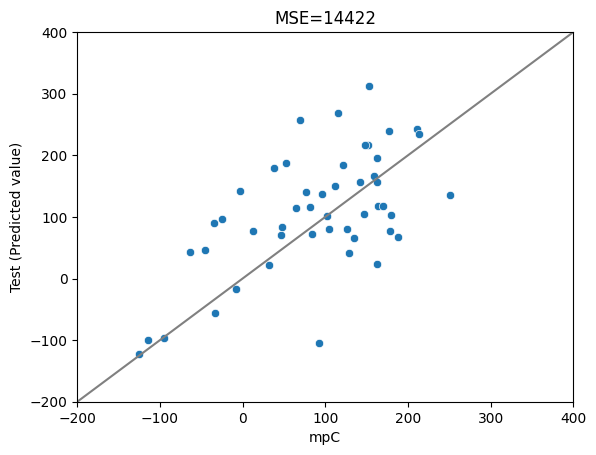

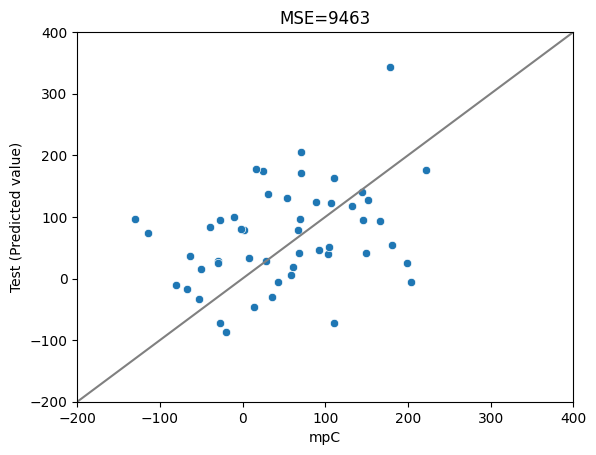

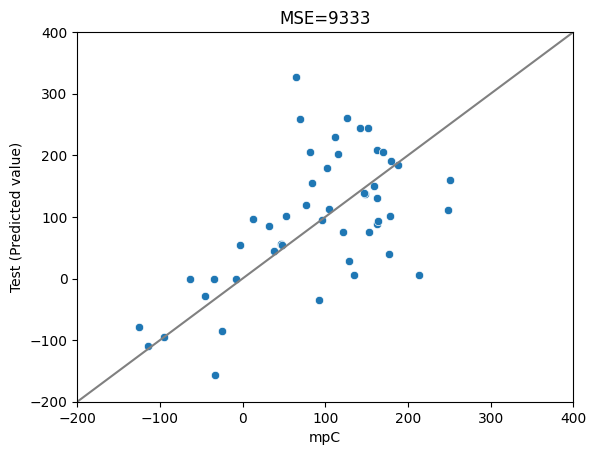

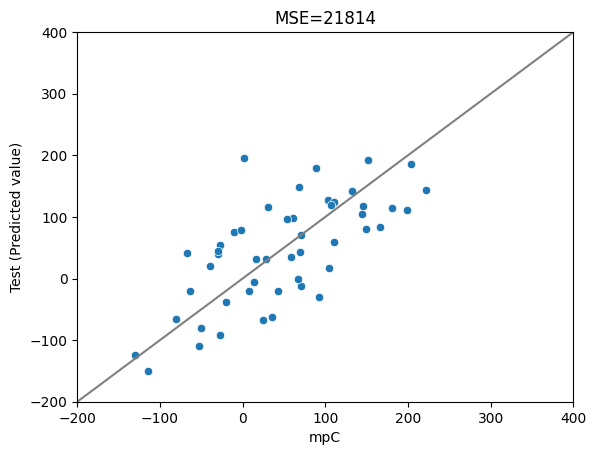

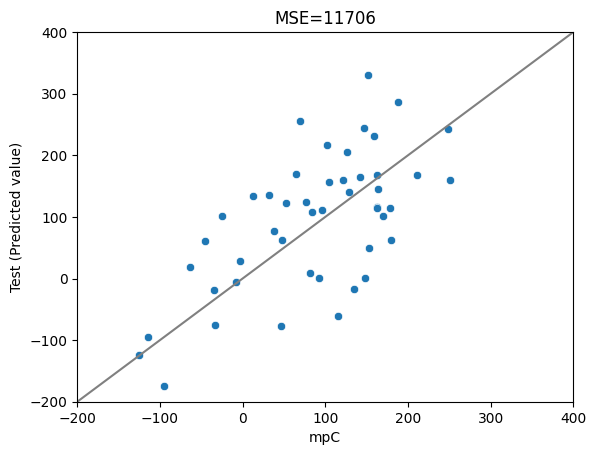

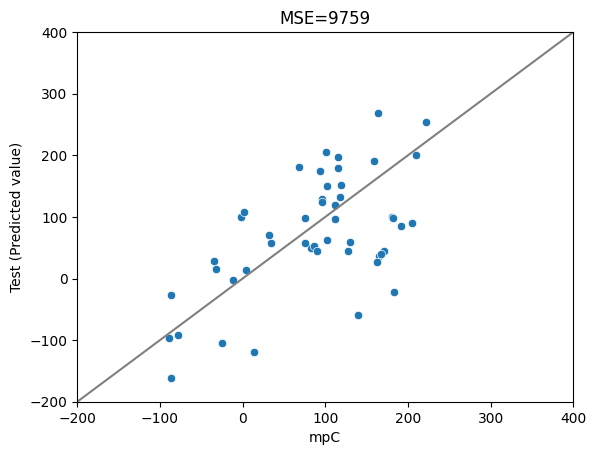

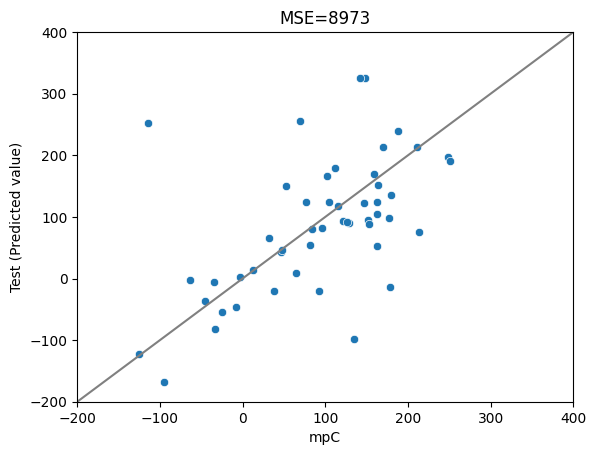

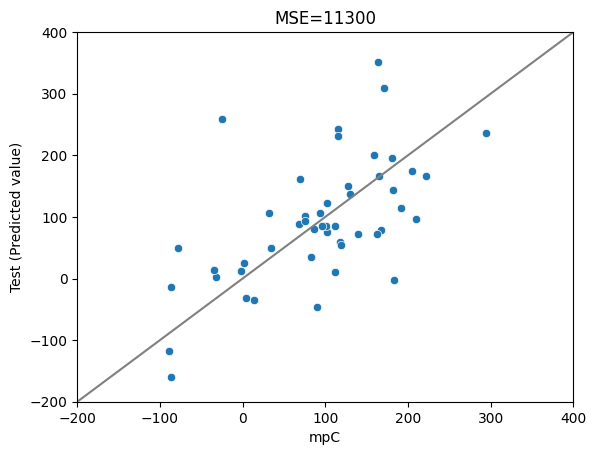

In [7]:
#evaluation w/o training

# %%
model_dict = {
    "GPT-3.5-turbo": {
        "name": "gpt-3.5-turbo-1106",
        "modules": [
        ]
    },
    "GPT-4-turbo":{
    "name":"gpt-4-1106-preview",
    "modules":[]
    },
    "GPT-3.5-turbo-FT10":{
    "name":"ft:gpt-3.5-turbo-1106:personal::8kicrQm5",
    "modules":[]
    },
    "GPT-3.5-turbo-FT20":{
    "name":"ft:gpt-3.5-turbo-1106:personal::8kiw9gBe",
    "modules":[]
    },
    "GPT-3.5-turbo-FT50":{
    "name":"ft:gpt-3.5-turbo-1106:personal::8kiwu9s0",
    "modules":[]
    },
    "GPT-3.5-turbo-FT100":{
    "name":"ft:gpt-3.5-turbo-1106:personal::8kj2LEBW",
    "modules":[]
    },
    "GPT-3.5-turbo-FT1000":{
    "name":"ft:gpt-3.5-turbo-1106:personal::8kjjvdVF",
    "modules":[]
    },
    "GPT-3.5-turbo-FT2000":{
    "name":"ft:gpt-3.5-turbo-1106:personal::8kjpsHdG",
    "modules":[]
    },

}


df = pd.read_csv(dataset_path)

#dummy values
epochs=3
r=32
n_train=0

for model_nickname in model_dict:
    model_name = model_dict[model_nickname]["name"]
    if model_name=="":
        continue

    if model_nickname.find("FT") >= 0:
        n_train = int(model_nickname.split("FT")[-1])
        model_nickname_="GPT-3.5-turbo"
    else:
        model_nickname_=model_nickname
        n_train=0
    

    for with_reason in [False, True]:
        print("trial----")
        print(f"model {model_name} reason: {with_reason}")
        # project path
        if with_reason:
            project_dir = f"results/projects/240118comparisons/{model_nickname_}_{epochs}_{r}_{n_train}"
        else:
            project_dir = f"results/projects/240118comparisons_wo_reason/{model_nickname_}_{epochs}_{r}_{n_train}"
        print("Task :", project_dir)


        # make project dir
        make_project_dirs(project_dir)

        # load dataset
        dataset = df.to_dict(orient="records")
        random.seed(0)
        random.shuffle(dataset)

        # prediction without reason
        if not with_reason:
            for data in dataset:
                data["Reason"] = "-"

        train_dataset = dataset[:max(n_train, n_prompt_examples)]
        test_dataset = dataset[-n_test:]

        random.shuffle(train_dataset)
        # eval
        train_check_dataset = copy.deepcopy(
            train_dataset[:n_train_check])
        random.shuffle(train_check_dataset)
        model=model_name
        tokenizer=None
        if len(glob.glob(f"{project_dir}/eval/test*")) > 0:
            print(f"test exists: {project_dir}")
        else:
            test_eval_result = eval_model(model, tokenizer, test_dataset,
                                            f"{project_dir}/eval",
                                            n_prompt_examples=n_prompt_examples,
                                            prefix=f"test",
                                            gpt_mode=True,
                                            n_max_trials=3
                                            )
        if len(glob.glob(f"{project_dir}/eval/train*")) > 0:
            print(f"train exists: {project_dir}")
        else:
            if n_train>0:
                train_eval_result = eval_model(model, tokenizer, train_check_dataset,
                                        f"{project_dir}/eval",
                                        n_prompt_examples=n_prompt_examples,
                                        prefix=f"train",
                                        gpt_mode=True,
                                        n_max_trials=3
                                        )

In [8]:
from llmchem.dataset import generate_question_prompt,gen_train_text


In [9]:
import json
# JSONL形式でファイルに書き出す
ft_text_base_dir="results/projects/240125gpt3_train_text"
for n_train in [ 5, 10, 20, 50, 100, 1000, 2000, 5000, 10000]:
    for with_reason in [False, True]:
        # load dataset
        dataset = df.to_dict(orient="records")
        random.seed(0)
        random.shuffle(dataset)

        # prediction without reason
        if not with_reason:
            for data in dataset:
                data["Reason"] = "-"

        train_dataset = dataset[:max(n_train, n_prompt_examples)]
        test_dataset = dataset[-n_test:]

        random.shuffle(train_dataset)
        train_json_list=[]
        for train_id in range(len(train_dataset)):
            question = generate_question_prompt(
                train_dataset, train_id, n_prompt_examples=0).strip()

            answer=f""" {train_dataset[train_id]["Reason"]}
##Prediction: {train_dataset[train_id]["Prediction(integer)"]}"""
            json_data={"messages": [
                {"role": "system", "content":"You are a professional chemist, who only output ##Reason and ##Prediction. Complete the text. Never output anything else."},
                {"role": "user", "content": question},
                                        {"role": "assistant", "content": answer}]}

            train_json_list.append(json_data)
        with open(f"{ft_text_base_dir}/ft{n_train}.jsonl", 'w') as file:
            for data in train_json_list:
                json_data = json.dumps(data)
                file.write(json_data + '\n')